[ Related Medium post: https://medium.com/stanford-cs224w/gnn-based-link-prediction-in-drug-drug-interaction-networks-c0e2136e4a72 ]

# GNN-Based Link Prediction in Drug-Drug Interaction Networks
Welcome! This colab serves as a tutorial for using Graph Machine Learning to perform Link Prediction in the drug-drug interaction dataset. Particularly, we focus on applying **GraphSage**, a type of **Graph Neural Network (GNN)**, to the `ogbl-ddi` dataset.

Over the course of this colab, we will begin development from the ground-up: from downloading the dataset, to writing training code to prepare a base model using [PyTorch Geometric (PyG)](https://pytorch-geometric.readthedocs.io/en/latest/), to implementing increasingly advanced techniques to try and improve our performance. We would strongly encourage you to make use of GPU runtime as you go through this notebook. Now, let's get started!

## Setup

### Installation

We first will install PyG as well as [ogb](https://github.com/snap-stanford/ogb).

In [2]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.0.1


In [3]:


!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric
!pip install ogb

Looking in links: https://data.pyg.org/whl/torch-2.0.1.html

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Looking in links: https://data.pyg.org/whl/torch-2.0.1.html

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Imports

In [4]:
import torch.nn.functional as F
import networkx as nx
import random
import torch_geometric.transforms as T

from torch import Tensor
from torch.utils.data import DataLoader
from torch_geometric.utils import negative_sampling, convert, to_dense_adj
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.nn.conv import MessagePassing
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator

/Users/matigasstron/Documents/TFM/venv_llm_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset
As mentioned above, the dataset that we are working with is [ogbl-ddi](https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi). Briefly, in the homogenous, feature-less, undirected graph, each node represents a drug. Edges between nodes represent interactions between the drugs, where the joint effect of taking both drugs is markedly different than the expected effects if either drug was taken independently.

### Installation and Exploration

The `ogb` library makes downloading an official ogb dataset, like ogbl-ddi, incredibly easy.

Below, we download the (non-sparse) version of the dataset and explore it using NetworkX, a popular Python library for working with graphs/networks. To do so, we leverage PyG utilities to convert the dataset into a NetworkX graph.

In [5]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi')
data = dataset[0]
G = convert.to_networkx(data, to_undirected=True)

We know gather some statistics about the graph using NetworkX.

In [6]:
num_nodes, num_edges = G.number_of_nodes(), G.number_of_edges()
print(data.num_edges)
# (*) means that this number refers to the edges that are considered as train
# in the split (80% train - 10% valid - 10% test).
# This total number of edges is 100/80 times this number
print(f'ogbl-ddi has {num_nodes} nodes and {num_edges} edges (*), with an average node degree of {round(2 * num_edges / num_nodes)}')

2135822
ogbl-ddi has 4267 nodes and 1067911 edges (*), with an average node degree of 501


We wrap up our exploration of this graph by visualizing a subgraph of it (feel free to adjust `num_nodes_to_sample` to see more or less of the graph, though anything above 1000 will take a bit of time to render).

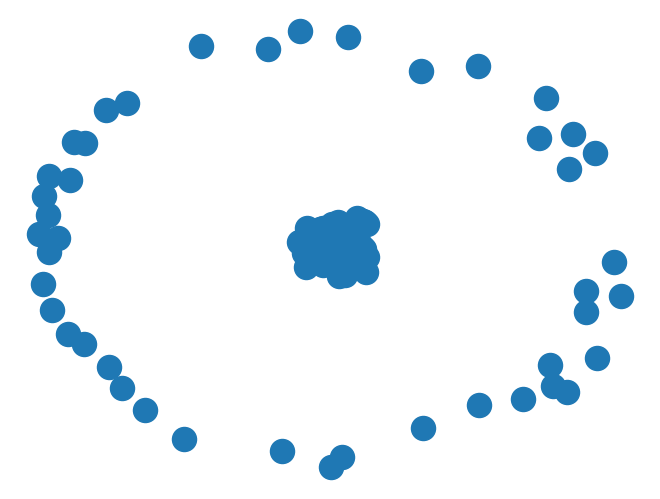

In [6]:
num_nodes_to_sample = 400
sampled_nodes = random.sample(list(G.nodes), num_nodes_to_sample)
sampled_graph = G.subgraph(sampled_nodes)
nx.draw(sampled_graph, with_labels=False)

Now, it's time to download the sparse version of the graph that we are actually going to make use of when developing models. We will use this version of the dataset to get our edge splits (train, validation, test).


In [7]:
dataset = PygLinkPropPredDataset(name='ogbl-ddi',
                                     transform=T.ToSparseTensor())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = dataset[0]
adj_t = data.adj_t.to(device)

# From https://ogb.stanford.edu/docs/linkprop/:
# We develop a protein-target split, meaning that we split drug edges according
# to what proteins those drugs target in the body. As a result, the test set
# consists of drugs that predominantly bind to different proteins from drugs in
# the train and validation sets. This means that drugs in the test set work
# differently in the body, and have a rather different biological mechanism of
# action than drugs in the train and validation sets. The protein-target split
# thus enables us to evaluate to what extent the models can generate practically
# useful predictions, i.e., non-trivial predictions that are not hindered by the
# assumption that there exist already known and very similar medications
# available for training.

# According to the documentation, the total number of edges is 1334889, which is
# exactly 1067911+133489+133489 (train+valid+test)
# However, the graph stats (the num_edges attribute) indicate that the TOTAL
# number of edges (not just the train split) is 1067911
# My interpretation is that the grph as it is downloaded only contains the
# training edges; however, the get_edge_split function somehow adds the valid
# and test positive edges, together with the valid and test negative edges.
split_edge = dataset.get_edge_split()

In [8]:
print(f'ogbl-ddi has {data.num_nodes} nodes and {data.num_edges} (directed) edges, with an average node degree of {round(data.num_edges / data.num_nodes)}')
print(f"Number of training edges: {split_edge['train']['edge'].shape[0]}")
print(f"Number of validation edges: {split_edge['valid']['edge'].shape[0]} positive, {split_edge['valid']['edge_neg'].shape[0]} negative")
print(f"Number of test edges: {split_edge['test']['edge'].shape[0]} positive, {split_edge['test']['edge_neg'].shape[0]} negative")

ogbl-ddi has 4267 nodes and 2135822 (directed) edges, with an average node degree of 501
Number of training edges: 1067911
Number of validation edges: 133489 positive, 101882 negative
Number of test edges: 133489 positive, 95599 negative


In [9]:
from torch_geometric.utils import negative_sampling

train_edge_index = split_edge['train']['edge'].t()
neg_edge_index = negative_sampling(
    edge_index=train_edge_index,
    num_nodes=data.num_nodes,
    num_neg_samples=train_edge_index.size(1)
)

split_edge['train']['edge_neg'] = neg_edge_index.t()

print(f"✅ Negativos generados: {split_edge['train']['edge_neg'].shape}")


✅ Negativos generados: torch.Size([1067911, 2])


Finally, as ogbl-ddi has no node features, we will initialize our own (constant) initial embeddings for all the nodes. We will make use of `emb` once we get into the thick of training our own model below. Note, to be more inductive, we have opted not to make our embeddings learned parameters, unlike prior work with ogbl-ddi.

In [10]:
emb = torch.ones(num_nodes, 1).to(device)

## Base GraphSage Model

Now that we have our dataset downloaded, we can begin building our baseline model using PyG!

Our base model consists of (1) the GraphSage GNN for generating node embeddings (2) a basic LinkPredictor that simply does a dot product between the two node embeddings followed by a sigmoid. Notice that we are leveraging the built-in [SAGEConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv) layer from PyG, which allows us to quickly get our model up and running. Our base model is heavily inspired by the ogb sample code for ogbl-ddi, which can be found here: https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py

In [11]:
class SAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
              dropout, aggr="add"):
    super(SAGE, self).__init__()

    self.convs = torch.nn.ModuleList()
    self.convs.append(SAGEConv(in_channels, hidden_channels, normalize=True, aggr=aggr))
    for _ in range(num_layers - 2):
      self.convs.append(SAGEConv(hidden_channels, hidden_channels, normalize=True, aggr=aggr))
    self.convs.append(SAGEConv(hidden_channels, out_channels, normalize=True, aggr=aggr))

    self.dropout = dropout

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()

  def forward(self, x, adj_t):
    for conv in self.convs[:-1]:
      x = conv(x, adj_t)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.convs[-1](x, adj_t)
    return x

class DotProductLinkPredictor(torch.nn.Module):
  def __init__(self):
    super(DotProductLinkPredictor, self).__init__()

  def forward(self, x_i, x_j):
    out = (x_i*x_j).sum(-1)
    return torch.sigmoid(out)

  def reset_parameters(self):
    pass

To help familiarize readers with how the GNN and LinkPredictor work, below we apply the untrained model to the training graph and use the output node embeddings to make link predictions. While the results will be terrible, it does give a good sense of how to make use of these PyG-based models.

We have chosen a `hidden_dimension` / embedding dimensionality of 256. As the diameter of the graph (computed using NetworkX [diameter](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html) method; not included in this Colab as it takes a long time to run) is 5 and a general rule of thumb says to keep the receptive field of the GNN slightly higher than that, we have chosen a 7-layer GraphSage model.

In [12]:
# Initialize our model and LinkPredictor
hidden_dimension = 256
model = SAGE(1, hidden_dimension, hidden_dimension, 7, 0.5).to(device)
print(model)

predictor = DotProductLinkPredictor().to(device)
print(predictor)

# Run our initial "node features" through the GNN to get node embeddings
model.eval()
predictor.eval()
h = model(emb, adj_t)

SAGE(
  (convs): ModuleList(
    (0): SAGEConv(1, 256, aggr=add)
    (1-6): 6 x SAGEConv(256, 256, aggr=add)
  )
)
DotProductLinkPredictor()


/Users/matigasstron/Documents/TFM/venv_llm_clean/lib/python3.11/site-packages/torch_sparse/tensor.py:574: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)
  return torch.sparse_csr_tensor(rowptr, col, value, self.sizes())


##Training and Evaluation

Now we will define functions that we will use for training and evaluating our models! Once again, we took much inspiration from https://github.com/snap-stanford/ogb/blob/master/examples/linkproppred/ddi/gnn.py.

### Training Drivers
We leverage a fairly standard PyTorch training loop. For each batch of positive edges from our initial training split, we leverage PyG's [negative_sampling](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html?highlight=negative_sampling#torch_geometric.utils.negative_sampling) utility to create an equivalently sized batch of negative edges (i.e. edges NOT present in the training graph). The complete training batch thus contains an equal amount of positive and negative edges.

For every batch, we generate node embeddings using all the training edges. We then make link predictions for the current batch and compute our loss, from which we backpropagate  to update our model.

In [13]:
def create_train_batch(all_pos_train_edges, perm, edge_index):
  # First, we get our positive edges, reshaping them to the form (2, hidden_dimension)
  pos_edges = all_pos_train_edges[perm].t().to(device)

  # We then sample the negative edges using PyG functionality
  neg_edges = negative_sampling(edge_index, num_nodes=num_nodes,
                                num_neg_samples=perm.shape[0], method='dense').to(device)

  # Our training batch is just the positive edges concatanted with the negative ones
  train_edges = torch.cat([pos_edges, neg_edges], dim=1)

  # Our labels are all 1 for the positive edges and 0 for the negative ones
  pos_labels = torch.ones(pos_edges.shape[1], )
  neg_labels = torch.zeros(neg_edges.shape[1], )
  train_labels = torch.cat([pos_labels, neg_labels], dim=0).to(device)

  return train_edges, train_labels

def train(model, predictor, x, adj_t, split_edge, loss_fn, optimizer, batch_size, num_epochs, edge_model=False, spd=None):
  # adj_t isn't used everywhere in PyG yet, so we switch back to edge_index for negative sampling
  row, col, edge_attr = adj_t.t().coo()
  edge_index = torch.stack([row, col], dim=0)

  model.train()
  predictor.train()

  model.reset_parameters()
  predictor.reset_parameters()

  all_pos_train_edges = split_edge['train']['edge']
  for epoch in range(num_epochs):
    epoch_total_loss = 0
    for perm in DataLoader(range(all_pos_train_edges.shape[0]), batch_size, shuffle=True):
      optimizer.zero_grad()

      train_edge, train_label = create_train_batch(all_pos_train_edges, perm, edge_index)

      # Use the GNN to generate node embeddings
      if edge_model:
        h = model(x, edge_index, spd)
      else:
        h = model(x, adj_t)

      # Get predictions for our batch and compute the loss
      preds = predictor(h[train_edge[0]], h[train_edge[1]])
      loss = loss_fn(preds, train_label)

      epoch_total_loss += loss.item()

      # Update our parameters
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
      optimizer.step()

    print(f'Epoch {epoch} has loss {round(epoch_total_loss, 4)}')

### Evaluation Drivers
Our evaluation code is also fairly standard PyTorch. As our validation and test splits from ogb already come with negative edges, we are able to easily leverage them instead of generating our own.

Like with the training code, we use the training graph to generate node embeddings using our GNN. We then calculate predictions using the LinkPredictor for our positive and negative edges. Although we calculate accuracy ourselves, we leverage the [Evaluator](https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/linkproppred/evaluate.py#L11) provided by the ogb library for ogbl-ddi to calculate Hits@K. Though we demonstrate how to calculate Hits@K for several values of K, in keeping with prior work, we focus on Hits@20 as our primary metric.

In [14]:
def accuracy(pred, label):
  pred_rounded = torch.round(pred)
  accu = torch.eq(pred_rounded, label).sum() / label.shape[0]
  accu = round(accu.item(), 4)
  return accu

@torch.no_grad()
def test(model, predictor, x, adj_t, split_edge, evaluator, batch_size, edge_model=False, spd=None):
  model.eval()
  predictor.eval()

  if model is None or isinstance(model, DummyModel):
    # Ya tenemos los embeddings precomputados en x
    h = x
  elif edge_model:
      row, col, edge_attr = adj_t.t().coo()
      edge_index = torch.stack([row, col], dim=0)
      h = model(x, edge_index, spd)
  else:
      h = model(x, adj_t)


  pos_eval_edge = split_edge['edge'].to(device) # ALL positive edges? Just validation (look at the actual parameter)
  neg_eval_edge = split_edge['edge_neg'].to(device) # ALL negative edges? Just validation

  pos_eval_preds = []
  for perm in DataLoader(range(pos_eval_edge.shape[0]), batch_size):
    edge = pos_eval_edge[perm].t()
    pos_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
  pos_eval_pred = torch.cat(pos_eval_preds, dim=0)

  neg_eval_preds = []
  for perm in DataLoader(range(neg_eval_edge.size(0)), batch_size):
    edge = neg_eval_edge[perm].t()
    neg_eval_preds += [predictor(h[edge[0]], h[edge[1]]).squeeze().cpu()]
  neg_eval_pred = torch.cat(neg_eval_preds, dim=0)

  total_preds = torch.cat((pos_eval_pred, neg_eval_pred), dim=0)
  labels = torch.cat((torch.ones_like(pos_eval_pred), torch.zeros_like(neg_eval_pred)), dim=0)
  acc = accuracy(total_preds, labels)

  results = {}
  for K in [10, 20, 30, 40, 50]:
    evaluator.K = K
    valid_hits = evaluator.eval({
      'y_pred_pos': pos_eval_pred,
      'y_pred_neg': neg_eval_pred,
    })[f'hits@{K}']
    results[f'Hits@{K}'] = (valid_hits)
    print(f"  {round(valid_hits*len(pos_eval_pred))} positive edges (out of {len(pos_eval_pred)}) are ranked into the {K} (out of {len(neg_eval_pred)}) top-ranked negative edges")
  results['Accuracy'] = acc
  # This metric does not seem to be supported by the Evaluator
  #results['Rocauc'] = evaluator.eval({
  #    'y_pred_pos': pos_eval_pred,
  #    'y_pred_neg': neg_eval_pred,
  #  })['rocauc']

  return results

eval = Evaluator(name='ogbl-ddi')
# ogb Evaluators can be invoked to get their expected format
print(eval.expected_input_format)

==== Expected input format of Evaluator for ogbl-ddi
{'y_pred_pos': y_pred_pos, 'y_pred_neg': y_pred_neg}
- y_pred_pos: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
- y_pred_neg: numpy ndarray or torch tensor of shape (num_edges, ). Torch tensor on GPU is recommended for efficiency.
y_pred_pos is the predicted scores for positive edges.
y_pred_neg is the predicted scores for negative edges.
Note: As the evaluation metric is ranking-based, the predicted scores need to be different for different edges.


In [15]:
# Prints the prediction for n_pred random positive edges and n_pred random negative edges
def pick_random_predictions(model,n_pred):
  model.eval()
  predictor.eval()

  n_correct_pos = 0
  n_incorrect_pos = 0
  n_correct_neg = 0
  n_incorrect_neg = 0

  h = model(emb, adj_t)

  # Randomly sample some validation edges and pass them through our basic predictor
  idx = torch.randperm(split_edge['valid']['edge'].size(0))[:n_pred]
  edges = split_edge['valid']['edge'][idx].t()

  print(f"Prediction for {n_pred} random positive validation edges:")
  for i in idx:
    e0 = split_edge['valid']['edge'][i].t()[0]
    e1 = split_edge['valid']['edge'][i].t()[1]
    y = predictor(h[e0], h[e1]).item()
    if y > 0.5:
      n_correct_pos += 1
    else:
      n_incorrect_pos += 1
    print(f"    ({e0}, {e1}) -> {y}")

  print(f"  Correct: {n_correct_pos}; Incorrect: {n_incorrect_pos}; Accuracy: {n_correct_pos/(n_correct_pos+n_incorrect_pos)}")

  # Randomly sample some validation edges and pass them through our basic predictor
  idx = torch.randperm(split_edge['valid']['edge_neg'].size(0))[:n_pred]
  edges = split_edge['valid']['edge_neg'][idx].t()

  print(f"Prediction for {n_pred} random negative validation edges:")
  for i in idx:
    e0 = split_edge['valid']['edge_neg'][i].t()[0]
    e1 = split_edge['valid']['edge_neg'][i].t()[1]
    y = predictor(h[e0], h[e1]).item()
    if y > 0.5:
      n_incorrect_neg += 1
    else:
      n_correct_neg += 1
    print(f"    ({e0}, {e1}) -> {y}")

  print(f"  Correct: {n_correct_neg}; Incorrect: {n_incorrect_neg}; Accuracy: {n_correct_neg/(n_correct_neg+n_incorrect_neg)}")

  print()
  print(f"  Correct: {n_correct_pos+n_correct_neg}; Incorrect: {n_incorrect_pos+n_incorrect_neg}; Accuracy: {(n_correct_pos+n_correct_neg)/(n_correct_pos+n_correct_neg+n_incorrect_pos+n_incorrect_neg)}")

### Train and Evaluate Baseline Model
Now we are ready to kick-off training of our base model and evaluate it with our validation set. As we will do with all of our models, we make use of the Adam optimizer and Binary Cross-Entropy loss. Readers should feel free to experiment with other optimizers/loss functions as they see fit.

*This cell will take around 2-3 minutes to run.*

In [15]:
optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.05)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)
print(test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64*1024))
pick_random_predictions(model,30)

Epoch 0 has loss 11.8905
Epoch 1 has loss 10.3882
Epoch 2 has loss 10.2227
Epoch 3 has loss 10.1212
Epoch 4 has loss 10.0427
Epoch 5 has loss 9.998
Epoch 6 has loss 9.8534
Epoch 7 has loss 9.795
Epoch 8 has loss 9.6787
Epoch 9 has loss 9.7671
Epoch 10 has loss 9.6125
Epoch 11 has loss 9.5647
Epoch 12 has loss 9.5835
Epoch 13 has loss 9.5524
Epoch 14 has loss 9.5112
Epoch 15 has loss 9.5074
Epoch 16 has loss 9.5075
Epoch 17 has loss 9.4914
Epoch 18 has loss 9.5171
Epoch 19 has loss 9.5017
Epoch 20 has loss 9.4727
Epoch 21 has loss 9.4602
Epoch 22 has loss 9.4674
Epoch 23 has loss 9.4538
Epoch 24 has loss 9.4679
Epoch 25 has loss 9.4459
Epoch 26 has loss 9.4415
Epoch 27 has loss 9.5168
Epoch 28 has loss 9.4694
Epoch 29 has loss 9.4313
Epoch 30 has loss 9.4317
Epoch 31 has loss 9.4226
Epoch 32 has loss 9.4419
Epoch 33 has loss 9.4218
Epoch 34 has loss 9.4409
Epoch 35 has loss 9.4268
Epoch 36 has loss 9.4281
Epoch 37 has loss 9.4087
Epoch 38 has loss 9.4197
Epoch 39 has loss 9.4144
Epoch 4

In [16]:
results_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🎯 Resultados del modelo base:")
for k, v in results_base.items():
    print(f"{k}: {v:.4f}")

  0 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  0 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  0 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  0 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  4 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges

🎯 Resultados del modelo base:
Hits@10: 0.0000
Hits@20: 0.0000
Hits@30: 0.0000
Hits@40: 0.0000
Hits@50: 0.0000
Accuracy: 0.7764


In [16]:
import openai

client = openai.OpenAI(api_key="sk-...")  # ← poné aquí tu clave

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant specialized in graph-based machine learning."
        },
        {
            "role": "user",
            "content": """
You are an expert in graph-based machine learning and biomedical networks.

We are working with a biomedical interaction graph where:
- Each node represents a drug.
- Each undirected edge represents a known interaction between two drugs.
- The graph contains 4,267 nodes and 2,135,822 directed edges (equivalent to 1,067,911 undirected edges).
- The average node degree is approximately 501.
- There are no node features available. Only the graph structure is used.

Our goal is to perform link prediction: predicting whether a link exists between a given pair of nodes.

Please analyze the characteristics of this graph and describe:
1. What kind of topological patterns or structures (e.g., hubs, communities, motifs) might be useful for link prediction?
2. What high-level reasoning or semantic cues could be inferred from this kind of interaction network?
3. How would you semantically describe the types of connections or clusters you expect in a drug–drug interaction graph like this?

This output will be transformed into an embedding and used as additional semantic input to enhance the performance of a graph neural network for link prediction.
"""
        }
    ],
    temperature=0.7
)

print("=== GPT Response ===\n")
print(response.choices[0].message.content)

=== GPT Response ===

1. In a drug-drug interaction graph like the one described, several topological patterns and structures could be useful for link prediction:
   - Hubs: Nodes with a high degree of connections, representing drugs that interact with many other drugs. These hubs could play a crucial role in link prediction as they are likely to be involved in multiple interactions.
   - Communities: Groups of nodes that are more densely connected within the group than with the rest of the graph. Identifying communities can help in understanding clusters of drugs that interact closely with each other, potentially indicating similar mechanisms of action or shared pharmacological properties.
   - Motifs: Small, recurring patterns in the network that may provide insights into specific interaction patterns between drugs, such as feedback loops or feedforward structures.

2. From this type of interaction network, high-level reasoning or semantic cues that could be inferred include:
   - Dr

In [17]:
gpt_response = response.choices[0].message.content


with open("gpt_ddi_summary_run2.txt", "w", encoding="utf-8") as f:
    f.write(gpt_response)

print("✅ Respuesta guardada en 'gpt_ddi_summary_run2.txt'")

✅ Respuesta guardada en 'gpt_ddi_summary_run2.txt'


In [52]:
from sentence_transformers import SentenceTransformer

with open("gpt_ddi_summary_run2.txt", "r", encoding="utf-8") as f:
    gpt_response_text = f.read()

# Cargar el modelo BERT compacto
model = SentenceTransformer("all-MiniLM-L6-v2")

# Obtener el embedding vectorial del texto
embedding = model.encode(gpt_response_text)

print("Dimensión del embedding:", embedding.shape)
print("Primeros valores:", embedding[:10])


Dimensión del embedding: (384,)
Primeros valores: [ 0.0432975  -0.07707488 -0.05820531 -0.00986097  0.04603406  0.00062814
 -0.00918771  0.09237258  0.05976453 -0.08219253]


In [19]:
import numpy as np

np.save("gpt_ddi_embedding_run2.npy", embedding)
print("✅ Embedding guardado en 'gpt_ddi_embedding_run2.npy'")

✅ Embedding guardado en 'gpt_ddi_embedding_run2.npy'


In [53]:
import numpy as np

embedding_global = np.load("gpt_ddi_embedding_run2.npy")
embedding_global = torch.tensor(embedding_global, dtype=torch.float32).to(device)


In [21]:
aug_emb = torch.cat([emb, embedding_global.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

In [107]:
model = SAGE(385,hidden_dimension, hidden_dimension, 7, 0.5).to(device)
predictor = DotProductLinkPredictor().to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.05)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)


Epoch 0 has loss 12.1601
Epoch 1 has loss 10.7623
Epoch 2 has loss 10.2396


KeyboardInterrupt: 

In [24]:
results_with_gpt = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n💊 Resultados del modelo CON embedding GPT:")
for k, v in results_with_gpt.items():
    print(f"{k}: {v:.4f}")


  0 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  0 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  0 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  0 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  20 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges

💊 Resultados del modelo CON embedding GPT:
Hits@10: 0.0000
Hits@20: 0.0000
Hits@30: 0.0000
Hits@40: 0.0000
Hits@50: 0.0001
Accuracy: 0.7724


#### Post-Processing Layers
We can also try including post-processing layers in our GNN that do not pass messages, but simply apply a neural network to the embeddings. This can be convenient when the embeddings need to be used in a downstream task, such as the link prediction we wish to perform.

Below, we augment our base `SAGE` model with additional post-processing linear layers that are applied to the output of the GNN layers.

In [16]:
# copied from above ("Post-Processing Layers") in order to be able to run this cell without running the previous ones
class PostProcessSAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_dimension, out_channels, num_conv_layers,
                num_linear_layers, dropout):
    super(PostProcessSAGE, self).__init__()

    self.convs = torch.nn.ModuleList()
    self.lins = torch.nn.ModuleList()

    self.convs.append(SAGEConv(in_channels, hidden_dimension, normalize=True, aggr="add"))
    for _ in range(num_conv_layers - 1):
      self.convs.append(SAGEConv(hidden_dimension, hidden_dimension, normalize=True, aggr="add"))

    for _ in range(num_linear_layers - 1):
      self.lins.append(torch.nn.Linear(hidden_dimension, hidden_dimension))
    self.lins.append(torch.nn.Linear(hidden_dimension, out_channels))

    self.dropout = dropout

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()

  def forward(self, x, adj_t):
    for conv in self.convs[:-1]:
      x = conv(x, adj_t)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.convs[-1](x, adj_t)

    # Post-process
    for lin in self.lins[:-1]:
      x = lin(x)
      x = F.relu(x)
    x = self.lins[-1](x)
    return x

# copied from above ("Base GraphSage Model") in order to be able to run this cell without running the previous ones
class DotProductLinkPredictor(torch.nn.Module):
  def __init__(self):
    super(DotProductLinkPredictor, self).__init__()

  def forward(self, x_i, x_j):
    # dot product of node embeddings, that is meant to be the edge embedding
    out = (x_i*x_j).sum(-1)
    return torch.sigmoid(out)

  def reset_parameters(self):
    pass

class NeuralLinkPredictor(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
               dropout):
    super(NeuralLinkPredictor, self).__init__()

    self.lins = torch.nn.ModuleList()
    self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
    for _ in range(num_layers - 2):
      self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
    self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

    self.dropout = dropout

  def reset_parameters(self):
    for lin in self.lins:
      lin.reset_parameters()

  def forward(self, x_i, x_j):
    x = x_i * x_j
    for lin in self.lins[:-1]:
      x = lin(x)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.lins[-1](x)
    return torch.sigmoid(x).squeeze()

In [26]:
model = PostProcessSAGE(1, hidden_dimension, hidden_dimension, 7, 4, 0.5).to(device) # It was just SAGE in the original code
print(model)

predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 4, 0.5).to(device)
print(predictor)

optimizer = torch.optim.Adam(
            list(model.parameters())  +
            list(predictor.parameters()), lr=0.01)
train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 100)
print(test(model, predictor, emb, adj_t, split_edge["valid"], Evaluator(name='ogbl-ddi'), 64*1024))
pick_random_predictions(model,30)

PostProcessSAGE(
  (convs): ModuleList(
    (0): SAGEConv(1, 256, aggr=add)
    (1-6): 6 x SAGEConv(256, 256, aggr=add)
  )
  (lins): ModuleList(
    (0-3): 4 x Linear(in_features=256, out_features=256, bias=True)
  )
)
NeuralLinkPredictor(
  (lins): ModuleList(
    (0-2): 3 x Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoch 0 has loss 11.7486
Epoch 1 has loss 10.7223
Epoch 2 has loss 24.6591
Epoch 3 has loss 9.6686
Epoch 4 has loss 9.1936
Epoch 5 has loss 8.5739
Epoch 6 has loss 7.991
Epoch 7 has loss 7.568
Epoch 8 has loss 7.453
Epoch 9 has loss 7.3757
Epoch 10 has loss 7.1929
Epoch 11 has loss 7.1749
Epoch 12 has loss 6.8195
Epoch 13 has loss 6.373
Epoch 14 has loss 6.9648
Epoch 15 has loss 6.8372
Epoch 16 has loss 6.5514
Epoch 17 has loss 6.3502
Epoch 18 has loss 5.9041
Epoch 19 has loss 6.0472
Epoch 20 has loss 5.8084
Epoch 21 has loss 5.6413
Epoch 22 has loss 5.7261
Epoch 23 has loss 5.5874
Epoch 24 has l

In [27]:
results_neural = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔍 Resultados del modelo con NeuralLinkPredictor (sin embedding GPT):")
for k, v in results_neural.items():
    print(f"{k}: {v:.4f}")


  4448 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  5421 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  5421 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  5421 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  5421 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges

🔍 Resultados del modelo con NeuralLinkPredictor (sin embedding GPT):
Hits@10: 0.0333
Hits@20: 0.0406
Hits@30: 0.0406
Hits@40: 0.0406
Hits@50: 0.0406
Accuracy: 0.8989


In [26]:
### CORRIDA 1 CORREGIDA

model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + BERT (sin usar el embedding) v1:")
for k, v in results_sage.items():
    print(f"{k}: {v:.4f}")

Epoch 0 has loss 11.7394
Epoch 1 has loss 10.4278
Epoch 2 has loss 9.699
Epoch 3 has loss 9.0932
Epoch 4 has loss 8.408
Epoch 5 has loss 7.7797
Epoch 6 has loss 7.5728
Epoch 7 has loss 7.4241
Epoch 8 has loss 7.1634
Epoch 9 has loss 6.8597
Epoch 10 has loss 6.5289
Epoch 11 has loss 6.0437
Epoch 12 has loss 5.9747
Epoch 13 has loss 5.7626
Epoch 14 has loss 5.5774
Epoch 15 has loss 5.5006
Epoch 16 has loss 5.4981
Epoch 17 has loss 5.5569
Epoch 18 has loss 5.5666
Epoch 19 has loss 5.3689
Epoch 20 has loss 5.2132
Epoch 21 has loss 5.0729
Epoch 22 has loss 5.0992
Epoch 23 has loss 5.0397
Epoch 24 has loss 4.9324
Epoch 25 has loss 4.8769
Epoch 26 has loss 4.9225
Epoch 27 has loss 4.8642
Epoch 28 has loss 4.9871
Epoch 29 has loss 4.8609
Epoch 30 has loss 4.7438
Epoch 31 has loss 4.6543
Epoch 32 has loss 4.6859
Epoch 33 has loss 4.6472
Epoch 34 has loss 4.6344
Epoch 35 has loss 4.5274
Epoch 36 has loss 4.4417
Epoch 37 has loss 4.5753
Epoch 38 has loss 4.525
Epoch 39 has loss 4.4539
Epoch 40 ha

In [28]:
model = PostProcessSAGE(385, hidden_dimension, hidden_dimension, 7, 4, 0.5).to(device)
predictor = NeuralLinkPredictor(hidden_dimension, hidden_dimension, 1, 4, 0.5).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(),
      optimizer, 64 * 1024, 100)

Epoch 0 has loss 11.8043
Epoch 1 has loss 11.7925
Epoch 2 has loss 11.7875
Epoch 3 has loss 11.7841
Epoch 4 has loss 12.806
Epoch 5 has loss 11.5146
Epoch 6 has loss 10.1617
Epoch 7 has loss 9.0117
Epoch 8 has loss 8.1855
Epoch 9 has loss 7.8434
Epoch 10 has loss 7.623
Epoch 11 has loss 7.49
Epoch 12 has loss 7.4683
Epoch 13 has loss 7.5128
Epoch 14 has loss 7.3905
Epoch 15 has loss 7.4785
Epoch 16 has loss 7.5009
Epoch 17 has loss 7.3344
Epoch 18 has loss 7.3592
Epoch 19 has loss 7.3387
Epoch 20 has loss 7.1337
Epoch 21 has loss 6.9071
Epoch 22 has loss 6.6371
Epoch 23 has loss 6.4465
Epoch 24 has loss 6.3106
Epoch 25 has loss 6.1225
Epoch 26 has loss 5.9795
Epoch 27 has loss 5.9869
Epoch 28 has loss 6.2419
Epoch 29 has loss 5.8923
Epoch 30 has loss 5.7596
Epoch 31 has loss 5.7695
Epoch 32 has loss 5.6007
Epoch 33 has loss 5.5768
Epoch 34 has loss 5.6943
Epoch 35 has loss 5.5239
Epoch 36 has loss 5.469
Epoch 37 has loss 5.3538
Epoch 38 has loss 5.3354
Epoch 39 has loss 5.2304
Epoch 40

In [27]:

aug_emb = torch.cat([emb, embedding_global.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SAGE(
    in_channels=aug_emb.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_input = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SAGEConv + BERT (como input) v1:")
for k, v in results_sage_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.593
Epoch 1 has loss 10.6014
Epoch 2 has loss 9.4579
Epoch 3 has loss 8.6678
Epoch 4 has loss 7.9335
Epoch 5 has loss 7.4656
Epoch 6 has loss 7.2588
Epoch 7 has loss 6.7534
Epoch 8 has loss 6.3465
Epoch 9 has loss 6.0354
Epoch 10 has loss 5.9303
Epoch 11 has loss 5.7877
Epoch 12 has loss 5.8461
Epoch 13 has loss 5.7995
Epoch 14 has loss 5.6554
Epoch 15 has loss 5.5236
Epoch 16 has loss 5.4877
Epoch 17 has loss 5.4468
Epoch 18 has loss 5.6057
Epoch 19 has loss 5.4381
Epoch 20 has loss 5.3993
Epoch 21 has loss 5.3887
Epoch 22 has loss 5.3514
Epoch 23 has loss 5.2786
Epoch 24 has loss 5.3654
Epoch 25 has loss 5.2225
Epoch 26 has loss 5.1891
Epoch 27 has loss 5.1437
Epoch 28 has loss 5.2854
Epoch 29 has loss 5.1593
Epoch 30 has loss 5.0992
Epoch 31 has loss 5.0126
Epoch 32 has loss 4.993
Epoch 33 has loss 4.9712
Epoch 34 has loss 4.8394
Epoch 35 has loss 5.06
Epoch 36 has loss 5.04
Epoch 37 has loss 4.7502
Epoch 38 has loss 4.7728
Epoch 39 has loss 4.7833
Epoch 40 has l

In [29]:
results_neural_with_gpt = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n💊 Resultados del modelo con NeuralLinkPredictor + embedding GPT:")
for k, v in results_neural_with_gpt.items():
    print(f"{k}: {v:.4f}")


  7024 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  7024 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  7024 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  27704 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  35513 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges

💊 Resultados del modelo con NeuralLinkPredictor + embedding GPT:
Hits@10: 0.0526
Hits@20: 0.0526
Hits@30: 0.0526
Hits@40: 0.2075
Hits@50: 0.2660
Accuracy: 0.8739


📊 Comparación de resultados:


,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
Modelo,,,,,,
NeuralLink (sin GPT),0.132565,0.171662,0.225854,0.250096,0.273229,0.901
NeuralLink + GPT,0.117703,0.176794,0.197260,0.208849,0.219119,0.892


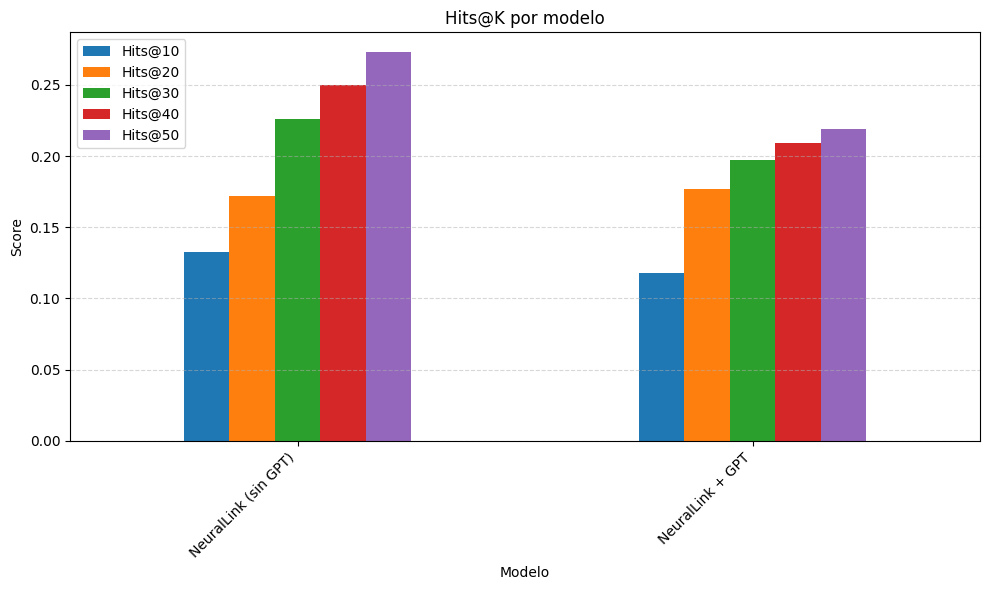

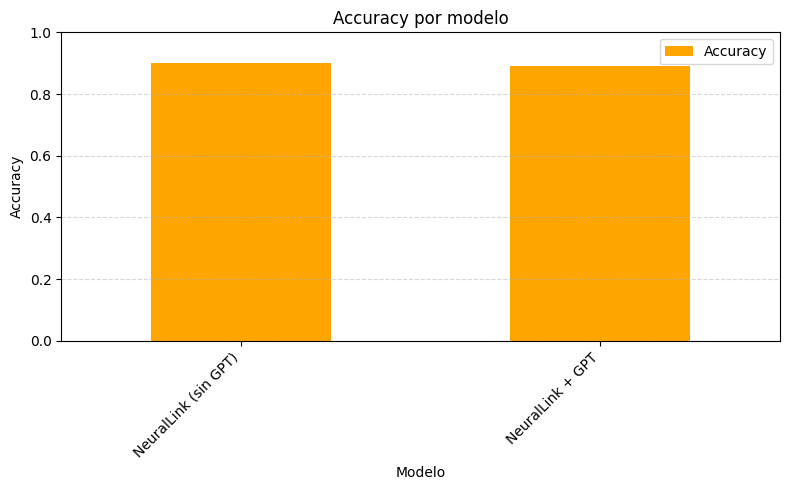

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

results_comparativos = {
    "NeuralLink (sin GPT)": results_sage,
    "NeuralLink + GPT": results_sage_input,
}

# Crear DataFrame
df_results = pd.DataFrame(results_comparativos).T  # transponemos para que los modelos estén como filas
df_results.index.name = "Modelo"

print("📊 Comparación de resultados:")
display(df_results)

# Gráfico de barras para Hits@K
hits_columns = [col for col in df_results.columns if "Hits@" in col]
df_hits = df_results[hits_columns]

ax = df_hits.plot(kind='bar', figsize=(10, 6))
plt.title("Hits@K por modelo")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Gráfico de Accuracy
df_accuracy = df_results[["Accuracy"]]
ax = df_accuracy.plot(kind='bar', figsize=(8, 5), color='orange')
plt.title("Accuracy por modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [32]:
# Resumen textual del mejor modelo por métrica
mejores_modelos = df_results.idxmax()

print("📌 Resumen de mejores modelos por métrica:\n")
for metrica, modelo in mejores_modelos.items():
    valor = df_results.loc[modelo, metrica]
    print(f"🔹 {metrica}: {modelo} (valor = {valor:.4f})")


📌 Resumen de mejores modelos por métrica:

🔹 Hits@10: NeuralLink + GPT (valor = 0.0526)
🔹 Hits@20: NeuralLink + GPT (valor = 0.0526)
🔹 Hits@30: NeuralLink + GPT (valor = 0.0526)
🔹 Hits@40: NeuralLink + GPT (valor = 0.2075)
🔹 Hits@50: NeuralLink + GPT (valor = 0.2660)
🔹 Accuracy: NeuralLink (sin GPT) (valor = 0.8989)


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralLinkPredictorWithGPT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, gpt_emb_dim):
        super().__init__()

        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))

        # La última capa ahora recibe hidden + gpt_embedding
        self.final = nn.Linear(hidden_channels + gpt_emb_dim, out_channels)
        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.final.reset_parameters()

    def forward(self, x_i, x_j, gpt_embedding):
        x = x_i * x_j

        for lin in self.lins:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Expandir gpt_embedding para cada par
        if gpt_embedding.dim() == 1:
            gpt_embedding = gpt_embedding.unsqueeze(0).expand(x.size(0), -1)

        x = torch.cat([x, gpt_embedding], dim=-1)
        x = self.final(x)

        return torch.sigmoid(x).squeeze()


In [18]:
# Clase dummy para no usar el modelo base en el test
class DummyModel(torch.nn.Module):
    def eval(self):
        pass
    def forward(self, *args, **kwargs):
        return None

# Wrapper para incluir el embedding GPT al predictor
class WrappedPredictor(torch.nn.Module):
    def __init__(self, base_predictor, gpt_embedding):
        super().__init__()
        self.base_predictor = base_predictor
        self.gpt_embedding = gpt_embedding

    def eval(self):
        self.base_predictor.eval()

    def forward(self, x_i, x_j):
        gpt_emb = self.gpt_embedding.unsqueeze(0).expand(x_i.size(0), -1)
        return self.base_predictor(x_i, x_j, gpt_emb)

In [51]:
'''
dummy_model = DummyModel()
wrapped_predictor = WrappedPredictor(predictor_gpt_final, embedding_global)

# Realizar evaluación
wrapped_predictor.eval()
with torch.no_grad():
    results_final_gpt = test(
        model=dummy_model,
        predictor=wrapped_predictor,
        x=z,
        adj_t=adj_t,
        split_edge=split_edge["valid"],
        evaluator=eval,
        batch_size=64 * 1024
    )

# Mostrar resultados
print("\n🧪 Resultados del predictor con capa GPT final:")
for k, v in results_final_gpt.items():
    print(f"{k}: {v:.4f}")
    '''

  31070 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  37635 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  41700 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  44987 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  47407 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges

🧪 Resultados del predictor con capa GPT final:
Hits@10: 0.2328
Hits@20: 0.2819
Hits@30: 0.3124
Hits@40: 0.3370
Hits@50: 0.3551
Accuracy: 0.9192


In [30]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z = model(emb, adj_t)

predictor = NeuralLinkPredictorWithGPT(
    in_channels=z.size(1),
    hidden_channels=z.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global.shape[0]
).to(device)

optimizer = torch.optim.Adam(predictor.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor.train()

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor(
            z[edge[0]], z[edge[1]],
            embedding_global.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor, embedding_global)
dummy_model = DummyModel()

results_sage_final = test(dummy_model, wrapped_predictor, z, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔬 Resultados SAGEConv + BERT (en predictor final v1):")
for k, v in results_sage_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6599
Epoch 1 has loss 10.3177
Epoch 2 has loss 10.2075
Epoch 3 has loss 10.1274
Epoch 4 has loss 10.0629
Epoch 5 has loss 10.0376
Epoch 6 has loss 10.0572
Epoch 7 has loss 10.0806
Epoch 8 has loss 9.9703
Epoch 9 has loss 9.8706
Epoch 10 has loss 9.8407
Epoch 11 has loss 9.6549
Epoch 12 has loss 9.6859
Epoch 13 has loss 9.58
Epoch 14 has loss 9.5679
Epoch 15 has loss 9.5434
Epoch 16 has loss 9.5432
Epoch 17 has loss 9.5185
Epoch 18 has loss 9.5142
Epoch 19 has loss 9.5201
Epoch 20 has loss 9.5018
Epoch 21 has loss 9.5098
Epoch 22 has loss 9.5246
Epoch 23 has loss 9.5061
Epoch 24 has loss 9.5009
Epoch 25 has loss 9.4805
Epoch 26 has loss 9.4745
Epoch 27 has loss 9.486
Epoch 28 has loss 9.4808
Epoch 29 has loss 9.4731
Epoch 30 has loss 9.4705
Epoch 31 has loss 9.4685
Epoch 32 has loss 9.4753
Epoch 33 has loss 9.469
Epoch 34 has loss 9.485
Epoch 35 has loss 9.4795
Epoch 36 has loss 9.462
Epoch 37 has loss 9.4577
Epoch 38 has loss 9.4531
Epoch 39 has loss 9.4574
Epoch 40

#### Skip-Connection

A skip-connection, in theory, allows us to have more layers in our GNN. This would allow us to incorporate information from larger k-hop neighborhoods, while somewhat mitigating the risk of over-smoothing node embeddings.

We can quickly build upon our base `SAGE` model to include skip-connections, as demonstrated below.

In [19]:
class SkipConnSAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_dimension, out_channels, num_layers,
                dropout):
    super(SkipConnSAGE, self).__init__()

    self.convs = torch.nn.ModuleList()

    self.convs.append(SAGEConv(in_channels, hidden_dimension, normalize=True, aggr="add"))
    for _ in range(num_layers - 2):
      self.convs.append(SAGEConv(hidden_dimension, hidden_dimension, normalize=True, aggr="add"))
    self.convs.append(SAGEConv(hidden_dimension, out_channels, normalize=True, aggr="add"))

    self.dropout = dropout

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()

  def forward(self, x, adj_t):
    prev_x = None
    for i in range(len(self.convs) - 1):
      prev_x = x
      x = self.convs[i](x, adj_t)
      # Skip Connection
      if i > 0:
        x = x + prev_x
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.convs[-1](x, adj_t)
    return x

With our `SkipConnSAGE` model defined, we can now initiate its training end evaluation, just as we did with `SAGE` before. This time, we will use 10 `SAGEConv` layers.

*This cell will take around 10 minutes to run.*

In [32]:
# Definimos el modelo base
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)


Epoch 0 has loss 11.7128
Epoch 1 has loss 10.6736
Epoch 2 has loss 10.1258
Epoch 3 has loss 10.7489
Epoch 4 has loss 9.8261
Epoch 5 has loss 9.4874
Epoch 6 has loss 10.1746
Epoch 7 has loss 9.8716
Epoch 8 has loss 9.631
Epoch 9 has loss 9.814
Epoch 10 has loss 9.4873
Epoch 11 has loss 9.8333
Epoch 12 has loss 9.5789
Epoch 13 has loss 9.4183
Epoch 14 has loss 9.348
Epoch 15 has loss 9.5112
Epoch 16 has loss 9.1874
Epoch 17 has loss 9.4772
Epoch 18 has loss 9.5587
Epoch 19 has loss 9.0371
Epoch 20 has loss 8.7618
Epoch 21 has loss 8.9743
Epoch 22 has loss 9.1689
Epoch 23 has loss 8.7571
Epoch 24 has loss 9.3734
Epoch 25 has loss 8.9763
Epoch 26 has loss 9.2501
Epoch 27 has loss 8.5601
Epoch 28 has loss 9.1568
Epoch 29 has loss 8.8836
Epoch 30 has loss 8.8834
Epoch 31 has loss 8.9206
Epoch 32 has loss 8.6544
Epoch 33 has loss 8.4481
Epoch 34 has loss 8.6398
Epoch 35 has loss 8.4006
Epoch 36 has loss 8.8481
Epoch 37 has loss 8.6044
Epoch 38 has loss 8.9117
Epoch 39 has loss 9.0521
Epoch 40

In [33]:
results_skipconn = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔎 Resultados SkipConnSAGE (sin GPT):")
for k, v in results_skipconn.items():
    print(f"{k}: {v:.4f}")


  30 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  66 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  107 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  139 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  177 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges

🔎 Resultados SkipConnSAGE (sin GPT):
Hits@10: 0.0002
Hits@20: 0.0005
Hits@30: 0.0008
Hits@40: 0.0010
Hits@50: 0.0013
Accuracy: 0.7420


In [34]:
aug_emb = torch.cat([emb, embedding_global.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SkipConnSAGE(
    in_channels=aug_emb.size(1),  
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)


Epoch 0 has loss 11.1727
Epoch 1 has loss 10.9386
Epoch 2 has loss 10.1991
Epoch 3 has loss 10.2179
Epoch 4 has loss 10.0631
Epoch 5 has loss 10.1411
Epoch 6 has loss 9.961
Epoch 7 has loss 10.1545
Epoch 8 has loss 10.063
Epoch 9 has loss 9.8558
Epoch 10 has loss 10.198
Epoch 11 has loss 10.1198
Epoch 12 has loss 9.9322
Epoch 13 has loss 9.73
Epoch 14 has loss 9.7905
Epoch 15 has loss 10.0071
Epoch 16 has loss 9.9602
Epoch 17 has loss 9.6786
Epoch 18 has loss 9.374
Epoch 19 has loss 9.1066
Epoch 20 has loss 9.2303
Epoch 21 has loss 9.5614
Epoch 22 has loss 9.7368
Epoch 23 has loss 9.4793
Epoch 24 has loss 9.0743
Epoch 25 has loss 9.2116
Epoch 26 has loss 8.868
Epoch 27 has loss 8.8459
Epoch 28 has loss 9.0735
Epoch 29 has loss 8.683
Epoch 30 has loss 8.8179
Epoch 31 has loss 8.4689
Epoch 32 has loss 9.0604
Epoch 33 has loss 9.1882
Epoch 34 has loss 8.9266
Epoch 35 has loss 9.2236
Epoch 36 has loss 8.6274
Epoch 37 has loss 8.444
Epoch 38 has loss 9.3171
Epoch 39 has loss 9.4128
Epoch 40

In [35]:
results_skipconn_gpt_input = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧠 Resultados SkipConnSAGE (con embedding GPT como entrada):")
for k, v in results_skipconn_gpt_input.items():
    print(f"{k}: {v:.4f}")


  108 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  140 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  172 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  248 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  304 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges

🧠 Resultados SkipConnSAGE (con embedding GPT como entrada):
Hits@10: 0.0008
Hits@20: 0.0010
Hits@30: 0.0013
Hits@40: 0.0019
Hits@50: 0.0023
Accuracy: 0.7520


In [36]:
model = SkipConnSAGE(
    in_channels=1,  
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenar solo el modelo base con aug_emb para tener consistencia en input
train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

# Obtener embeddings
model.eval()
with torch.no_grad():
    z_skip = model(emb, adj_t)


Epoch 0 has loss 12.1434
Epoch 1 has loss 10.7378
Epoch 2 has loss 10.4528
Epoch 3 has loss 10.3543
Epoch 4 has loss 10.3932
Epoch 5 has loss 10.3018
Epoch 6 has loss 10.2526
Epoch 7 has loss 10.2198
Epoch 8 has loss 10.178
Epoch 9 has loss 10.2234
Epoch 10 has loss 10.1769
Epoch 11 has loss 10.1939
Epoch 12 has loss 10.1629
Epoch 13 has loss 10.1553
Epoch 14 has loss 10.1147
Epoch 15 has loss 10.1466
Epoch 16 has loss 10.1124
Epoch 17 has loss 10.1363
Epoch 18 has loss 10.0871
Epoch 19 has loss 10.1048
Epoch 20 has loss 10.0731
Epoch 21 has loss 10.091
Epoch 22 has loss 10.0538
Epoch 23 has loss 10.0767
Epoch 24 has loss 10.0276
Epoch 25 has loss 10.0347
Epoch 26 has loss 10.0334
Epoch 27 has loss 10.0108
Epoch 28 has loss 9.9882
Epoch 29 has loss 9.9472
Epoch 30 has loss 9.9629
Epoch 31 has loss 9.9801
Epoch 32 has loss 9.9852
Epoch 33 has loss 9.9471
Epoch 34 has loss 9.9112
Epoch 35 has loss 9.9446
Epoch 36 has loss 9.9161
Epoch 37 has loss 9.899
Epoch 38 has loss 9.8634
Epoch 39 h

In [37]:
gpt_emb_dim = embedding_global.shape[0]

predictor_skip_gpt_final = NeuralLinkPredictorWithGPT(
    in_channels=z_skip.size(1),
    hidden_channels=z_skip.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=gpt_emb_dim
).to(device)
predictor_skip_gpt_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_skip_gpt_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_skip_gpt_final.train()

# Entrenamiento del predictor con GPT concatenado al final (positivos + negativos)
for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(split_edge["train"]["edge"].size(0)), batch_size=64 * 1024, shuffle=True):
        # Edges positivos y negativos del batch
        pos_edge = split_edge["train"]["edge"][perm].t().to(device)
        neg_edge = split_edge["train"]["edge_neg"][perm].t().to(device)

        # Concatenamos edges y labels
        edge = torch.cat([pos_edge, neg_edge], dim=1)
        label = torch.cat([
            torch.ones(pos_edge.size(1), device=device),
            torch.zeros(neg_edge.size(1), device=device)
        ])

        # Entrenamiento
        optimizer.zero_grad()
        pred = predictor_skip_gpt_final(
            z_skip[edge[0]], z_skip[edge[1]],
            embedding_global.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")


📉 Epoch 0, Loss: 11.2950
📉 Epoch 1, Loss: 9.3468
📉 Epoch 2, Loss: 8.8903
📉 Epoch 3, Loss: 8.7354
📉 Epoch 4, Loss: 8.5937
📉 Epoch 5, Loss: 8.6547
📉 Epoch 6, Loss: 8.5244
📉 Epoch 7, Loss: 8.7121
📉 Epoch 8, Loss: 8.6801
📉 Epoch 9, Loss: 8.6235
📉 Epoch 10, Loss: 8.6469
📉 Epoch 11, Loss: 8.6087
📉 Epoch 12, Loss: 8.7386
📉 Epoch 13, Loss: 8.6684
📉 Epoch 14, Loss: 8.6931
📉 Epoch 15, Loss: 8.5563
📉 Epoch 16, Loss: 8.6618
📉 Epoch 17, Loss: 8.5670
📉 Epoch 18, Loss: 8.6099
📉 Epoch 19, Loss: 8.4373
📉 Epoch 20, Loss: 8.5925
📉 Epoch 21, Loss: 8.5894
📉 Epoch 22, Loss: 8.5945
📉 Epoch 23, Loss: 8.4784
📉 Epoch 24, Loss: 8.5052
📉 Epoch 25, Loss: 8.4735
📉 Epoch 26, Loss: 8.5075
📉 Epoch 27, Loss: 8.5167
📉 Epoch 28, Loss: 8.4486
📉 Epoch 29, Loss: 8.6843
📉 Epoch 30, Loss: 8.6084
📉 Epoch 31, Loss: 8.5728
📉 Epoch 32, Loss: 8.6258
📉 Epoch 33, Loss: 8.4891
📉 Epoch 34, Loss: 8.6731
📉 Epoch 35, Loss: 8.5401
📉 Epoch 36, Loss: 8.6655
📉 Epoch 37, Loss: 8.4896
📉 Epoch 38, Loss: 8.5287
📉 Epoch 39, Loss: 8.5311
📉 Epoch 4

In [38]:
wrapped_predictor = WrappedPredictor(predictor_skip_gpt_final, embedding_global)
wrapped_predictor.eval()
dummy_model = DummyModel()

# Ejecutamos la evaluación
with torch.no_grad():
    results_skipconn_gpt_final = test(
        model=dummy_model,
        predictor=wrapped_predictor,
        x=z_skip,
        adj_t=adj_t,
        split_edge=split_edge["valid"],
        evaluator=eval,
        batch_size=64 * 1024
    )

print("\n🔬 Resultados SkipConnSAGE (con embedding GPT en la capa final):")
for k, v in results_skipconn_gpt_final.items():
    print(f"{k}: {v:.4f}")


  437 positive edges (out of 133489) are ranked into the 10 (out of 101882) top-ranked negative edges
  1056 positive edges (out of 133489) are ranked into the 20 (out of 101882) top-ranked negative edges
  1628 positive edges (out of 133489) are ranked into the 30 (out of 101882) top-ranked negative edges
  1992 positive edges (out of 133489) are ranked into the 40 (out of 101882) top-ranked negative edges
  2358 positive edges (out of 133489) are ranked into the 50 (out of 101882) top-ranked negative edges
RESEEEEETTTTT UNOOOOOOOO

🔬 Resultados SkipConnSAGE (con embedding GPT en la capa final):
Hits@10: 0.0033
Hits@20: 0.0079
Hits@30: 0.0122
Hits@40: 0.0149
Hits@50: 0.0177
Accuracy: 0.7774


In [39]:
import pandas as pd

comparative_results = {
    "Base GNN (DotProduct)": results_sage,
    "Base GNN + GPT input": results_sage_input,
    "Base GNN + GPT final": results_sage_final,
    "SkipConnSAGE": results_skipconn,
    "SkipConn + GPT input": results_skipconn_gpt_input,
    "SkipConn + GPT final": results_skipconn_gpt_final
}

df_results = pd.DataFrame(comparative_results).T[
    ["Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"]
]

print("\n📊 Tabla comparativa de resultados:")
display(df_results)  


📊 Tabla comparativa de resultados:


,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
Base GNN (DotProduct),0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
Base GNN + GPT input,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
Base GNN + GPT final,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
SkipConnSAGE,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
SkipConn + GPT input,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
SkipConn + GPT final,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774


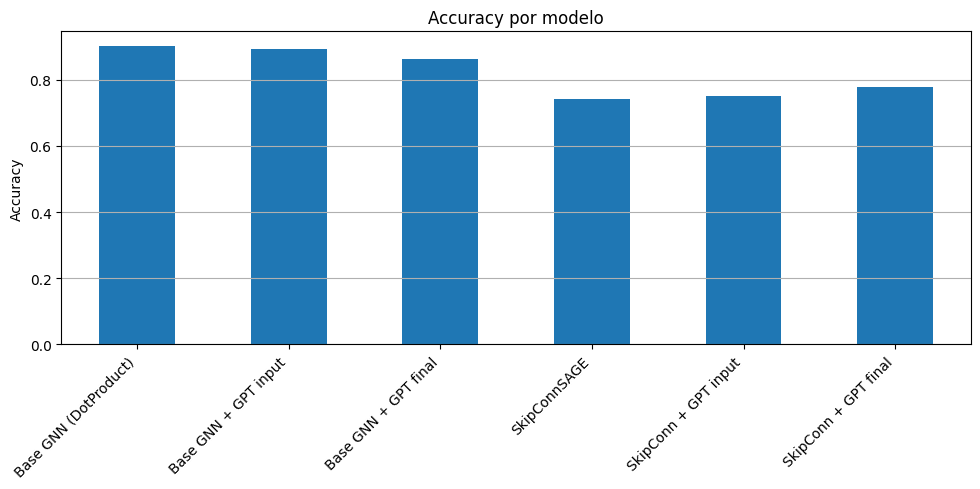

In [40]:
import matplotlib.pyplot as plt

df_results["Accuracy"].plot(kind="bar", figsize=(10, 5), title="Accuracy por modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


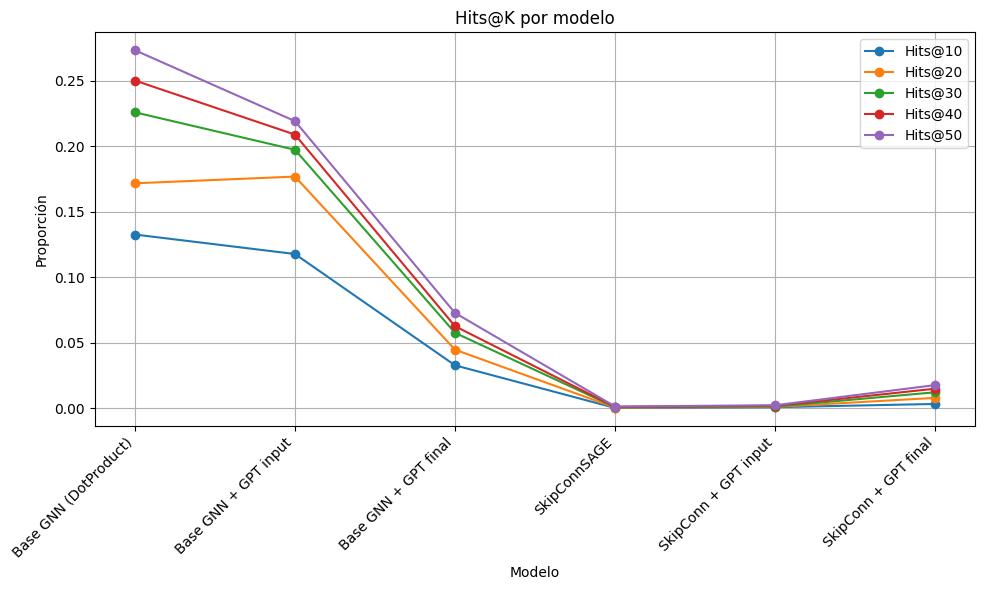

In [41]:
df_results[[f"Hits@{k}" for k in [10, 20, 30, 40, 50]]].plot(kind="line", marker='o', figsize=(10, 6), title="Hits@K por modelo")
plt.ylabel("Proporción")
plt.xlabel("Modelo")
plt.xticks(ticks=range(len(df_results.index)), labels=df_results.index, rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


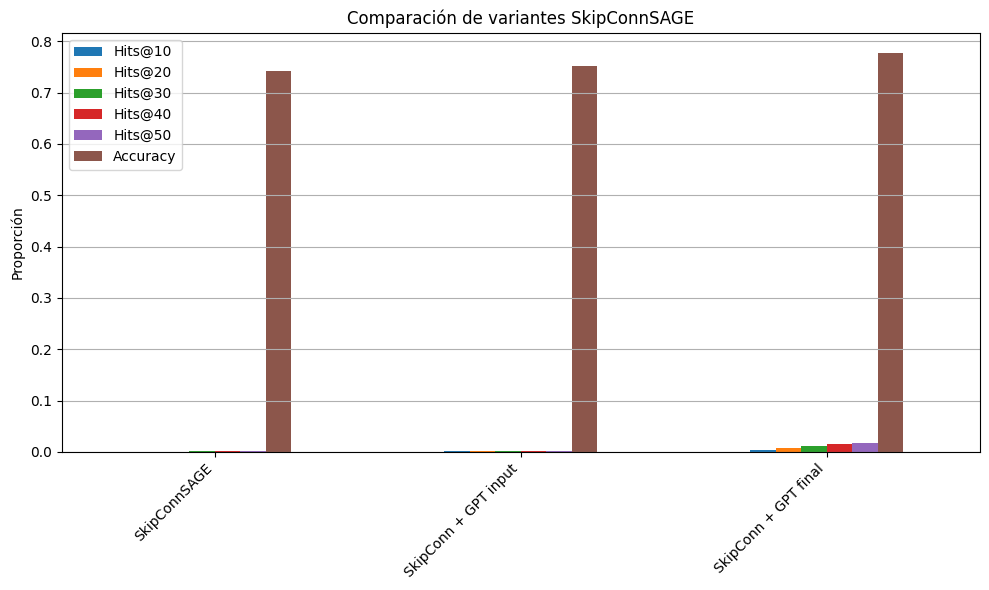

In [42]:
df_results.loc[
    ["SkipConnSAGE", "SkipConn + GPT input", "SkipConn + GPT final"],
    [f"Hits@{k}" for k in [10, 20, 30, 40, 50]] + ["Accuracy"]
].plot(kind="bar", figsize=(10, 6), title="Comparación de variantes SkipConnSAGE")
plt.ylabel("Proporción")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [43]:
import pandas as pd

comparative_results = {
    "Base GNN (DotProduct)": results_sage,
    "Base GNN + GPT input": results_sage_input,
    "Base GNN + GPT final": results_sage_final,
    "SkipConnSAGE": results_skipconn,
    "SkipConn + GPT input": results_skipconn_gpt_input,
    "SkipConn + GPT final": results_skipconn_gpt_final
}

df_results = pd.DataFrame(comparative_results).T[
    ["Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"]
]

df_results["GNN model"] = [
    "SAGE",  # Base GNN (DotProduct)
    "SAGE",  # Base GNN + GPT input
    "SAGE",  # NeuralLinkPredictor
    "SkipConnSAGE",
    "SkipConnSAGE",
    "SkipConnSAGE"
]

df_results["Prompt type"] = "default"
df_results["Embedding source"] = "BERT"

print("\n📊 Tabla comparativa de resultados:")
display(df_results)  


📊 Tabla comparativa de resultados:


,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy,GNN model,Prompt type,Embedding source
Base GNN (DotProduct),0.132565,0.171662,0.225854,0.250096,0.273229,0.9010,SAGE,default,BERT
Base GNN + GPT input,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920,SAGE,default,BERT
Base GNN + GPT final,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618,SAGE,default,BERT
SkipConnSAGE,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420,SkipConnSAGE,default,BERT
SkipConn + GPT input,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520,SkipConnSAGE,default,BERT
SkipConn + GPT final,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774,SkipConnSAGE,default,BERT


In [20]:
class PostProcessSAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_dimension, out_channels, num_conv_layers,
                num_linear_layers, dropout):
    super(PostProcessSAGE, self).__init__()

    self.convs = torch.nn.ModuleList()
    self.lins = torch.nn.ModuleList()

    self.convs.append(SAGEConv(in_channels, hidden_dimension, normalize=True, aggr="add"))
    for _ in range(num_conv_layers - 1):
      self.convs.append(SAGEConv(hidden_dimension, hidden_dimension, normalize=True, aggr="add"))

    for _ in range(num_linear_layers - 1):
      self.lins.append(torch.nn.Linear(hidden_dimension, hidden_dimension))
    self.lins.append(torch.nn.Linear(hidden_dimension, out_channels))

    self.dropout = dropout

  def reset_parameters(self):
    for conv in self.convs:
      conv.reset_parameters()

  def forward(self, x, adj_t):
    for conv in self.convs[:-1]:
      x = conv(x, adj_t)
      x = F.relu(x)
      x = F.dropout(x, p=self.dropout, training=self.training)
    x = self.convs[-1](x, adj_t)

    # Post-process
    for lin in self.lins[:-1]:
      x = lin(x)
      x = F.relu(x)
    x = self.lins[-1](x)
    return x

# copied from above ("Base GraphSage Model") in order to be able to run this cell without running the previous ones
class DotProductLinkPredictor(torch.nn.Module):
  def __init__(self):
    super(DotProductLinkPredictor, self).__init__()

  def forward(self, x_i, x_j):
    # dot product of node embeddings, that is meant to be the edge embedding
    out = (x_i*x_j).sum(-1)
    return torch.sigmoid(out)

  def reset_parameters(self):
    pass

In [45]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📊 Resultados de PostProcessSAGE (sin GPT):")
for k, v in results_post_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8061
Epoch 1 has loss 11.152
Epoch 2 has loss 10.2129
Epoch 3 has loss 11.2978
Epoch 4 has loss 10.2759
Epoch 5 has loss 9.3099
Epoch 6 has loss 8.5448
Epoch 7 has loss 7.9527
Epoch 8 has loss 7.8803
Epoch 9 has loss 7.6593
Epoch 10 has loss 7.4371
Epoch 11 has loss 7.4729
Epoch 12 has loss 7.2502
Epoch 13 has loss 6.7462
Epoch 14 has loss 6.9419
Epoch 15 has loss 6.5565
Epoch 16 has loss 6.3561
Epoch 17 has loss 6.1552
Epoch 18 has loss 6.1522
Epoch 19 has loss 6.1141
Epoch 20 has loss 6.0648
Epoch 21 has loss 5.9676
Epoch 22 has loss 5.9663
Epoch 23 has loss 5.72
Epoch 24 has loss 5.5955
Epoch 25 has loss 5.6125
Epoch 26 has loss 5.5918
Epoch 27 has loss 5.6241
Epoch 28 has loss 5.5723
Epoch 29 has loss 5.5797
Epoch 30 has loss 5.3562
Epoch 31 has loss 5.2931
Epoch 32 has loss 5.2844
Epoch 33 has loss 5.3571
Epoch 34 has loss 5.1666
Epoch 35 has loss 5.0655
Epoch 36 has loss 5.0545
Epoch 37 has loss 5.0742
Epoch 38 has loss 4.9783
Epoch 39 has loss 4.953
Epoch 40 

In [46]:
aug_emb_post = torch.cat([
    emb, embedding_global.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = PostProcessSAGE(
    in_channels=aug_emb_post.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_post, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_gpt_input = test(model, predictor, aug_emb_post, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📊 Resultados CORREGIDOS de PostProcessSAGE + GPT como input (con NeuralLinkPredictor):")
for k, v in results_post_gpt_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 14.5516
Epoch 1 has loss 11.9049
Epoch 2 has loss 9.7219
Epoch 3 has loss 9.6376
Epoch 4 has loss 9.6118
Epoch 5 has loss 9.1526
Epoch 6 has loss 8.6372
Epoch 7 has loss 7.9888
Epoch 8 has loss 7.9607
Epoch 9 has loss 7.8096
Epoch 10 has loss 7.8458
Epoch 11 has loss 7.452
Epoch 12 has loss 7.2762
Epoch 13 has loss 7.3729
Epoch 14 has loss 7.0534
Epoch 15 has loss 6.7361
Epoch 16 has loss 6.4547
Epoch 17 has loss 6.1488
Epoch 18 has loss 6.0313
Epoch 19 has loss 5.8938
Epoch 20 has loss 5.8509
Epoch 21 has loss 5.8637
Epoch 22 has loss 5.779
Epoch 23 has loss 5.7662
Epoch 24 has loss 5.7601
Epoch 25 has loss 5.8305
Epoch 26 has loss 5.7098
Epoch 27 has loss 5.7045
Epoch 28 has loss 5.6268
Epoch 29 has loss 5.6017
Epoch 30 has loss 5.5661
Epoch 31 has loss 5.4976
Epoch 32 has loss 5.3937
Epoch 33 has loss 5.3867
Epoch 34 has loss 5.318
Epoch 35 has loss 5.2424
Epoch 36 has loss 5.47
Epoch 37 has loss 5.285
Epoch 38 has loss 5.0786
Epoch 39 has loss 5.0485
Epoch 40 has l

In [47]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_post = model(emb, adj_t)

predictor_post_final = NeuralLinkPredictorWithGPT(
    in_channels=z_post.size(1),
    hidden_channels=z_post.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global.size(0)
).to(device)

predictor_post_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()

predictor_post_final.train()
for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(split_edge["train"]["edge"].size(0)), batch_size=64 * 1024, shuffle=True):
        pos_edge = split_edge["train"]["edge"][perm].t().to(device)
        neg_edge = split_edge["train"]["edge_neg"][perm].t().to(device)
        edge = torch.cat([pos_edge, neg_edge], dim=1)
        label = torch.cat([
            torch.ones(pos_edge.size(1)),
            torch.zeros(neg_edge.size(1))
        ]).to(device)

        pred = predictor_post_final(
            z_post[edge[0]], z_post[edge[1]],
            embedding_global.unsqueeze(0).expand(edge.size(1), -1)
        )

        loss = loss_fn(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

class DummyModel(torch.nn.Module):
    def forward(self, x, adj_t): return x

class WrappedPredictor(torch.nn.Module):
    def __init__(self, predictor, gpt_embedding):
        super().__init__()
        self.predictor = predictor
        self.gpt_embedding = gpt_embedding

    def forward(self, x_i, x_j):
        return self.predictor(
            x_i, x_j,
            self.gpt_embedding.unsqueeze(0).expand(x_i.size(0), -1)
        )

wrapped_predictor_post = WrappedPredictor(predictor_post_final, embedding_global).to(device)
wrapped_predictor_post.eval()

with torch.no_grad():
    results_post_gpt_final = test(
        model=DummyModel(),
        predictor=wrapped_predictor_post,
        x=z_post,
        adj_t=adj_t,
        split_edge=split_edge["valid"],
        evaluator=eval,
        batch_size=64 * 1024
    )

print("\n📊 Resultados de PostProcessSAGE + capa GPT final:")
for k, v in results_post_gpt_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8618
Epoch 1 has loss 11.6664
Epoch 2 has loss 13.0989
Epoch 3 has loss 11.0273
Epoch 4 has loss 10.5743
Epoch 5 has loss 10.4257
Epoch 6 has loss 9.9373
Epoch 7 has loss 9.5618
Epoch 8 has loss 9.4622
Epoch 9 has loss 9.3814
Epoch 10 has loss 9.4645
Epoch 11 has loss 9.3639
Epoch 12 has loss 9.3355
Epoch 13 has loss 9.2904
Epoch 14 has loss 9.2585
Epoch 15 has loss 9.2305
Epoch 16 has loss 9.2607
Epoch 17 has loss 9.1923
Epoch 18 has loss 9.1627
Epoch 19 has loss 9.0994
Epoch 20 has loss 9.4528
Epoch 21 has loss 9.1208
Epoch 22 has loss 9.2758
Epoch 23 has loss 9.1502
Epoch 24 has loss 9.4587
Epoch 25 has loss 9.2872
Epoch 26 has loss 9.0918
Epoch 27 has loss 9.9835
Epoch 28 has loss 9.6576
Epoch 29 has loss 9.2894
Epoch 30 has loss 9.2311
Epoch 31 has loss 9.2097
Epoch 32 has loss 9.1468
Epoch 33 has loss 9.1611
Epoch 34 has loss 9.0708
Epoch 35 has loss 9.0967
Epoch 36 has loss 9.6069
Epoch 37 has loss 9.2204
Epoch 38 has loss 9.0751
Epoch 39 has loss 9.0948
Epoc

In [48]:
import pandas as pd

comparative_results = {
    "Base GNN (DotProduct)": results_sage,
    "Base GNN + GPT input": results_sage_input,
    "Base GNN + GPT final": results_sage_final,
    "SkipConnSAGE": results_skipconn,
    "SkipConn + GPT input": results_skipconn_gpt_input,
    "SkipConn + GPT final": results_skipconn_gpt_final,
    "PostProcessSAGE": results_post_base,
    "PostProcessSAGE + GPT input": results_post_gpt_input,
    "PostProcessSAGE + GPT final": results_post_gpt_final,
}

df_results = pd.DataFrame(comparative_results).T[
    ["Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"]
]

df_results["GNN model"] = [
    "SAGE",  # NeuralLinkPredictor
    "SAGE",  # Neural + GPT input
    "SAGE",  # Neural + GPT final
    "SkipConnSAGE",
    "SkipConnSAGE",
    "SkipConnSAGE",
    "PostProcessSAGE",
    "PostProcessSAGE",
    "PostProcessSAGE",
]

df_results["Prompt type"] = "default"
df_results["Embedding source"] = "BERT"

print("\n📊 Tabla comparativa de resultados:")
display(df_results)  


📊 Tabla comparativa de resultados:


,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy,GNN model,Prompt type,Embedding source
Base GNN (DotProduct),0.132565,0.171662,0.225854,0.250096,0.273229,0.9010,SAGE,default,BERT
Base GNN + GPT input,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920,SAGE,default,BERT
Base GNN + GPT final,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618,SAGE,default,BERT
SkipConnSAGE,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420,SkipConnSAGE,default,BERT
SkipConn + GPT input,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520,SkipConnSAGE,default,BERT
SkipConn + GPT final,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774,SkipConnSAGE,default,BERT
PostProcessSAGE,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781,PostProcessSAGE,default,BERT
PostProcessSAGE + GPT input,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706,PostProcessSAGE,default,BERT
PostProcessSAGE + GPT final,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070,PostProcessSAGE,default,BERT


In [49]:
import pandas as pd

model_results = [
    # SAGEConv
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sage},
    {"Model": "SAGEConv", "Embedding Source": "classic + GPT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sage_input},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + GPT", "Epochs": 50, **results_sage_final},

    # SkipConnSAGE
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 100, **results_skipconn},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + GPT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 100, **results_skipconn_gpt_input},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + GPT", "Epochs": 100, **results_skipconn_gpt_final},

    # PostProcessSAGE
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_base},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + GPT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_gpt_input},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + GPT", "Epochs": 50, **results_post_gpt_final},
]

# Convertimos en DataFrame ordenado
df_summary = pd.DataFrame(model_results)
column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

import matplotlib.pyplot as plt
import pandas as pd
import IPython.display as display

display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,default,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,default,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,default,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,default,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,default,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,default,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070


In [50]:
import pickle

comparative_results = {
    "Base GNN (DotProduct)": results_sage,
    "Base GNN + GPT input": results_sage_input,
    "Base GNN + GPT final": results_sage_final,
    "SkipConnSAGE": results_skipconn,
    "SkipConn + GPT input": results_skipconn_gpt_input,
    "SkipConn + GPT final": results_skipconn_gpt_final,
    "PostProcessSAGE": results_post_base,
    "PostProcess + GPT input": results_post_gpt_input,
    "PostProcess + GPT final": results_post_gpt_final,
}

# Guardamos el archivo
with open("results_backup.pkl", "wb") as f:
    pickle.dump(comparative_results, f)


In [51]:
import pickle

with open("results_backup.pkl", "rb") as f:
    comparative_results = pickle.load(f)

results_base = comparative_results["Base GNN (DotProduct)"]
results_with_gpt = comparative_results["Base GNN + GPT input"]
results_final_gpt = comparative_results["Base GNN + GPT final"]
results_skipconn = comparative_results["SkipConnSAGE"]
results_skipconn_gpt_input = comparative_results["SkipConn + GPT input"]
results_skipconn_gpt_final = comparative_results["SkipConn + GPT final"]
results_post_base = comparative_results["PostProcessSAGE"]
results_post_gpt_input = comparative_results["PostProcess + GPT input"]
results_post_gpt_final = comparative_results["PostProcess + GPT final"]


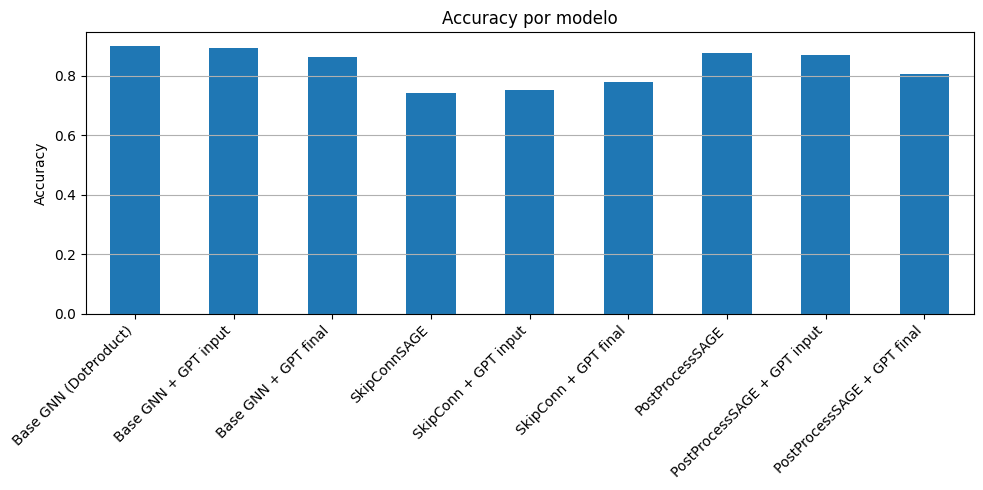

In [52]:
import matplotlib.pyplot as plt

df_results["Accuracy"].plot(kind="bar", figsize=(10, 5), title="Accuracy por modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


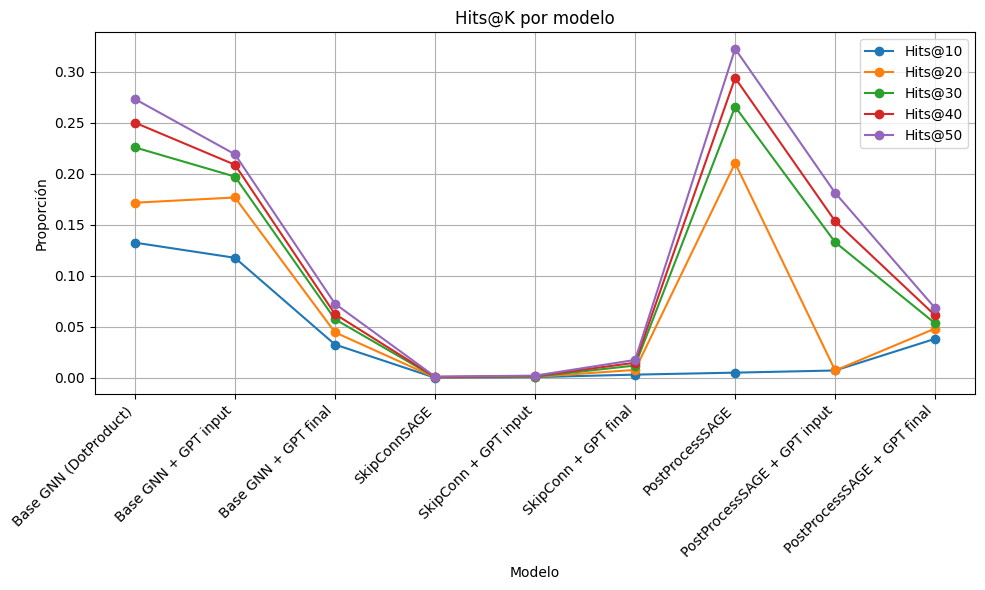

In [53]:
df_results[[f"Hits@{k}" for k in [10, 20, 30, 40, 50]]].plot(kind="line", marker='o', figsize=(10, 6), title="Hits@K por modelo")
plt.ylabel("Proporción")
plt.xlabel("Modelo")
plt.xticks(ticks=range(len(df_results.index)), labels=df_results.index, rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


Alas, skip-connections actually seem to be deterimental for ogbl-ddi. Even reducing the number of GNN layers back down to 7 (or even 5) does not significantly improve performance. An in-depth analysis of what went wrong here can be found in the corresponding Medium post.

In [54]:
from sentence_transformers import SentenceTransformer

# Cargar el modelo BioBERT desde HuggingFace (vía SentenceTransformer o directamente si no está en sbert)
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")

# Obtener el embedding vectorial del texto de entrada
embedding_biobert = model.encode(gpt_response_text)

print("Dimensión del embedding:", embedding_biobert.shape)
print("Primeros valores:", embedding_biobert[:10])


Dimensión del embedding: (768,)
Primeros valores: [ 0.6069926  -0.44180122  0.22789395 -0.34092522  0.05965592  0.04752173
 -0.34843522  0.04692824  0.38924545 -0.32274452]


In [55]:

model = SAGE(
    in_channels=1,  
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_base_biobert = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔬 Resultados SAGE base sin GPT (con BioBERT):")
for k, v in results_base_biobert.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6758
Epoch 1 has loss 10.2484
Epoch 2 has loss 9.346
Epoch 3 has loss 8.4555
Epoch 4 has loss 7.7995
Epoch 5 has loss 7.496
Epoch 6 has loss 7.6758
Epoch 7 has loss 7.4649
Epoch 8 has loss 7.2211
Epoch 9 has loss 6.9457
Epoch 10 has loss 6.8602
Epoch 11 has loss 6.5053
Epoch 12 has loss 6.2172
Epoch 13 has loss 5.9493
Epoch 14 has loss 5.8689
Epoch 15 has loss 5.7629
Epoch 16 has loss 5.7132
Epoch 17 has loss 5.6767
Epoch 18 has loss 5.5575
Epoch 19 has loss 5.5127
Epoch 20 has loss 5.8133
Epoch 21 has loss 5.5548
Epoch 22 has loss 5.489
Epoch 23 has loss 5.4425
Epoch 24 has loss 5.3206
Epoch 25 has loss 5.3
Epoch 26 has loss 5.3115
Epoch 27 has loss 5.3032
Epoch 28 has loss 5.1227
Epoch 29 has loss 5.1574
Epoch 30 has loss 4.944
Epoch 31 has loss 4.8214
Epoch 32 has loss 4.8476
Epoch 33 has loss 4.8173
Epoch 34 has loss 4.6459
Epoch 35 has loss 4.7188
Epoch 36 has loss 4.561
Epoch 37 has loss 4.5498
Epoch 38 has loss 4.5124
Epoch 39 has loss 4.4583
Epoch 40 has los

In [56]:

embedding_biobert_tensor = torch.tensor(embedding_biobert, device=device)
aug_emb_bio = torch.cat([
    emb, embedding_biobert_tensor.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = SAGE(
    in_channels=aug_emb_bio.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_bio, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_bio_input = test(model, predictor, aug_emb_bio, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SAGE (con BioBERT como input):")
for k, v in results_bio_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.1419
Epoch 1 has loss 9.9805
Epoch 2 has loss 9.2631
Epoch 3 has loss 8.5002
Epoch 4 has loss 7.9327
Epoch 5 has loss 7.6998
Epoch 6 has loss 7.5019
Epoch 7 has loss 7.3797
Epoch 8 has loss 7.3821
Epoch 9 has loss 7.1618
Epoch 10 has loss 7.0738
Epoch 11 has loss 6.682
Epoch 12 has loss 6.6539
Epoch 13 has loss 6.4763
Epoch 14 has loss 6.4001
Epoch 15 has loss 6.2973
Epoch 16 has loss 6.1589
Epoch 17 has loss 6.0592
Epoch 18 has loss 5.664
Epoch 19 has loss 5.3992
Epoch 20 has loss 5.298
Epoch 21 has loss 5.1699
Epoch 22 has loss 5.1606
Epoch 23 has loss 4.9751
Epoch 24 has loss 4.8983
Epoch 25 has loss 4.8032
Epoch 26 has loss 4.8099
Epoch 27 has loss 4.6616
Epoch 28 has loss 4.4989
Epoch 29 has loss 4.4298
Epoch 30 has loss 4.4121
Epoch 31 has loss 4.362
Epoch 32 has loss 4.2281
Epoch 33 has loss 4.0974
Epoch 34 has loss 4.0473
Epoch 35 has loss 4.0645
Epoch 36 has loss 3.8751
Epoch 37 has loss 3.7712
Epoch 38 has loss 3.7895
Epoch 39 has loss 3.9225
Epoch 40 has 

In [57]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_bio_final = model(emb, adj_t)

from torch.utils.data import DataLoader, TensorDataset

predictor_bio_final = NeuralLinkPredictorWithGPT(
    in_channels=z_bio_final.size(1),
    hidden_channels=z_bio_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor.shape[0]
).to(device)
predictor_bio_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_bio_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_bio_final.train()

for epoch in range(50):
    total_loss = 0
    # Positivos
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    # Negativos
    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    # Concatenamos
    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    # Entrenamiento en batches
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_bio_final(
            z_bio_final[edge[0]], z_bio_final[edge[1]],
            embedding_biobert_tensor.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")


wrapped_predictor_bio = WrappedPredictor(predictor_bio_final, embedding_biobert_tensor)
dummy_model = DummyModel()

results_bio_final = test(dummy_model, wrapped_predictor_bio, z_bio_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SAGE (con BioBERT en la capa final):")
for k, v in results_bio_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.5324
Epoch 1 has loss 10.2771
Epoch 2 has loss 10.171
Epoch 3 has loss 10.102
Epoch 4 has loss 9.9966
Epoch 5 has loss 9.8709
Epoch 6 has loss 9.7571
Epoch 7 has loss 9.8073
Epoch 8 has loss 9.6425
Epoch 9 has loss 9.7626
Epoch 10 has loss 9.6055
Epoch 11 has loss 9.5406
Epoch 12 has loss 9.5159
Epoch 13 has loss 9.4801
Epoch 14 has loss 9.4788
Epoch 15 has loss 9.4953
Epoch 16 has loss 9.4763
Epoch 17 has loss 9.4783
Epoch 18 has loss 9.4606
Epoch 19 has loss 9.4503
Epoch 20 has loss 9.4606
Epoch 21 has loss 9.44
Epoch 22 has loss 9.4419
Epoch 23 has loss 9.4633
Epoch 24 has loss 9.4305
Epoch 25 has loss 9.4431
Epoch 26 has loss 9.4483
Epoch 27 has loss 9.4356
Epoch 28 has loss 9.4212
Epoch 29 has loss 9.4063
Epoch 30 has loss 9.4325
Epoch 31 has loss 9.4183
Epoch 32 has loss 9.3961
Epoch 33 has loss 9.4366
Epoch 34 has loss 9.4393
Epoch 35 has loss 9.4154
Epoch 36 has loss 9.404
Epoch 37 has loss 9.4197
Epoch 38 has loss 9.4016
Epoch 39 has loss 9.3969
Epoch 40 ha

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as display

# Definimos todos los resultados con su configuración
model_results = [
    # SAGEConv
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sage},
    {"Model": "SAGEConv", "Embedding Source": "classic + GPT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sage_input},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + GPT", "Epochs": 50, **results_sage_final},

    # SkipConnSAGE
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 100, **results_skipconn},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + GPT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 100, **results_skipconn_gpt_input},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + GPT", "Epochs": 100, **results_skipconn_gpt_final},

    # PostProcessSAGE
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_base},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + GPT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_gpt_input},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + GPT", "Epochs": 50, **results_post_gpt_final},

    # BioBERT (SAGEConv con variantes)
    {"Model": "SAGEConv", "Embedding Source": "classic ", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_base_biobert},
    {"Model": "SAGEConv", "Embedding Source": "classic + BioBERT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_bio_input},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_bio_final},
]

df_summary = pd.DataFrame(model_results)
column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

# Mostramos la tabla final
display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,default,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,default,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,default,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,default,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,default,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,default,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070
9,SAGEConv,classic,-,-,Neural,50,0.112204,0.156620,0.191394,0.222917,0.243204,0.9000


In [59]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_bio_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SkipConnSAGE (sin BioBERT):")
for k, v in results_skipconn_bio_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.4048
Epoch 1 has loss 10.5245
Epoch 2 has loss 10.1552
Epoch 3 has loss 10.3725
Epoch 4 has loss 10.0459
Epoch 5 has loss 9.8668
Epoch 6 has loss 10.0747
Epoch 7 has loss 9.8839
Epoch 8 has loss 9.9537
Epoch 9 has loss 9.816
Epoch 10 has loss 9.5504
Epoch 11 has loss 9.159
Epoch 12 has loss 9.9386
Epoch 13 has loss 9.6605
Epoch 14 has loss 9.6453
Epoch 15 has loss 9.5424
Epoch 16 has loss 9.2122
Epoch 17 has loss 9.5701
Epoch 18 has loss 9.0825
Epoch 19 has loss 9.0193
Epoch 20 has loss 9.085
Epoch 21 has loss 8.666
Epoch 22 has loss 9.1183
Epoch 23 has loss 8.9205
Epoch 24 has loss 8.5939
Epoch 25 has loss 8.355
Epoch 26 has loss 8.6509
Epoch 27 has loss 8.6483
Epoch 28 has loss 8.3952
Epoch 29 has loss 8.9823
Epoch 30 has loss 9.255
Epoch 31 has loss 8.4263
Epoch 32 has loss 8.5328
Epoch 33 has loss 8.2601
Epoch 34 has loss 8.2693
Epoch 35 has loss 8.7092
Epoch 36 has loss 8.359
Epoch 37 has loss 8.3089
Epoch 38 has loss 8.0569
Epoch 39 has loss 7.7551
Epoch 40 ha

In [60]:
aug_emb_bio = torch.cat([
    emb, embedding_biobert_tensor.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = SkipConnSAGE(
    in_channels=aug_emb_bio.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_bio, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_bio_input = test(model, predictor, aug_emb_bio, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🪄 Resultados SkipConnSAGE (con BioBERT como input):")
for k, v in results_skipconn_bio_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.5807
Epoch 1 has loss 10.9454
Epoch 2 has loss 10.0826
Epoch 3 has loss 9.8859
Epoch 4 has loss 9.8799
Epoch 5 has loss 10.0109
Epoch 6 has loss 9.5643
Epoch 7 has loss 10.1151
Epoch 8 has loss 9.8006
Epoch 9 has loss 9.5733
Epoch 10 has loss 9.4138
Epoch 11 has loss 9.5524
Epoch 12 has loss 9.3276
Epoch 13 has loss 9.1904
Epoch 14 has loss 9.609
Epoch 15 has loss 9.316
Epoch 16 has loss 9.4486
Epoch 17 has loss 9.0489
Epoch 18 has loss 9.1405
Epoch 19 has loss 8.6873
Epoch 20 has loss 9.0539
Epoch 21 has loss 9.2702
Epoch 22 has loss 8.6042
Epoch 23 has loss 8.8779
Epoch 24 has loss 8.5081
Epoch 25 has loss 8.3514
Epoch 26 has loss 8.4835
Epoch 27 has loss 8.3952
Epoch 28 has loss 8.1781
Epoch 29 has loss 8.6251
Epoch 30 has loss 8.3853
Epoch 31 has loss 8.8523
Epoch 32 has loss 8.4804
Epoch 33 has loss 8.8343
Epoch 34 has loss 8.4833
Epoch 35 has loss 8.1281
Epoch 36 has loss 8.1545
Epoch 37 has loss 8.4221
Epoch 38 has loss 7.9987
Epoch 39 has loss 8.1216
Epoch 4

In [61]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_skip_bio = model(emb, adj_t)

predictor_skip_bio_final = NeuralLinkPredictorWithGPT(
    in_channels=z_skip_bio.size(1),
    hidden_channels=z_skip_bio.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor.shape[0]
).to(device)
predictor_skip_bio_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_skip_bio_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_skip_bio_final.train()

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0

    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_skip_bio_final(
            z_skip_bio[edge[0]], z_skip_bio[edge[1]],
            embedding_biobert_tensor.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_skip_bio_final, embedding_biobert_tensor)
dummy_model = DummyModel()

results_skipconn_bio_final = test(dummy_model, wrapped_predictor, z_skip_bio, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SkipConnSAGE (con BioBERT en la capa final):")
for k, v in results_skipconn_bio_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.0259
Epoch 1 has loss 10.7186
Epoch 2 has loss 10.4683
Epoch 3 has loss 10.3888
Epoch 4 has loss 10.3087
Epoch 5 has loss 10.2476
Epoch 6 has loss 10.2204
Epoch 7 has loss 10.2195
Epoch 8 has loss 10.2183
Epoch 9 has loss 10.1878
Epoch 10 has loss 10.1819
Epoch 11 has loss 10.2046
Epoch 12 has loss 10.1849
Epoch 13 has loss 10.1918
Epoch 14 has loss 10.1441
Epoch 15 has loss 10.1177
Epoch 16 has loss 10.0846
Epoch 17 has loss 10.0882
Epoch 18 has loss 10.1193
Epoch 19 has loss 10.1185
Epoch 20 has loss 10.3154
Epoch 21 has loss 10.162
Epoch 22 has loss 10.1684
Epoch 23 has loss 10.1175
Epoch 24 has loss 10.1133
Epoch 25 has loss 10.0739
Epoch 26 has loss 10.0699
Epoch 27 has loss 10.0768
Epoch 28 has loss 10.0517
Epoch 29 has loss 10.0646
Epoch 30 has loss 10.0092
Epoch 31 has loss 10.027
Epoch 32 has loss 10.0295
Epoch 33 has loss 9.9887
Epoch 34 has loss 10.0124
Epoch 35 has loss 9.9892
Epoch 36 has loss 9.9656
Epoch 37 has loss 9.9646
Epoch 38 has loss 9.9844
Epo

In [62]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bio_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📓 Resultados PostProcessSAGE (sin BioBERT):")
for k, v in results_post_bio_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.8695
Epoch 1 has loss 10.8265
Epoch 2 has loss 9.9749
Epoch 3 has loss 11.711
Epoch 4 has loss 9.0982
Epoch 5 has loss 8.3686
Epoch 6 has loss 7.8514
Epoch 7 has loss 7.659
Epoch 8 has loss 7.4897
Epoch 9 has loss 7.6414
Epoch 10 has loss 7.4641
Epoch 11 has loss 7.341
Epoch 12 has loss 7.285
Epoch 13 has loss 7.3236
Epoch 14 has loss 7.3324
Epoch 15 has loss 7.3971
Epoch 16 has loss 7.2546
Epoch 17 has loss 7.1373
Epoch 18 has loss 7.0483
Epoch 19 has loss 6.9065
Epoch 20 has loss 6.792
Epoch 21 has loss 6.9881
Epoch 22 has loss 6.6327
Epoch 23 has loss 6.6723
Epoch 24 has loss 6.4492
Epoch 25 has loss 6.7138
Epoch 26 has loss 6.2846
Epoch 27 has loss 6.2608
Epoch 28 has loss 6.2183
Epoch 29 has loss 5.9952
Epoch 30 has loss 5.8026
Epoch 31 has loss 5.7072
Epoch 32 has loss 5.7101
Epoch 33 has loss 5.6202
Epoch 34 has loss 5.5833
Epoch 35 has loss 5.7023
Epoch 36 has loss 5.3863
Epoch 37 has loss 5.4062
Epoch 38 has loss 5.3902
Epoch 39 has loss 5.4234
Epoch 40 has

In [63]:
# Regenerar el emb por si se sobrescribió
emb = torch.ones(num_nodes, 1).to(device)

model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()  

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

predictor.reset_parameters()  

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bio_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📓 Resultados PostProcessSAGE (sin BioBERT, reentrenado):")
for k, v in results_post_bio_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8342
Epoch 1 has loss 13.09
Epoch 2 has loss 10.4745
Epoch 3 has loss 10.4628
Epoch 4 has loss 10.068
Epoch 5 has loss 35.4546
Epoch 6 has loss 10.0192
Epoch 7 has loss 9.8298
Epoch 8 has loss 9.1753
Epoch 9 has loss 8.3225
Epoch 10 has loss 7.8912
Epoch 11 has loss 7.821
Epoch 12 has loss 7.6369
Epoch 13 has loss 7.6232
Epoch 14 has loss 7.8565
Epoch 15 has loss 7.4041
Epoch 16 has loss 7.1558
Epoch 17 has loss 7.0044
Epoch 18 has loss 7.0641
Epoch 19 has loss 6.713
Epoch 20 has loss 6.5012
Epoch 21 has loss 6.3618
Epoch 22 has loss 6.3443
Epoch 23 has loss 6.2026
Epoch 24 has loss 5.9451
Epoch 25 has loss 5.9232
Epoch 26 has loss 5.6895
Epoch 27 has loss 5.6803
Epoch 28 has loss 5.6371
Epoch 29 has loss 5.5727
Epoch 30 has loss 5.5224
Epoch 31 has loss 5.4869
Epoch 32 has loss 5.4687
Epoch 33 has loss 5.3197
Epoch 34 has loss 5.4211
Epoch 35 has loss 5.4691
Epoch 36 has loss 5.4127
Epoch 37 has loss 5.2827
Epoch 38 has loss 5.2889
Epoch 39 has loss 5.2052
Epoch 40

In [58]:
embedding_biobert_tensor = torch.tensor(embedding_biobert, device=device)
embedding_biobert_tensor = embedding_biobert_tensor / embedding_biobert_tensor.norm()
embedding_biobert_tensor = embedding_biobert_tensor.detach().float().to(device)

aug_emb_bio_post = torch.cat([
    emb, embedding_biobert_tensor.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = PostProcessSAGE(
    in_channels=aug_emb_bio_post.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(
    model, predictor, aug_emb_bio_post, adj_t, split_edge,
    torch.nn.BCELoss(), optimizer, 64 * 1024, 50
)

results_post_bio_input = test(
    model, predictor, aug_emb_bio_post, adj_t,
    split_edge["valid"], eval, 64 * 1024
)

print("\n📘 Resultados PostProcessSAGE (con BioBERT como input):")
for k, v in results_post_bio_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8024
Epoch 1 has loss 16.6352
Epoch 2 has loss 10.2615
Epoch 3 has loss 11.345
Epoch 4 has loss 9.1903
Epoch 5 has loss 8.1748
Epoch 6 has loss 7.8259
Epoch 7 has loss 7.6049
Epoch 8 has loss 7.5049
Epoch 9 has loss 7.501
Epoch 10 has loss 7.4312
Epoch 11 has loss 7.397
Epoch 12 has loss 7.2922
Epoch 13 has loss 7.3325
Epoch 14 has loss 7.2772
Epoch 15 has loss 7.3937
Epoch 16 has loss 7.0988
Epoch 17 has loss 7.5139
Epoch 18 has loss 7.0343
Epoch 19 has loss 6.8265
Epoch 20 has loss 6.4754
Epoch 21 has loss 6.3327
Epoch 22 has loss 6.1009
Epoch 23 has loss 5.9506
Epoch 24 has loss 5.8666
Epoch 25 has loss 5.9029
Epoch 26 has loss 5.8091
Epoch 27 has loss 5.8715
Epoch 28 has loss 5.6569
Epoch 29 has loss 5.6455
Epoch 30 has loss 5.8613
Epoch 31 has loss 5.7412
Epoch 32 has loss 5.6222
Epoch 33 has loss 5.4709
Epoch 34 has loss 5.492
Epoch 35 has loss 5.2643
Epoch 36 has loss 5.4934
Epoch 37 has loss 5.3652
Epoch 38 has loss 5.4021
Epoch 39 has loss 5.2715
Epoch 40 h

In [64]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_post_bio = model(emb, adj_t)

predictor_post_bio_final = NeuralLinkPredictorWithGPT(
    in_channels=z_post_bio.size(1),
    hidden_channels=z_post_bio.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor.shape[0]
).to(device)
predictor_post_bio_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_bio_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_bio_final.train()

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0

    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_bio_final(
            z_post_bio[edge[0]], z_post_bio[edge[1]],
            embedding_biobert_tensor.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_post_bio_final, embedding_biobert_tensor)
dummy_model = DummyModel()

results_post_bio_final = test(dummy_model, wrapped_predictor, z_post_bio, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📙 Resultados PostProcessSAGE (con BioBERT en la capa final):")
for k, v in results_post_bio_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.9695
Epoch 1 has loss 11.7339
Epoch 2 has loss 11.1585
Epoch 3 has loss 10.7572
Epoch 4 has loss 12.2233
Epoch 5 has loss 10.9947
Epoch 6 has loss 10.3464
Epoch 7 has loss 11.5665
Epoch 8 has loss 10.7815
Epoch 9 has loss 9.913
Epoch 10 has loss 9.4589
Epoch 11 has loss 9.4333
Epoch 12 has loss 9.1178
Epoch 13 has loss 9.0144
Epoch 14 has loss 8.9101
Epoch 15 has loss 8.7861
Epoch 16 has loss 8.6069
Epoch 17 has loss 8.6508
Epoch 18 has loss 8.4342
Epoch 19 has loss 8.6566
Epoch 20 has loss 8.8055
Epoch 21 has loss 8.8743
Epoch 22 has loss 8.9786
Epoch 23 has loss 8.8706
Epoch 24 has loss 8.6463
Epoch 25 has loss 8.4592
Epoch 26 has loss 8.4146
Epoch 27 has loss 8.3716
Epoch 28 has loss 8.436
Epoch 29 has loss 8.5487
Epoch 30 has loss 8.3579
Epoch 31 has loss 8.324
Epoch 32 has loss 8.4986
Epoch 33 has loss 8.3513
Epoch 34 has loss 8.2976
Epoch 35 has loss 8.3119
Epoch 36 has loss 8.2402
Epoch 37 has loss 8.2374
Epoch 38 has loss 8.2252
Epoch 39 has loss 8.2202
Epoc

In [67]:
new_rows = [
    # SkipConnSAGE con BioBERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skipconn_bio_base},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + BioBERT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skipconn_bio_input},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_skipconn_bio_final},

    # PostProcessSAGE con BioBERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_bio_base},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + BioBERT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_bio_input},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_post_bio_final},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows)], ignore_index=True)

column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

# Mostramos la tabla actualizada
display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,default,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,default,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,default,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,default,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,default,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,default,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070
9,SAGEConv,classic,-,-,Neural,50,0.112204,0.156620,0.191394,0.222917,0.243204,0.9000


In [68]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_sci_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SAGE (sin SciBERT):")
for k, v in results_sage_sci_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7138
Epoch 1 has loss 10.3959
Epoch 2 has loss 9.6222
Epoch 3 has loss 9.7832
Epoch 4 has loss 8.7808
Epoch 5 has loss 8.3726
Epoch 6 has loss 7.436
Epoch 7 has loss 6.9532
Epoch 8 has loss 6.5721
Epoch 9 has loss 6.2184
Epoch 10 has loss 6.0719
Epoch 11 has loss 6.0029
Epoch 12 has loss 5.815
Epoch 13 has loss 5.9071
Epoch 14 has loss 5.8534
Epoch 15 has loss 5.6508
Epoch 16 has loss 5.6597
Epoch 17 has loss 5.4979
Epoch 18 has loss 5.5011
Epoch 19 has loss 5.4295
Epoch 20 has loss 5.3046
Epoch 21 has loss 5.1396
Epoch 22 has loss 5.1815
Epoch 23 has loss 5.0378
Epoch 24 has loss 4.9868
Epoch 25 has loss 5.0366
Epoch 26 has loss 4.732
Epoch 27 has loss 4.7664
Epoch 28 has loss 4.7142
Epoch 29 has loss 4.6265
Epoch 30 has loss 4.572
Epoch 31 has loss 4.4822
Epoch 32 has loss 4.5512
Epoch 33 has loss 4.7095
Epoch 34 has loss 4.4573
Epoch 35 has loss 4.3366
Epoch 36 has loss 4.4081
Epoch 37 has loss 4.331
Epoch 38 has loss 4.2841
Epoch 39 has loss 4.2302
Epoch 40 has 

In [60]:
from sentence_transformers import SentenceTransformer

# Obtener embedding de SciBERT
model_sci = SentenceTransformer("allenai/scibert_scivocab_uncased")
embedding_scibert = model_sci.encode(gpt_response_text)
embedding_scibert_tensor = torch.tensor(embedding_scibert, device=device)

No sentence-transformers model found with name /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect 

In [69]:

aug_emb_sci = torch.cat([
    emb, embedding_scibert_tensor.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = SAGE(
    in_channels=aug_emb_sci.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_sci, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_sci_input = test(model, predictor, aug_emb_sci, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SAGE (con SciBERT como input):")
for k, v in results_sage_sci_input.items():
    print(f"{k}: {v:.4f}")


No sentence-transformers model found with name /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect 

Epoch 0 has loss 11.5369
Epoch 1 has loss 9.888
Epoch 2 has loss 9.0507
Epoch 3 has loss 7.8869
Epoch 4 has loss 7.667
Epoch 5 has loss 7.5815
Epoch 6 has loss 7.3016
Epoch 7 has loss 7.1731
Epoch 8 has loss 7.1633
Epoch 9 has loss 7.2148
Epoch 10 has loss 7.1557
Epoch 11 has loss 6.8154
Epoch 12 has loss 6.6398
Epoch 13 has loss 6.4346
Epoch 14 has loss 6.7325
Epoch 15 has loss 6.3198
Epoch 16 has loss 6.2475
Epoch 17 has loss 6.2079
Epoch 18 has loss 6.0713
Epoch 19 has loss 5.9529
Epoch 20 has loss 5.6718
Epoch 21 has loss 5.4611
Epoch 22 has loss 5.3965
Epoch 23 has loss 5.1387
Epoch 24 has loss 5.1028
Epoch 25 has loss 4.9966
Epoch 26 has loss 4.9391
Epoch 27 has loss 4.9197
Epoch 28 has loss 4.9132
Epoch 29 has loss 4.9884
Epoch 30 has loss 4.7319
Epoch 31 has loss 4.6229
Epoch 32 has loss 4.6077
Epoch 33 has loss 4.5991
Epoch 34 has loss 4.5365
Epoch 35 has loss 4.4096
Epoch 36 has loss 4.3747
Epoch 37 has loss 4.3338
Epoch 38 has loss 4.5031
Epoch 39 has loss 4.4268
Epoch 40 ha

In [70]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_sci_final = model(emb, adj_t)

predictor_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_sci_final.size(1),
    hidden_channels=z_sci_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor.shape[0]
).to(device)
predictor_sci_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_sci_final.train()

pos_edges = split_edge["train"]["edge"]
pos_labels = torch.ones(pos_edges.size(0), device=device)

neg_edges = split_edge["train"]["edge_neg"]
neg_labels = torch.zeros(neg_edges.size(0), device=device)

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([pos_labels, neg_labels], dim=0)

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]
        optimizer.zero_grad()
        pred = predictor_sci_final(
            z_sci_final[edge[0]], z_sci_final[edge[1]],
            embedding_scibert_tensor.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_sci = WrappedPredictor(predictor_sci_final, embedding_scibert_tensor)
dummy_model = DummyModel()

results_sage_sci_final = test(dummy_model, wrapped_predictor_sci, z_sci_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧠 Resultados SAGE (con SciBERT en capa final):")
for k, v in results_sage_sci_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6364
Epoch 1 has loss 10.2599
Epoch 2 has loss 10.1835
Epoch 3 has loss 10.1702
Epoch 4 has loss 10.0473
Epoch 5 has loss 10.1421
Epoch 6 has loss 10.1072
Epoch 7 has loss 10.0349
Epoch 8 has loss 9.99
Epoch 9 has loss 9.9975
Epoch 10 has loss 9.9669
Epoch 11 has loss 9.7985
Epoch 12 has loss 9.7429
Epoch 13 has loss 9.6376
Epoch 14 has loss 9.5756
Epoch 15 has loss 9.5621
Epoch 16 has loss 9.5465
Epoch 17 has loss 9.5167
Epoch 18 has loss 9.51
Epoch 19 has loss 9.5057
Epoch 20 has loss 9.4874
Epoch 21 has loss 9.4764
Epoch 22 has loss 9.4566
Epoch 23 has loss 9.441
Epoch 24 has loss 9.4404
Epoch 25 has loss 9.4528
Epoch 26 has loss 9.4354
Epoch 27 has loss 9.4416
Epoch 28 has loss 9.4266
Epoch 29 has loss 9.4196
Epoch 30 has loss 9.4241
Epoch 31 has loss 9.4126
Epoch 32 has loss 9.414
Epoch 33 has loss 9.4046
Epoch 34 has loss 9.4107
Epoch 35 has loss 9.4099
Epoch 36 has loss 9.4002
Epoch 37 has loss 9.4033
Epoch 38 has loss 9.4079
Epoch 39 has loss 9.416
Epoch 40 

In [71]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_sci_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔬 Resultados SkipConnSAGE (sin SciBERT):")
for k, v in results_skipconn_sci_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.4306
Epoch 1 has loss 10.8537
Epoch 2 has loss 10.485
Epoch 3 has loss 10.4319
Epoch 4 has loss 9.9027
Epoch 5 has loss 10.1486
Epoch 6 has loss 9.9936
Epoch 7 has loss 9.5037
Epoch 8 has loss 9.3254
Epoch 9 has loss 9.6669
Epoch 10 has loss 9.9132
Epoch 11 has loss 9.822
Epoch 12 has loss 9.6943
Epoch 13 has loss 9.4046
Epoch 14 has loss 9.3556
Epoch 15 has loss 9.2739
Epoch 16 has loss 9.4139
Epoch 17 has loss 9.6909
Epoch 18 has loss 9.3212
Epoch 19 has loss 9.1816
Epoch 20 has loss 8.9714
Epoch 21 has loss 9.2362
Epoch 22 has loss 8.859
Epoch 23 has loss 8.6238
Epoch 24 has loss 9.1073
Epoch 25 has loss 8.6443
Epoch 26 has loss 8.6029
Epoch 27 has loss 8.8393
Epoch 28 has loss 8.4105
Epoch 29 has loss 8.0499
Epoch 30 has loss 8.888
Epoch 31 has loss 8.4494
Epoch 32 has loss 9.0284
Epoch 33 has loss 9.2468
Epoch 34 has loss 8.4208
Epoch 35 has loss 8.4228
Epoch 36 has loss 8.1858
Epoch 37 has loss 8.1428
Epoch 38 has loss 7.8727
Epoch 39 has loss 7.6815
Epoch 40 

In [72]:
aug_emb_sci = torch.cat([
    emb, embedding_scibert_tensor.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = SkipConnSAGE(
    in_channels=aug_emb_sci.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_sci, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_sci_input = test(model, predictor, aug_emb_sci, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SkipConnSAGE (con SciBERT como input):")
for k, v in results_skipconn_sci_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.4102
Epoch 1 has loss 10.2998
Epoch 2 has loss 10.199
Epoch 3 has loss 9.9035
Epoch 4 has loss 9.8973
Epoch 5 has loss 10.2335
Epoch 6 has loss 10.087
Epoch 7 has loss 9.9595
Epoch 8 has loss 10.0971
Epoch 9 has loss 9.9449
Epoch 10 has loss 9.6265
Epoch 11 has loss 9.902
Epoch 12 has loss 10.0125
Epoch 13 has loss 9.9304
Epoch 14 has loss 9.7765
Epoch 15 has loss 9.5029
Epoch 16 has loss 9.4259
Epoch 17 has loss 9.2681
Epoch 18 has loss 9.5873
Epoch 19 has loss 9.0901
Epoch 20 has loss 8.8363
Epoch 21 has loss 8.6796
Epoch 22 has loss 9.0226
Epoch 23 has loss 8.691
Epoch 24 has loss 9.0473
Epoch 25 has loss 8.7563
Epoch 26 has loss 8.7643
Epoch 27 has loss 8.4215
Epoch 28 has loss 8.9582
Epoch 29 has loss 8.7223
Epoch 30 has loss 8.6969
Epoch 31 has loss 8.2491
Epoch 32 has loss 8.7004
Epoch 33 has loss 8.7292
Epoch 34 has loss 8.2548
Epoch 35 has loss 8.2295
Epoch 36 has loss 8.4708
Epoch 37 has loss 8.346
Epoch 38 has loss 8.7355
Epoch 39 has loss 8.2416
Epoch 40

In [73]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_skip_sci = model(emb, adj_t)

predictor_skip_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_skip_sci.size(1),
    hidden_channels=z_skip_sci.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor.shape[0]
).to(device)
predictor_skip_sci_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_skip_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_skip_sci_final.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]
pos_labels = torch.ones(pos_edges.size(0), device=device)
neg_labels = torch.zeros(neg_edges.size(0), device=device)

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([pos_labels, neg_labels], dim=0)

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_skip_sci_final(
            z_skip_sci[edge[0]], z_skip_sci[edge[1]],
            embedding_scibert_tensor.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_skip_sci_final, embedding_scibert_tensor)
dummy_model = DummyModel()

results_skipconn_sci_final = test(dummy_model, wrapped_predictor, z_skip_sci, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SkipConnSAGE (con SciBERT en la capa final):")
for k, v in results_skipconn_sci_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.0671
Epoch 1 has loss 10.6182
Epoch 2 has loss 10.4409
Epoch 3 has loss 10.3505
Epoch 4 has loss 10.2985
Epoch 5 has loss 10.2515
Epoch 6 has loss 10.2276
Epoch 7 has loss 10.236
Epoch 8 has loss 10.2488
Epoch 9 has loss 10.2226
Epoch 10 has loss 10.1539
Epoch 11 has loss 10.1537
Epoch 12 has loss 10.1904
Epoch 13 has loss 10.1576
Epoch 14 has loss 10.1451
Epoch 15 has loss 10.072
Epoch 16 has loss 10.1023
Epoch 17 has loss 10.0729
Epoch 18 has loss 10.0984
Epoch 19 has loss 10.1713
Epoch 20 has loss 10.1152
Epoch 21 has loss 10.0864
Epoch 22 has loss 10.084
Epoch 23 has loss 10.0735
Epoch 24 has loss 10.0434
Epoch 25 has loss 10.0856
Epoch 26 has loss 10.0206
Epoch 27 has loss 10.001
Epoch 28 has loss 10.0181
Epoch 29 has loss 9.9987
Epoch 30 has loss 9.9818
Epoch 31 has loss 9.9613
Epoch 32 has loss 9.9382
Epoch 33 has loss 9.9498
Epoch 34 has loss 10.206
Epoch 35 has loss 10.0414
Epoch 36 has loss 10.0042
Epoch 37 has loss 9.9622
Epoch 38 has loss 9.9334
Epoch 39

In [61]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_sci_base = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE (sin SciBERT):")
for k, v in results_post_sci_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8951
Epoch 1 has loss 12.3414
Epoch 2 has loss 22.7907
Epoch 3 has loss 9.9834
Epoch 4 has loss 9.1353
Epoch 5 has loss 8.3355
Epoch 6 has loss 7.9041
Epoch 7 has loss 7.7195
Epoch 8 has loss 7.6973
Epoch 9 has loss 7.6634
Epoch 10 has loss 7.5237
Epoch 11 has loss 7.5477
Epoch 12 has loss 7.4671
Epoch 13 has loss 7.4684
Epoch 14 has loss 7.352
Epoch 15 has loss 7.3804
Epoch 16 has loss 7.3271
Epoch 17 has loss 7.1546
Epoch 18 has loss 7.0525
Epoch 19 has loss 7.0571
Epoch 20 has loss 6.775
Epoch 21 has loss 6.5071
Epoch 22 has loss 6.4289
Epoch 23 has loss 6.5213
Epoch 24 has loss 6.2117
Epoch 25 has loss 6.2258
Epoch 26 has loss 6.1548
Epoch 27 has loss 5.9279
Epoch 28 has loss 5.7877
Epoch 29 has loss 5.9827
Epoch 30 has loss 5.6616
Epoch 31 has loss 5.5867
Epoch 32 has loss 5.4092
Epoch 33 has loss 5.6029
Epoch 34 has loss 5.9068
Epoch 35 has loss 5.6695
Epoch 36 has loss 5.3378
Epoch 37 has loss 5.3013
Epoch 38 has loss 5.2051
Epoch 39 has loss 4.9972
Epoch 40 

In [75]:
aug_emb_post_sci = torch.cat([
    emb, embedding_scibert_tensor.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = PostProcessSAGE(
    in_channels=aug_emb_post_sci.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_post_sci, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_sci_input = test(model, predictor, aug_emb_post_sci, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📗 Resultados PostProcessSAGE (con SciBERT como input):")
for k, v in results_post_sci_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.1555
Epoch 1 has loss 11.7869
Epoch 2 has loss 11.7469
Epoch 3 has loss 44.2268
Epoch 4 has loss 27.4437
Epoch 5 has loss 9.8128
Epoch 6 has loss 9.3026
Epoch 7 has loss 8.6172
Epoch 8 has loss 8.1866
Epoch 9 has loss 7.8958
Epoch 10 has loss 7.9107
Epoch 11 has loss 7.7402
Epoch 12 has loss 7.4985
Epoch 13 has loss 7.4581
Epoch 14 has loss 7.3765
Epoch 15 has loss 7.3648
Epoch 16 has loss 7.1716
Epoch 17 has loss 6.8144
Epoch 18 has loss 6.8067
Epoch 19 has loss 6.6152
Epoch 20 has loss 6.6694
Epoch 21 has loss 6.4492
Epoch 22 has loss 6.3133
Epoch 23 has loss 6.3504
Epoch 24 has loss 6.4047
Epoch 25 has loss 6.239
Epoch 26 has loss 6.1826
Epoch 27 has loss 5.9732
Epoch 28 has loss 5.7308
Epoch 29 has loss 5.5871
Epoch 30 has loss 5.5359
Epoch 31 has loss 5.4789
Epoch 32 has loss 5.4377
Epoch 33 has loss 5.3242
Epoch 34 has loss 5.2419
Epoch 35 has loss 5.2721
Epoch 36 has loss 5.3706
Epoch 37 has loss 5.1828
Epoch 38 has loss 5.137
Epoch 39 has loss 5.1253
Epoch 4

In [76]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_post_sci = model(emb, adj_t)

predictor_post_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_post_sci.size(1),
    hidden_channels=z_post_sci.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor.shape[0]
).to(device)
predictor_post_sci_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_sci_final.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]
pos_labels = torch.ones(pos_edges.size(0), device=device)
neg_labels = torch.zeros(neg_edges.size(0), device=device)

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([pos_labels, neg_labels], dim=0)

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_sci_final(
            z_post_sci[edge[0]], z_post_sci[edge[1]],
            embedding_scibert_tensor.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_post_sci = WrappedPredictor(predictor_post_sci_final, embedding_scibert_tensor)
dummy_model = DummyModel()

results_post_sci_final = test(dummy_model, wrapped_predictor_post_sci, z_post_sci, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📙 Resultados PostProcessSAGE (con SciBERT en la capa final):")
for k, v in results_post_sci_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.9687
Epoch 1 has loss 11.6965
Epoch 2 has loss 11.1833
Epoch 3 has loss 11.064
Epoch 4 has loss 11.0778
Epoch 5 has loss 11.4885
Epoch 6 has loss 11.4075
Epoch 7 has loss 10.8116
Epoch 8 has loss 10.4377
Epoch 9 has loss 10.3486
Epoch 10 has loss 10.0102
Epoch 11 has loss 9.6015
Epoch 12 has loss 9.2683
Epoch 13 has loss 9.0183
Epoch 14 has loss 8.9251
Epoch 15 has loss 8.8673
Epoch 16 has loss 9.0487
Epoch 17 has loss 9.4705
Epoch 18 has loss 9.19
Epoch 19 has loss 9.0139
Epoch 20 has loss 8.9917
Epoch 21 has loss 8.8013
Epoch 22 has loss 8.7987
Epoch 23 has loss 8.71
Epoch 24 has loss 8.7508
Epoch 25 has loss 8.9065
Epoch 26 has loss 8.6347
Epoch 27 has loss 8.53
Epoch 28 has loss 8.6409
Epoch 29 has loss 8.6552
Epoch 30 has loss 8.5222
Epoch 31 has loss 8.5203
Epoch 32 has loss 8.5647
Epoch 33 has loss 8.9236
Epoch 34 has loss 8.6124
Epoch 35 has loss 8.4505
Epoch 36 has loss 8.3272
Epoch 37 has loss 8.4575
Epoch 38 has loss 8.2564
Epoch 39 has loss 8.3179
Epoch 

In [77]:
# Nuevas filas con resultados de SciBERT
new_rows_scibert = [
    # SAGEConv con SciBERT
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sage_sci_base},
    {"Model": "SAGEConv", "Embedding Source": "classic + SciBERT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sage_sci_input},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_sage_sci_final},

    # SkipConnSAGE con SciBERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skipconn_sci_base},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + SciBERT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skipconn_sci_input},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_skipconn_sci_final},

    # PostProcessSAGE con SciBERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_sci_base},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + SciBERT", "Prompt Type": "default", "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_sci_input},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "default", "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_post_sci_final},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows_scibert)], ignore_index=True)

column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

# Mostrar la tabla final actualizada
display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,default,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,default,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,default,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,default,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,default,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,default,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070
9,SAGEConv,classic,-,-,Neural,50,0.112204,0.156620,0.191394,0.222917,0.243204,0.9000


In [78]:
import openai

client = openai.OpenAI(api_key="sk-...")

# Prompting enfocado en razonamiento sobre enlaces
response_v2 = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant specialized in graph-based machine learning."
        },
        {
            "role": "user",
            "content": """
You are an AI system specialized in biomedical knowledge graphs.

You are analyzing a drug–drug interaction network in which:
- Nodes represent drugs.
- Edges represent known interactions between drugs.
- The network has no node features; only structure is available.
- The average node is connected to around 500 others.

Your goal is to infer whether a new interaction (edge) should exist between two given drugs, based only on the network's topology and global interaction patterns.

You are not told the identities of the drugs but only the graph structure.

Please simulate your reasoning process by answering:

1. What kind of graph neighborhoods, motifs, or topological similarities would lead you to believe a link is likely?
2. What are some failure cases, ambiguities, or limitations in predicting links from such a topology-only graph?
3. If you had to score pairs of nodes, how would you combine topological evidence with hypothetical latent semantic relationships?

This output will be transformed into an embedding and used as additional semantic input to enhance the performance of a graph neural network for link prediction.
"""
        }
    ],
    temperature=0.7
)

print("=== GPT Response v2 ===\n")
print(response_v2.choices[0].message.content)


=== GPT Response v2 ===

1. In a drug–drug interaction network, certain graph neighborhoods and motifs can indicate a higher likelihood of a link between two drugs. For example:
   - **Common neighbors**: If two drugs share many common neighbors, it suggests a potential interaction between them, as drugs that interact often do so with similar sets of other drugs.
   - **Structural holes**: Nodes that bridge different communities in the network may indicate a potential interaction between drugs from these separate communities.
   - **Network motifs**: Specific patterns of interactions, such as feed-forward loops or bipartite structures, can also provide insights into potential interactions.

2. Some failure cases, ambiguities, and limitations in predicting links from a topology-only graph include:
   - **Sparsity**: If the network is sparse or lacks certain connections, it may be challenging to infer new interactions accurately.
   - **Missing information**: Without additional features 

In [79]:
gpt_response_v2 = response_v2.choices[0].message.content

with open("gpt_ddi_reasoning_run2.txt", "w", encoding="utf-8") as f:
    f.write(gpt_response_v2)

print("✅ Respuesta v2 guardada en 'gpt_ddi_reasoning_run2.txt'")


✅ Respuesta v2 guardada en 'gpt_ddi_reasoning_run2.txt'


In [63]:
from sentence_transformers import SentenceTransformer

# Leer el nuevo archivo
with open("gpt_ddi_reasoning_run2.txt", "r", encoding="utf-8") as f:
    gpt_response_text_v2 = f.read()

# Usamos el mismo modelo SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

embedding_v2 = model.encode(gpt_response_text_v2)

print("Dimensión del nuevo embedding:", embedding_v2.shape)
print("Primeros valores:", embedding_v2[:10])


Dimensión del nuevo embedding: (384,)
Primeros valores: [ 0.02924465 -0.07621226 -0.05022812  0.00279903  0.06210268 -0.01504837
 -0.04575742  0.04615958  0.04283014 -0.09850551]


In [81]:
import numpy as np

np.save("gpt_ddi_embedding_v2_run2.npy", embedding_v2)
print("✅ Embedding v2 guardado en 'gpt_ddi_embedding_v2_run2.npy'")

✅ Embedding v2 guardado en 'gpt_ddi_embedding_v2_run2.npy'


In [64]:
embedding_global_v2 = np.load("gpt_ddi_embedding_v2_run2.npy")
embedding_global_v2 = torch.tensor(embedding_global_v2, dtype=torch.float32).to(device)


In [65]:
aug_emb_v2 = torch.cat([emb, embedding_global_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

In [84]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=0.01)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_base_v2 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SAGEConv (base, v2):")
for k, v in results_sage_base_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6336
Epoch 1 has loss 10.1175
Epoch 2 has loss 9.3894
Epoch 3 has loss 8.7749
Epoch 4 has loss 7.9447
Epoch 5 has loss 7.6697
Epoch 6 has loss 7.5028
Epoch 7 has loss 7.4545
Epoch 8 has loss 7.2946
Epoch 9 has loss 7.143
Epoch 10 has loss 6.9733
Epoch 11 has loss 6.7042
Epoch 12 has loss 6.584
Epoch 13 has loss 6.5814
Epoch 14 has loss 6.4333
Epoch 15 has loss 6.1419
Epoch 16 has loss 6.0217
Epoch 17 has loss 5.9121
Epoch 18 has loss 5.5398
Epoch 19 has loss 5.3858
Epoch 20 has loss 5.3622
Epoch 21 has loss 5.2169
Epoch 22 has loss 5.1416
Epoch 23 has loss 5.1575
Epoch 24 has loss 5.0103
Epoch 25 has loss 5.0047
Epoch 26 has loss 5.0013
Epoch 27 has loss 4.9645
Epoch 28 has loss 4.9223
Epoch 29 has loss 4.9786
Epoch 30 has loss 4.9529
Epoch 31 has loss 4.8061
Epoch 32 has loss 4.8476
Epoch 33 has loss 4.7178
Epoch 34 has loss 4.612
Epoch 35 has loss 4.5719
Epoch 36 has loss 4.5146
Epoch 37 has loss 4.4711
Epoch 38 has loss 4.4948
Epoch 39 has loss 4.4608
Epoch 40 ha

In [85]:
aug_emb_input_v2 = torch.cat([emb, embedding_global_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SAGE(
    in_channels=aug_emb_input_v2.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=0.01)

train(model, predictor, aug_emb_input_v2, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_input_v2 = test(model, predictor, aug_emb_input_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔗 Resultados SAGEConv (con GPT v2 en input):")
for k, v in results_sage_input_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7213
Epoch 1 has loss 9.7553
Epoch 2 has loss 8.8173
Epoch 3 has loss 7.9969
Epoch 4 has loss 7.7476
Epoch 5 has loss 7.5818
Epoch 6 has loss 7.4166
Epoch 7 has loss 7.3278
Epoch 8 has loss 7.3408
Epoch 9 has loss 6.831
Epoch 10 has loss 6.4625
Epoch 11 has loss 6.2449
Epoch 12 has loss 6.0891
Epoch 13 has loss 6.0409
Epoch 14 has loss 5.7773
Epoch 15 has loss 5.7082
Epoch 16 has loss 5.616
Epoch 17 has loss 5.5298
Epoch 18 has loss 5.4495
Epoch 19 has loss 5.1922
Epoch 20 has loss 5.3252
Epoch 21 has loss 5.3129
Epoch 22 has loss 5.0506
Epoch 23 has loss 5.0408
Epoch 24 has loss 4.8776
Epoch 25 has loss 4.9305
Epoch 26 has loss 4.8255
Epoch 27 has loss 4.8616
Epoch 28 has loss 4.8658
Epoch 29 has loss 4.7207
Epoch 30 has loss 4.5884
Epoch 31 has loss 4.6147
Epoch 32 has loss 4.6806
Epoch 33 has loss 4.5816
Epoch 34 has loss 4.6563
Epoch 35 has loss 4.4691
Epoch 36 has loss 4.4783
Epoch 37 has loss 4.7238
Epoch 38 has loss 4.6363
Epoch 39 has loss 4.4722
Epoch 40 ha

In [86]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor_dummy = DotProductLinkPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, predictor_dummy, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_v2 = model(emb, adj_t)

predictor_final_v2 = NeuralLinkPredictorWithGPT(
    in_channels=z_v2.size(1),
    hidden_channels=z_v2.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global_v2.shape[0]
).to(device)
predictor_final_v2.reset_parameters()
optimizer = torch.optim.Adam(predictor_final_v2.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_final_v2.train()

for epoch in range(50):
    total_loss = 0

    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_final_v2(
            z_v2[edge[0]], z_v2[edge[1]],
            embedding_global_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_final_v2 = WrappedPredictor(predictor_final_v2, embedding_global_v2)
dummy_model = DummyModel()

results_sage_final_v2 = test(dummy_model, wrapped_predictor_final_v2, z_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv (con GPT v2 en la capa final):")
for k, v in results_sage_final_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.866
Epoch 1 has loss 10.3597
Epoch 2 has loss 10.2031
Epoch 3 has loss 10.1873
Epoch 4 has loss 10.1106
Epoch 5 has loss 10.0101
Epoch 6 has loss 9.8927
Epoch 7 has loss 9.8168
Epoch 8 has loss 9.6948
Epoch 9 has loss 9.7546
Epoch 10 has loss 9.6262
Epoch 11 has loss 9.5414
Epoch 12 has loss 9.5098
Epoch 13 has loss 9.4852
Epoch 14 has loss 9.4888
Epoch 15 has loss 9.4902
Epoch 16 has loss 9.4898
Epoch 17 has loss 9.459
Epoch 18 has loss 9.4434
Epoch 19 has loss 9.4772
Epoch 20 has loss 9.4776
Epoch 21 has loss 9.443
Epoch 22 has loss 9.4271
Epoch 23 has loss 9.4537
Epoch 24 has loss 9.4307
Epoch 25 has loss 9.4176
Epoch 26 has loss 9.4214
Epoch 27 has loss 9.4274
Epoch 28 has loss 9.4105
Epoch 29 has loss 9.398
Epoch 30 has loss 9.4108
Epoch 31 has loss 9.4188
Epoch 32 has loss 9.4088
Epoch 33 has loss 9.4283
Epoch 34 has loss 9.424
Epoch 35 has loss 9.4079
Epoch 36 has loss 9.4075
Epoch 37 has loss 9.4139
Epoch 38 has loss 9.418
Epoch 39 has loss 9.4096
Epoch 40 h

In [87]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_base_v2 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SkipConnSAGE (sin embedding v2):")
for k, v in results_skip_base_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7471
Epoch 1 has loss 10.3789
Epoch 2 has loss 10.217
Epoch 3 has loss 10.0863
Epoch 4 has loss 10.0258
Epoch 5 has loss 10.1268
Epoch 6 has loss 9.7704
Epoch 7 has loss 9.4464
Epoch 8 has loss 9.7165
Epoch 9 has loss 9.5457
Epoch 10 has loss 9.443
Epoch 11 has loss 9.4625
Epoch 12 has loss 9.3834
Epoch 13 has loss 9.698
Epoch 14 has loss 9.4472
Epoch 15 has loss 9.4708
Epoch 16 has loss 9.638
Epoch 17 has loss 9.5099
Epoch 18 has loss 9.7604
Epoch 19 has loss 9.4529
Epoch 20 has loss 9.2179
Epoch 21 has loss 9.5094
Epoch 22 has loss 9.4981
Epoch 23 has loss 9.2492
Epoch 24 has loss 9.1454
Epoch 25 has loss 8.9891
Epoch 26 has loss 9.2478
Epoch 27 has loss 9.5669
Epoch 28 has loss 8.8337
Epoch 29 has loss 8.773
Epoch 30 has loss 8.8425
Epoch 31 has loss 8.8886
Epoch 32 has loss 9.0055
Epoch 33 has loss 8.9295
Epoch 34 has loss 8.9394
Epoch 35 has loss 8.932
Epoch 36 has loss 8.8463
Epoch 37 has loss 8.9888
Epoch 38 has loss 8.6921
Epoch 39 has loss 8.6052
Epoch 40 h

In [88]:
aug_emb_v2 = torch.cat([
    emb,
    embedding_global_v2.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = SkipConnSAGE(
    in_channels=aug_emb_v2.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_v2, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_input_v2 = test(model, predictor, aug_emb_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📙 Resultados SkipConnSAGE (embedding v2 como input):")
for k, v in results_skip_input_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.1868
Epoch 1 has loss 10.6427
Epoch 2 has loss 10.1428
Epoch 3 has loss 10.1154
Epoch 4 has loss 10.2889
Epoch 5 has loss 10.0238
Epoch 6 has loss 9.9572
Epoch 7 has loss 9.964
Epoch 8 has loss 10.1003
Epoch 9 has loss 10.4297
Epoch 10 has loss 10.2296
Epoch 11 has loss 9.843
Epoch 12 has loss 9.9156
Epoch 13 has loss 9.8306
Epoch 14 has loss 9.4848
Epoch 15 has loss 9.8151
Epoch 16 has loss 9.7194
Epoch 17 has loss 9.5064
Epoch 18 has loss 9.4477
Epoch 19 has loss 9.3628
Epoch 20 has loss 9.4527
Epoch 21 has loss 9.064
Epoch 22 has loss 9.2273
Epoch 23 has loss 8.9772
Epoch 24 has loss 8.8025
Epoch 25 has loss 9.0225
Epoch 26 has loss 8.9456
Epoch 27 has loss 8.645
Epoch 28 has loss 8.4809
Epoch 29 has loss 8.329
Epoch 30 has loss 8.7405
Epoch 31 has loss 8.2756
Epoch 32 has loss 8.4249
Epoch 33 has loss 8.2638
Epoch 34 has loss 8.2175
Epoch 35 has loss 8.1315
Epoch 36 has loss 7.9278
Epoch 37 has loss 8.1996
Epoch 38 has loss 8.6249
Epoch 39 has loss 8.1006
Epoch 

In [89]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model,DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_skip_v2 = model(emb, adj_t)

predictor = NeuralLinkPredictorWithGPT(
    in_channels=z_skip_v2.size(1),
    hidden_channels=z_skip_v2.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global_v2.shape[0]
).to(device)
predictor.reset_parameters()
optimizer = torch.optim.Adam(predictor.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()

predictor.train()

for epoch in range(50):
    total_loss = 0
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor(
            z_skip_v2[edge[0]], z_skip_v2[edge[1]],
            embedding_global_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor, embedding_global_v2)
dummy_model = DummyModel()

results_skip_final_v2 = test(dummy_model, wrapped_predictor, z_skip_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📗 Resultados SkipConnSAGE (embedding v2 como capa final):")
for k, v in results_skip_final_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.026
Epoch 1 has loss 10.6569
Epoch 2 has loss 10.4236
Epoch 3 has loss 10.3586
Epoch 4 has loss 10.2819
Epoch 5 has loss 10.2171
Epoch 6 has loss 10.2136
Epoch 7 has loss 10.2339
Epoch 8 has loss 10.2276
Epoch 9 has loss 10.1989
Epoch 10 has loss 10.1884
Epoch 11 has loss 10.1785
Epoch 12 has loss 10.1285
Epoch 13 has loss 10.1371
Epoch 14 has loss 10.1612
Epoch 15 has loss 10.129
Epoch 16 has loss 10.0334
Epoch 17 has loss 10.1101
Epoch 18 has loss 10.143
Epoch 19 has loss 10.0771
Epoch 20 has loss 10.0228
Epoch 21 has loss 10.0461
Epoch 22 has loss 10.0375
Epoch 23 has loss 10.0144
Epoch 24 has loss 10.0029
Epoch 25 has loss 9.9939
Epoch 26 has loss 9.9593
Epoch 27 has loss 9.9769
Epoch 28 has loss 9.9993
Epoch 29 has loss 9.942
Epoch 30 has loss 9.9094
Epoch 31 has loss 9.9257
Epoch 32 has loss 9.9673
Epoch 33 has loss 9.8911
Epoch 34 has loss 9.856
Epoch 35 has loss 9.8617
Epoch 36 has loss 9.8326
Epoch 37 has loss 9.7592
Epoch 38 has loss 9.7847
Epoch 39 has lo

In [66]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_base_v2 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE (Prompt V2, sin BERT):")
for k, v in results_post_base_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8196
Epoch 1 has loss 11.7278
Epoch 2 has loss 11.7133
Epoch 3 has loss 10.7738
Epoch 4 has loss 10.3815
Epoch 5 has loss 8.9698
Epoch 6 has loss 8.5448
Epoch 7 has loss 7.8887
Epoch 8 has loss 7.6167
Epoch 9 has loss 7.4938
Epoch 10 has loss 7.4952
Epoch 11 has loss 7.4258
Epoch 12 has loss 7.3971
Epoch 13 has loss 7.3543
Epoch 14 has loss 7.3679
Epoch 15 has loss 7.3188
Epoch 16 has loss 7.2889
Epoch 17 has loss 7.2445
Epoch 18 has loss 7.2897
Epoch 19 has loss 7.3038
Epoch 20 has loss 7.237
Epoch 21 has loss 7.187
Epoch 22 has loss 7.1254
Epoch 23 has loss 6.9556
Epoch 24 has loss 6.7286
Epoch 25 has loss 6.5605
Epoch 26 has loss 6.6083
Epoch 27 has loss 6.3836
Epoch 28 has loss 6.2
Epoch 29 has loss 5.9315
Epoch 30 has loss 5.9108
Epoch 31 has loss 5.7199
Epoch 32 has loss 5.9641
Epoch 33 has loss 5.6457
Epoch 34 has loss 5.6189
Epoch 35 has loss 5.4964
Epoch 36 has loss 5.3952
Epoch 37 has loss 5.5014
Epoch 38 has loss 5.3967
Epoch 39 has loss 5.2969
Epoch 40 h

In [69]:
aug_emb_v2 = torch.cat([emb, embedding_global_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = PostProcessSAGE(
    in_channels=aug_emb_v2.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_v2, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bert_input_v2 = test(model, predictor, aug_emb_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧩 Resultados PostProcessSAGE (Prompt V2, con BERT como input):")
for k, v in results_post_bert_input_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8002
Epoch 1 has loss 13.3926
Epoch 2 has loss 10.9869
Epoch 3 has loss 11.7762
Epoch 4 has loss 9.7303
Epoch 5 has loss 8.8128
Epoch 6 has loss 8.3216
Epoch 7 has loss 7.7494
Epoch 8 has loss 7.5954
Epoch 9 has loss 7.5253
Epoch 10 has loss 7.4813
Epoch 11 has loss 7.4765
Epoch 12 has loss 7.4565
Epoch 13 has loss 7.4334
Epoch 14 has loss 7.4181
Epoch 15 has loss 7.375
Epoch 16 has loss 7.4111
Epoch 17 has loss 7.351
Epoch 18 has loss 7.424
Epoch 19 has loss 7.4106
Epoch 20 has loss 7.373
Epoch 21 has loss 7.3709
Epoch 22 has loss 7.3817
Epoch 23 has loss 7.3778
Epoch 24 has loss 7.5136
Epoch 25 has loss 8.3397
Epoch 26 has loss 9.4346
Epoch 27 has loss 8.1903
Epoch 28 has loss 7.7632
Epoch 29 has loss 7.3803
Epoch 30 has loss 7.3259
Epoch 31 has loss 7.3389
Epoch 32 has loss 7.3713
Epoch 33 has loss 7.2789
Epoch 34 has loss 7.4492
Epoch 35 has loss 7.338
Epoch 36 has loss 7.2411
Epoch 37 has loss 7.2148
Epoch 38 has loss 7.0059
Epoch 39 has loss 6.5193
Epoch 40 ha

In [92]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_post_bert_final = model(emb, adj_t)

predictor_post_bert_final = NeuralLinkPredictorWithGPT(
    in_channels=z_post_bert_final.size(1),
    hidden_channels=z_post_bert_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global_v2.shape[0]
).to(device)
predictor_post_bert_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_bert_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_bert_final.train()

for epoch in range(50):
    total_loss = 0
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in torch.utils.data.DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_bert_final(
            z_post_bert_final[edge[0]], z_post_bert_final[edge[1]],
            embedding_global_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_post_bert_final, embedding_global_v2)
dummy_model = DummyModel()
results_post_bert_final_v2 = test(dummy_model, wrapped_predictor, z_post_bert_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados PostProcessSAGE (Prompt V2, con BERT como señal final):")
for k, v in results_post_bert_final_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8569
Epoch 1 has loss 11.7657
Epoch 2 has loss 11.715
Epoch 3 has loss 11.6204
Epoch 4 has loss 11.0264
Epoch 5 has loss 10.959
Epoch 6 has loss 10.1599
Epoch 7 has loss 9.7465
Epoch 8 has loss 9.4715
Epoch 9 has loss 9.3588
Epoch 10 has loss 9.2665
Epoch 11 has loss 9.2716
Epoch 12 has loss 9.2461
Epoch 13 has loss 9.1843
Epoch 14 has loss 9.1537
Epoch 15 has loss 9.1329
Epoch 16 has loss 9.1097
Epoch 17 has loss 9.1997
Epoch 18 has loss 9.0744
Epoch 19 has loss 8.9933
Epoch 20 has loss 8.7845
Epoch 21 has loss 8.9791
Epoch 22 has loss 8.7174
Epoch 23 has loss 8.5419
Epoch 24 has loss 8.4908
Epoch 25 has loss 8.3668
Epoch 26 has loss 8.644
Epoch 27 has loss 8.3433
Epoch 28 has loss 8.3089
Epoch 29 has loss 8.7658
Epoch 30 has loss 8.8199
Epoch 31 has loss 9.0078
Epoch 32 has loss 8.915
Epoch 33 has loss 8.5449
Epoch 34 has loss 8.6202
Epoch 35 has loss 8.627
Epoch 36 has loss 8.8176
Epoch 37 has loss 8.6883
Epoch 38 has loss 8.558
Epoch 39 has loss 8.5348
Epoch 40 

In [93]:
new_prompt_type = "explicit structural focus"  
new_rows = [
    # SAGEConv + BERT
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sage_base_v2},
    {"Model": "SAGEConv", "Embedding Source": "classic + BERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sage_input_v2},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BERT", "Epochs": 50, **results_sage_final_v2},

    # SkipConnSAGE + BERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skip_base_v2},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + BERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skip_input_v2},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BERT", "Epochs": 50, **results_skip_final_v2},

    # PostProcessSAGE + BERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_base_v2},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + BERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_bert_input_v2},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BERT", "Epochs": 50, **results_post_bert_final_v2},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows)], ignore_index=True)

column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,default,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,default,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,default,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,default,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,default,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,default,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070
9,SAGEConv,classic,-,-,Neural,50,0.112204,0.156620,0.191394,0.222917,0.243204,0.9000


In [94]:
# Reemplazar "default" por "reasoning-based summary"
df_summary["Prompt Type"] = df_summary["Prompt Type"].replace("default", "reasoning-based summary")

display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,reasoning-based summary,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,reasoning-based summary,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,reasoning-based summary,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,reasoning-based summary,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,reasoning-based summary,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,reasoning-based summary,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070
9,SAGEConv,classic,-,-,Neural,50,0.112204,0.156620,0.191394,0.222917,0.243204,0.9000


In [95]:
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")
embedding_biobert_v2 = model.encode(gpt_response_text_v2)
embedding_biobert_tensor_v2 = torch.tensor(embedding_biobert_v2, device=device)

In [96]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_bio_base_v2 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + BioBERT (sin usar el embedding):")
for k, v in results_sage_bio_base_v2.items():
    print(f"{k}: {v:.4f}")

Epoch 0 has loss 11.3602
Epoch 1 has loss 10.2152
Epoch 2 has loss 9.3006
Epoch 3 has loss 8.6122
Epoch 4 has loss 7.833
Epoch 5 has loss 7.472
Epoch 6 has loss 7.3401
Epoch 7 has loss 6.8975
Epoch 8 has loss 6.604
Epoch 9 has loss 6.5535
Epoch 10 has loss 6.3442
Epoch 11 has loss 6.1545
Epoch 12 has loss 5.9042
Epoch 13 has loss 5.7567
Epoch 14 has loss 5.8152
Epoch 15 has loss 5.618
Epoch 16 has loss 5.5368
Epoch 17 has loss 5.4513
Epoch 18 has loss 5.4516
Epoch 19 has loss 5.2735
Epoch 20 has loss 5.3038
Epoch 21 has loss 5.2258
Epoch 22 has loss 5.0937
Epoch 23 has loss 5.1145
Epoch 24 has loss 4.8114
Epoch 25 has loss 4.8206
Epoch 26 has loss 4.6721
Epoch 27 has loss 4.7441
Epoch 28 has loss 4.6076
Epoch 29 has loss 4.6443
Epoch 30 has loss 4.6886
Epoch 31 has loss 4.6485
Epoch 32 has loss 4.6251
Epoch 33 has loss 4.518
Epoch 34 has loss 4.409
Epoch 35 has loss 4.3833
Epoch 36 has loss 4.3701
Epoch 37 has loss 4.5753
Epoch 38 has loss 4.5274
Epoch 39 has loss 4.32
Epoch 40 has los

In [97]:
aug_emb = torch.cat([emb, embedding_biobert_tensor_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SAGE(
    in_channels=aug_emb.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_bio_input_v2 = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SAGEConv + BioBERT (como input):")
for k, v in results_sage_bio_input_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.5807
Epoch 1 has loss 9.4797
Epoch 2 has loss 8.3278
Epoch 3 has loss 7.8243
Epoch 4 has loss 7.5599
Epoch 5 has loss 7.4725
Epoch 6 has loss 7.4116
Epoch 7 has loss 7.3509
Epoch 8 has loss 7.3309
Epoch 9 has loss 7.101
Epoch 10 has loss 7.0613
Epoch 11 has loss 7.1333
Epoch 12 has loss 6.966
Epoch 13 has loss 6.9025
Epoch 14 has loss 6.5779
Epoch 15 has loss 6.3644
Epoch 16 has loss 6.7048
Epoch 17 has loss 6.1828
Epoch 18 has loss 6.257
Epoch 19 has loss 5.9155
Epoch 20 has loss 5.6635
Epoch 21 has loss 5.5502
Epoch 22 has loss 5.5252
Epoch 23 has loss 5.2419
Epoch 24 has loss 5.2537
Epoch 25 has loss 5.3084
Epoch 26 has loss 5.1734
Epoch 27 has loss 5.0416
Epoch 28 has loss 4.9995
Epoch 29 has loss 4.8679
Epoch 30 has loss 4.92
Epoch 31 has loss 4.7152
Epoch 32 has loss 4.7327
Epoch 33 has loss 4.7202
Epoch 34 has loss 4.5247
Epoch 35 has loss 4.5424
Epoch 36 has loss 4.5374
Epoch 37 has loss 4.5472
Epoch 38 has loss 4.4999
Epoch 39 has loss 4.4646
Epoch 40 has l

In [98]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_bio_final = model(emb, adj_t)

predictor_bio_final = NeuralLinkPredictorWithGPT(
    in_channels=z_bio_final.size(1),
    hidden_channels=z_bio_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor_v2.shape[0]
).to(device)
predictor_bio_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_bio_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_bio_final.train()

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_bio_final(
            z_bio_final[edge[0]], z_bio_final[edge[1]],
            embedding_biobert_tensor_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_bio = WrappedPredictor(predictor_bio_final, embedding_biobert_tensor_v2)
dummy_model = DummyModel()

results_sage_bio_final_v2 = test(dummy_model, wrapped_predictor_bio, z_bio_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔬 Resultados SAGEConv + BioBERT (en predictor final):")
for k, v in results_sage_bio_final_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6676
Epoch 1 has loss 10.2833
Epoch 2 has loss 10.2035
Epoch 3 has loss 10.1277
Epoch 4 has loss 10.0444
Epoch 5 has loss 10.0566
Epoch 6 has loss 9.9866
Epoch 7 has loss 10.0045
Epoch 8 has loss 9.9936
Epoch 9 has loss 9.9102
Epoch 10 has loss 9.8015
Epoch 11 has loss 9.7172
Epoch 12 has loss 9.6379
Epoch 13 has loss 9.7298
Epoch 14 has loss 9.656
Epoch 15 has loss 9.5586
Epoch 16 has loss 9.5471
Epoch 17 has loss 9.5184
Epoch 18 has loss 9.5105
Epoch 19 has loss 9.4992
Epoch 20 has loss 9.4914
Epoch 21 has loss 9.4866
Epoch 22 has loss 9.4896
Epoch 23 has loss 9.4904
Epoch 24 has loss 9.4933
Epoch 25 has loss 9.4883
Epoch 26 has loss 9.4876
Epoch 27 has loss 9.4796
Epoch 28 has loss 9.4792
Epoch 29 has loss 9.4762
Epoch 30 has loss 9.4696
Epoch 31 has loss 9.4675
Epoch 32 has loss 9.463
Epoch 33 has loss 9.468
Epoch 34 has loss 9.4551
Epoch 35 has loss 9.4551
Epoch 36 has loss 9.4571
Epoch 37 has loss 9.4579
Epoch 38 has loss 9.4568
Epoch 39 has loss 9.4662
Epoch 

In [99]:
model = SkipConnSAGE(
    in_channels=emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_bio_base_v2 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SkipConnSAGE + BioBERT (sin GPT):")
for k, v in results_skipconn_bio_base_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.3468
Epoch 1 has loss 10.3554
Epoch 2 has loss 10.477
Epoch 3 has loss 10.3148
Epoch 4 has loss 9.8027
Epoch 5 has loss 9.7982
Epoch 6 has loss 9.5361
Epoch 7 has loss 9.4751
Epoch 8 has loss 9.7395
Epoch 9 has loss 9.8663
Epoch 10 has loss 9.5899
Epoch 11 has loss 10.0494
Epoch 12 has loss 9.9707
Epoch 13 has loss 9.6028
Epoch 14 has loss 9.5158
Epoch 15 has loss 9.3354
Epoch 16 has loss 9.0473
Epoch 17 has loss 8.7915
Epoch 18 has loss 8.9424
Epoch 19 has loss 8.7509
Epoch 20 has loss 8.7322
Epoch 21 has loss 8.4511
Epoch 22 has loss 8.6897
Epoch 23 has loss 8.3117
Epoch 24 has loss 8.7723
Epoch 25 has loss 8.2927
Epoch 26 has loss 8.0909
Epoch 27 has loss 8.1039
Epoch 28 has loss 7.8625
Epoch 29 has loss 8.2114
Epoch 30 has loss 8.1853
Epoch 31 has loss 7.9279
Epoch 32 has loss 7.8679
Epoch 33 has loss 7.7797
Epoch 34 has loss 7.8713
Epoch 35 has loss 8.4732
Epoch 36 has loss 7.9562
Epoch 37 has loss 7.6644
Epoch 38 has loss 7.9799
Epoch 39 has loss 7.7267
Epoch 

In [100]:
aug_emb = torch.cat([emb, embedding_biobert_tensor_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SkipConnSAGE(
    in_channels=aug_emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_bio_input_v2 = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SkipConnSAGE + BioBERT (como input):")
for k, v in results_skipconn_bio_input_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.6055
Epoch 1 has loss 10.5495
Epoch 2 has loss 10.1899
Epoch 3 has loss 10.8724
Epoch 4 has loss 10.1854
Epoch 5 has loss 9.9562
Epoch 6 has loss 9.7775
Epoch 7 has loss 9.679
Epoch 8 has loss 9.5908
Epoch 9 has loss 9.3264
Epoch 10 has loss 9.3449
Epoch 11 has loss 9.1661
Epoch 12 has loss 9.3366
Epoch 13 has loss 9.3057
Epoch 14 has loss 9.118
Epoch 15 has loss 8.974
Epoch 16 has loss 8.9894
Epoch 17 has loss 8.7126
Epoch 18 has loss 8.7507
Epoch 19 has loss 8.5267
Epoch 20 has loss 8.4192
Epoch 21 has loss 8.6055
Epoch 22 has loss 8.2399
Epoch 23 has loss 8.289
Epoch 24 has loss 8.0567
Epoch 25 has loss 8.4096
Epoch 26 has loss 8.1654
Epoch 27 has loss 8.117
Epoch 28 has loss 8.2671
Epoch 29 has loss 7.9805
Epoch 30 has loss 7.9338
Epoch 31 has loss 7.7648
Epoch 32 has loss 8.2225
Epoch 33 has loss 8.1999
Epoch 34 has loss 7.6327
Epoch 35 has loss 7.1542
Epoch 36 has loss 7.0833
Epoch 37 has loss 6.9841
Epoch 38 has loss 7.0336
Epoch 39 has loss 6.6504
Epoch 40 h

In [101]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_skipconn_bio_v2 = model(emb, adj_t)

predictor_skipconn_bio_final_v2 = NeuralLinkPredictorWithGPT(
    in_channels=z_skipconn_bio_v2.size(1),
    hidden_channels=z_skipconn_bio_v2.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor_v2.shape[0]
).to(device)
predictor_skipconn_bio_final_v2.reset_parameters()
optimizer = torch.optim.Adam(predictor_skipconn_bio_final_v2.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_skipconn_bio_final_v2.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_skipconn_bio_final_v2(
            z_skipconn_bio_v2[edge[0]], z_skipconn_bio_v2[edge[1]],
            embedding_biobert_tensor_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_skipconn_bio_final_v2, embedding_biobert_tensor_v2)
dummy_model = DummyModel()

results_skipconn_bio_final_v2 = test(dummy_model, wrapped_predictor, z_skipconn_bio_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SkipConnSAGE + BioBERT (GPT final):")
for k, v in results_skipconn_bio_final_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.1904
Epoch 1 has loss 10.7059
Epoch 2 has loss 10.5329
Epoch 3 has loss 10.4003
Epoch 4 has loss 10.3569
Epoch 5 has loss 10.255
Epoch 6 has loss 10.2559
Epoch 7 has loss 10.2394
Epoch 8 has loss 10.1865
Epoch 9 has loss 10.1703
Epoch 10 has loss 10.2028
Epoch 11 has loss 10.1321
Epoch 12 has loss 10.1578
Epoch 13 has loss 10.1555
Epoch 14 has loss 10.1048
Epoch 15 has loss 10.1065
Epoch 16 has loss 10.0907
Epoch 17 has loss 10.0936
Epoch 18 has loss 10.1351
Epoch 19 has loss 10.1386
Epoch 20 has loss 10.0894
Epoch 21 has loss 10.0906
Epoch 22 has loss 10.053
Epoch 23 has loss 10.0175
Epoch 24 has loss 10.3263
Epoch 25 has loss 10.1932
Epoch 26 has loss 10.148
Epoch 27 has loss 10.0999
Epoch 28 has loss 10.0803
Epoch 29 has loss 10.0748
Epoch 30 has loss 10.0968
Epoch 31 has loss 10.0693
Epoch 32 has loss 10.0246
Epoch 33 has loss 10.0178
Epoch 34 has loss 10.0531
Epoch 35 has loss 10.0105
Epoch 36 has loss 9.9853
Epoch 37 has loss 9.9988
Epoch 38 has loss 10.0323
E

In [102]:
model = PostProcessSAGE(
    in_channels=emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bio_base_v2 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + BioBERT (sin GPT):")
for k, v in results_post_bio_base_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7971
Epoch 1 has loss 12.0706
Epoch 2 has loss 11.8188
Epoch 3 has loss 11.7487
Epoch 4 has loss 10.9309
Epoch 5 has loss 9.9667
Epoch 6 has loss 10.7981
Epoch 7 has loss 9.1702
Epoch 8 has loss 8.2028
Epoch 9 has loss 8.1363
Epoch 10 has loss 7.8316
Epoch 11 has loss 7.735
Epoch 12 has loss 7.5862
Epoch 13 has loss 7.5562
Epoch 14 has loss 7.5125
Epoch 15 has loss 7.4267
Epoch 16 has loss 7.3775
Epoch 17 has loss 7.3673
Epoch 18 has loss 7.3839
Epoch 19 has loss 7.3301
Epoch 20 has loss 7.3883
Epoch 21 has loss 7.3257
Epoch 22 has loss 7.3467
Epoch 23 has loss 7.3299
Epoch 24 has loss 7.3572
Epoch 25 has loss 7.3611
Epoch 26 has loss 7.3139
Epoch 27 has loss 7.3491
Epoch 28 has loss 7.2805
Epoch 29 has loss 7.3503
Epoch 30 has loss 7.2998
Epoch 31 has loss 7.2715
Epoch 32 has loss 7.2832
Epoch 33 has loss 7.3162
Epoch 34 has loss 7.2782
Epoch 35 has loss 7.2407
Epoch 36 has loss 7.2414
Epoch 37 has loss 7.212
Epoch 38 has loss 7.4345
Epoch 39 has loss 7.3006
Epoch 

In [103]:
aug_emb = torch.cat([emb, embedding_biobert_tensor_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = PostProcessSAGE(
    in_channels=aug_emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor.reset_parameters()
optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bio_input_v2 = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + BioBERT (como input):")
for k, v in results_post_bio_input_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.9866
Epoch 1 has loss 11.784
Epoch 2 has loss 11.5214
Epoch 3 has loss 10.3969
Epoch 4 has loss 10.0786
Epoch 5 has loss 9.7017
Epoch 6 has loss 9.0015
Epoch 7 has loss 8.6268
Epoch 8 has loss 8.0943
Epoch 9 has loss 7.8493
Epoch 10 has loss 7.6586
Epoch 11 has loss 7.5579
Epoch 12 has loss 7.5006
Epoch 13 has loss 7.5016
Epoch 14 has loss 7.4748
Epoch 15 has loss 7.5635
Epoch 16 has loss 7.4521
Epoch 17 has loss 7.4652
Epoch 18 has loss 6.78
Epoch 19 has loss 6.482
Epoch 20 has loss 6.3545
Epoch 21 has loss 6.2893
Epoch 22 has loss 6.1995
Epoch 23 has loss 6.198
Epoch 24 has loss 5.9243
Epoch 25 has loss 5.9845
Epoch 26 has loss 5.8734
Epoch 27 has loss 5.7931
Epoch 28 has loss 5.7846
Epoch 29 has loss 5.6862
Epoch 30 has loss 5.5398
Epoch 31 has loss 5.6704
Epoch 32 has loss 5.4601
Epoch 33 has loss 5.3799
Epoch 34 has loss 5.4489
Epoch 35 has loss 5.2819
Epoch 36 has loss 5.1536
Epoch 37 has loss 5.2463
Epoch 38 has loss 5.1227
Epoch 39 has loss 5.0656
Epoch 40 h

In [104]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_post_bio_v2 = model(emb, adj_t)

predictor_post_bio_final_v2 = NeuralLinkPredictorWithGPT(
    in_channels=z_post_bio_v2.size(1),
    hidden_channels=z_post_bio_v2.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor_v2.shape[0]
).to(device)
predictor_post_bio_final_v2.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_bio_final_v2.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_bio_final_v2.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_bio_final_v2(
            z_post_bio_v2[edge[0]], z_post_bio_v2[edge[1]],
            embedding_biobert_tensor_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_post_bio_final_v2, embedding_biobert_tensor_v2)
dummy_model = DummyModel()

results_post_bio_final_v2 = test(dummy_model, wrapped_predictor, z_post_bio_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + BioBERT (GPT final):")
for k, v in results_post_bio_final_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.0402
Epoch 1 has loss 11.5205
Epoch 2 has loss 11.0726
Epoch 3 has loss 11.0522
Epoch 4 has loss 10.9624
Epoch 5 has loss 10.4867
Epoch 6 has loss 10.4451
Epoch 7 has loss 10.3507
Epoch 8 has loss 9.8846
Epoch 9 has loss 9.5555
Epoch 10 has loss 9.3898
Epoch 11 has loss 9.3009
Epoch 12 has loss 9.3106
Epoch 13 has loss 9.6554
Epoch 14 has loss 9.7798
Epoch 15 has loss 9.1474
Epoch 16 has loss 8.942
Epoch 17 has loss 8.8527
Epoch 18 has loss 8.9345
Epoch 19 has loss 8.9887
Epoch 20 has loss 8.9573
Epoch 21 has loss 9.0573
Epoch 22 has loss 8.8763
Epoch 23 has loss 9.0014
Epoch 24 has loss 8.7949
Epoch 25 has loss 8.8018
Epoch 26 has loss 8.7468
Epoch 27 has loss 8.6901
Epoch 28 has loss 8.5199
Epoch 29 has loss 8.573
Epoch 30 has loss 8.7126
Epoch 31 has loss 8.6155
Epoch 32 has loss 8.5363
Epoch 33 has loss 8.5174
Epoch 34 has loss 8.4486
Epoch 35 has loss 8.4813
Epoch 36 has loss 8.2753
Epoch 37 has loss 8.516
Epoch 38 has loss 8.8815
Epoch 39 has loss 8.5621
Epoch

In [105]:
new_rows = [
    # SAGEConv + BioBERT
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sage_bio_base_v2},
    {"Model": "SAGEConv", "Embedding Source": "classic + BioBERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sage_bio_input_v2},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_sage_bio_final_v2},

    # SkipConnSAGE + BioBERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skipconn_bio_base_v2},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + BioBERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skipconn_bio_input_v2},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_skipconn_bio_final_v2},

    # PostProcessSAGE + BioBERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_bio_base_v2},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + BioBERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_bio_input_v2},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_post_bio_final_v2},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows)], ignore_index=True)

column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,reasoning-based summary,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,reasoning-based summary,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,reasoning-based summary,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,reasoning-based summary,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,reasoning-based summary,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,reasoning-based summary,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070
9,SAGEConv,classic,-,-,Neural,50,0.112204,0.156620,0.191394,0.222917,0.243204,0.9000


In [71]:
from sentence_transformers import SentenceTransformer

# Usamos el mismo modelo que en la primera iteración para SciBERT
model_sci = SentenceTransformer("allenai/scibert_scivocab_uncased")

embedding_scibert_v2 = model_sci.encode(gpt_response_text_v2)

embedding_scibert_tensor_v2 = torch.tensor(embedding_scibert_v2, device=device)


No sentence-transformers model found with name /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect 

In [107]:
model_sci_base = SAGE(
    in_channels=emb.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_sci_base = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=3,
    dropout=0.5
).to(device)
model_sci_base.reset_parameters()
predictor_sci_base.reset_parameters()
optimizer_sci_base = torch.optim.Adam(
    list(model_sci_base.parameters()) + list(predictor_sci_base.parameters()), lr=0.01
)

train(model_sci_base, predictor_sci_base, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer_sci_base, 64 * 1024, 50)

results_sci_base_v2 = test(model_sci_base, predictor_sci_base, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + SciBERT (sin GPT):")
for k, v in results_sci_base_v2.items():
    print(f"{k}: {v:.4f}")

Epoch 0 has loss 11.5137
Epoch 1 has loss 9.3594
Epoch 2 has loss 8.5281
Epoch 3 has loss 7.8336
Epoch 4 has loss 7.4591
Epoch 5 has loss 7.3369
Epoch 6 has loss 7.2692
Epoch 7 has loss 7.3721
Epoch 8 has loss 7.18
Epoch 9 has loss 7.0333
Epoch 10 has loss 6.9283
Epoch 11 has loss 6.5504
Epoch 12 has loss 6.3238
Epoch 13 has loss 6.1861
Epoch 14 has loss 5.9972
Epoch 15 has loss 5.8245
Epoch 16 has loss 5.5918
Epoch 17 has loss 5.6064
Epoch 18 has loss 5.6387
Epoch 19 has loss 5.5774
Epoch 20 has loss 5.4682
Epoch 21 has loss 5.2511
Epoch 22 has loss 5.1148
Epoch 23 has loss 5.0225
Epoch 24 has loss 4.931
Epoch 25 has loss 4.8485
Epoch 26 has loss 4.8932
Epoch 27 has loss 4.9039
Epoch 28 has loss 4.804
Epoch 29 has loss 4.7361
Epoch 30 has loss 4.6841
Epoch 31 has loss 4.5714
Epoch 32 has loss 4.5102
Epoch 33 has loss 4.5831
Epoch 34 has loss 4.5741
Epoch 35 has loss 4.4106
Epoch 36 has loss 4.4647
Epoch 37 has loss 4.3594
Epoch 38 has loss 4.3167
Epoch 39 has loss 4.273
Epoch 40 has l

In [108]:
aug_emb_sci_v2 = torch.cat([
    emb,  
    embedding_scibert_tensor_v2.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model_sci_input = SAGE(
    in_channels=aug_emb_sci_v2.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_sci_input = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model_sci_input.reset_parameters()
predictor_sci_input.reset_parameters()
optimizer_sci_input = torch.optim.Adam(
    list(model_sci_input.parameters()) + list(predictor_sci_input.parameters()), lr=0.01
)

train(model_sci_input, predictor_sci_input, aug_emb_sci_v2, adj_t, split_edge, torch.nn.BCELoss(), optimizer_sci_input, 64 * 1024, 50)

results_sci_input_v2 = test(model_sci_input, predictor_sci_input, aug_emb_sci_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + SciBERT (como input):")
for k, v in results_sci_input_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7326
Epoch 1 has loss 10.5212
Epoch 2 has loss 9.2405
Epoch 3 has loss 8.3597
Epoch 4 has loss 8.0207
Epoch 5 has loss 7.634
Epoch 6 has loss 7.5215
Epoch 7 has loss 7.4061
Epoch 8 has loss 7.2763
Epoch 9 has loss 7.2855
Epoch 10 has loss 6.6877
Epoch 11 has loss 6.3539
Epoch 12 has loss 6.3905
Epoch 13 has loss 6.0089
Epoch 14 has loss 6.0576
Epoch 15 has loss 5.7629
Epoch 16 has loss 5.6254
Epoch 17 has loss 5.5364
Epoch 18 has loss 5.548
Epoch 19 has loss 5.4686
Epoch 20 has loss 5.4267
Epoch 21 has loss 5.3198
Epoch 22 has loss 5.2415
Epoch 23 has loss 5.2179
Epoch 24 has loss 5.1275
Epoch 25 has loss 5.1768
Epoch 26 has loss 5.1999
Epoch 27 has loss 5.1975
Epoch 28 has loss 5.1504
Epoch 29 has loss 5.1112
Epoch 30 has loss 5.0123
Epoch 31 has loss 4.9946
Epoch 32 has loss 4.987
Epoch 33 has loss 4.9627
Epoch 34 has loss 4.8889
Epoch 35 has loss 4.9953
Epoch 36 has loss 4.79
Epoch 37 has loss 4.8366
Epoch 38 has loss 4.7077
Epoch 39 has loss 4.7031
Epoch 40 has 

In [109]:
model_sci_final = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model_sci_final.reset_parameters()
optimizer = torch.optim.Adam(model_sci_final.parameters(), lr=0.01)

train(model_sci_final, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model_sci_final.eval()
with torch.no_grad():
    z_sci_final = model_sci_final(emb, adj_t)

predictor_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_sci_final.size(1),
    hidden_channels=z_sci_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor_v2.shape[0]
).to(device)
predictor_sci_final.reset_parameters()


optimizer = torch.optim.Adam(predictor_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_sci_final.train()  
pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]
edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_sci_final(
            z_sci_final[edge[0]], z_sci_final[edge[1]],
            embedding_scibert_tensor_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_sci_final, embedding_scibert_tensor_v2)
dummy_model = DummyModel()

results_sci_final_v2 = test(dummy_model, wrapped_predictor, z_sci_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + SciBERT (GPT final):")
for k, v in results_sci_final_v2.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.5259
Epoch 1 has loss 10.2604
Epoch 2 has loss 10.2192
Epoch 3 has loss 10.1194
Epoch 4 has loss 10.0236
Epoch 5 has loss 9.9787
Epoch 6 has loss 9.8711
Epoch 7 has loss 9.754
Epoch 8 has loss 9.8979
Epoch 9 has loss 9.7589
Epoch 10 has loss 9.6737
Epoch 11 has loss 9.6416
Epoch 12 has loss 9.603
Epoch 13 has loss 9.6149
Epoch 14 has loss 9.5574
Epoch 15 has loss 9.5982
Epoch 16 has loss 9.5564
Epoch 17 has loss 9.524
Epoch 18 has loss 9.5183
Epoch 19 has loss 9.5009
Epoch 20 has loss 9.4964
Epoch 21 has loss 9.4994
Epoch 22 has loss 9.5099
Epoch 23 has loss 9.4916
Epoch 24 has loss 9.4815
Epoch 25 has loss 9.4749
Epoch 26 has loss 9.4707
Epoch 27 has loss 9.4931
Epoch 28 has loss 9.4662
Epoch 29 has loss 9.4687
Epoch 30 has loss 9.4727
Epoch 31 has loss 9.4511
Epoch 32 has loss 9.4649
Epoch 33 has loss 9.4716
Epoch 34 has loss 9.446
Epoch 35 has loss 9.4441
Epoch 36 has loss 9.444
Epoch 37 has loss 9.4459
Epoch 38 has loss 9.4349
Epoch 39 has loss 9.4439
Epoch 40 h

In [110]:
model_skip_sci_base = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_skip_sci_base = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model_skip_sci_base.reset_parameters()
predictor_skip_sci_base.reset_parameters()
optimizer = torch.optim.Adam(
    list(model_skip_sci_base.parameters()) + list(predictor_skip_sci_base.parameters()), lr=0.01
)

train(model_skip_sci_base, predictor_skip_sci_base, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_sci_base = test(model_skip_sci_base, predictor_skip_sci_base, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SkipConnSAGE + SciBERT (sin GPT):")
for k, v in results_skip_sci_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.3307
Epoch 1 has loss 11.0361
Epoch 2 has loss 10.4995
Epoch 3 has loss 10.0409
Epoch 4 has loss 10.0969
Epoch 5 has loss 9.9179
Epoch 6 has loss 10.0889
Epoch 7 has loss 9.986
Epoch 8 has loss 9.8589
Epoch 9 has loss 10.1138
Epoch 10 has loss 10.0221
Epoch 11 has loss 9.8457
Epoch 12 has loss 9.5974
Epoch 13 has loss 9.2274
Epoch 14 has loss 9.3787
Epoch 15 has loss 8.8769
Epoch 16 has loss 9.1728
Epoch 17 has loss 8.7839
Epoch 18 has loss 8.5294
Epoch 19 has loss 8.8349
Epoch 20 has loss 9.2619
Epoch 21 has loss 8.9334
Epoch 22 has loss 8.5288
Epoch 23 has loss 8.5068
Epoch 24 has loss 8.5836
Epoch 25 has loss 8.3162
Epoch 26 has loss 8.7394
Epoch 27 has loss 8.5863
Epoch 28 has loss 8.2609
Epoch 29 has loss 8.1957
Epoch 30 has loss 8.3181
Epoch 31 has loss 7.8459
Epoch 32 has loss 7.8623
Epoch 33 has loss 8.2244
Epoch 34 has loss 8.0653
Epoch 35 has loss 7.8845
Epoch 36 has loss 7.8207
Epoch 37 has loss 7.8347
Epoch 38 has loss 7.7006
Epoch 39 has loss 7.8222
Epo

In [111]:
aug_emb_sci_v2 = torch.cat([emb, embedding_scibert_tensor_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model_skip_sci_input = SkipConnSAGE(
    in_channels=aug_emb_sci_v2.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_skip_sci_input = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model_skip_sci_input.reset_parameters()
predictor_skip_sci_input.reset_parameters()
optimizer = torch.optim.Adam(
    list(model_skip_sci_input.parameters()) + list(predictor_skip_sci_input.parameters()), lr=0.01
)

train(model_skip_sci_input, predictor_skip_sci_input, aug_emb_sci_v2, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_sci_input = test(model_skip_sci_input, predictor_skip_sci_input, aug_emb_sci_v2, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SkipConnSAGE + SciBERT (GPT como input):")
for k, v in results_skip_sci_input.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.4155
Epoch 1 has loss 10.2346
Epoch 2 has loss 10.7326
Epoch 3 has loss 10.0449
Epoch 4 has loss 9.9782
Epoch 5 has loss 9.6629
Epoch 6 has loss 9.4919
Epoch 7 has loss 10.0674
Epoch 8 has loss 9.939
Epoch 9 has loss 9.6969
Epoch 10 has loss 9.3401
Epoch 11 has loss 9.1587
Epoch 12 has loss 8.9924
Epoch 13 has loss 8.7889
Epoch 14 has loss 8.8377
Epoch 15 has loss 8.6438
Epoch 16 has loss 8.8999
Epoch 17 has loss 8.5529
Epoch 18 has loss 8.6389
Epoch 19 has loss 8.4247
Epoch 20 has loss 8.3958
Epoch 21 has loss 8.4588
Epoch 22 has loss 8.127
Epoch 23 has loss 9.0358
Epoch 24 has loss 8.2871
Epoch 25 has loss 8.2791
Epoch 26 has loss 8.3993
Epoch 27 has loss 7.9595
Epoch 28 has loss 7.8929
Epoch 29 has loss 7.799
Epoch 30 has loss 8.3069
Epoch 31 has loss 7.8915
Epoch 32 has loss 7.7961
Epoch 33 has loss 7.284
Epoch 34 has loss 7.4829
Epoch 35 has loss 6.9839
Epoch 36 has loss 7.3122
Epoch 37 has loss 7.3192
Epoch 38 has loss 6.8257
Epoch 39 has loss 6.798
Epoch 40 h

In [112]:
model_skip_sci_final = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model_skip_sci_final.reset_parameters()
optimizer = torch.optim.Adam(model_skip_sci_final.parameters(), lr=0.01)

train(model_skip_sci_final, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model_skip_sci_final.eval()
with torch.no_grad():
    z_skip_sci_final = model_skip_sci_final(emb, adj_t)

predictor_skip_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_skip_sci_final.size(1),
    hidden_channels=z_skip_sci_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor_v2.shape[0]
).to(device)
predictor_skip_sci_final.reset_parameters()

optimizer = torch.optim.Adam(predictor_skip_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_skip_sci_final.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]
edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_skip_sci_final(
            z_skip_sci_final[edge[0]], z_skip_sci_final[edge[1]],
            embedding_scibert_tensor_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_skip_sci = WrappedPredictor(predictor_skip_sci_final, embedding_scibert_tensor_v2)
dummy_model = DummyModel()

results_skip_sci_final = test(dummy_model, wrapped_predictor_skip_sci, z_skip_sci_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SkipConnSAGE + SciBERT (GPT como final):")
for k, v in results_skip_sci_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.0788
Epoch 1 has loss 10.6518
Epoch 2 has loss 10.4319
Epoch 3 has loss 10.3505
Epoch 4 has loss 10.3942
Epoch 5 has loss 10.3463
Epoch 6 has loss 10.2936
Epoch 7 has loss 10.2494
Epoch 8 has loss 10.2332
Epoch 9 has loss 10.1902
Epoch 10 has loss 10.2103
Epoch 11 has loss 10.1423
Epoch 12 has loss 10.1542
Epoch 13 has loss 10.1649
Epoch 14 has loss 10.169
Epoch 15 has loss 10.1457
Epoch 16 has loss 10.0736
Epoch 17 has loss 10.0668
Epoch 18 has loss 10.0648
Epoch 19 has loss 10.089
Epoch 20 has loss 10.0821
Epoch 21 has loss 10.1736
Epoch 22 has loss 10.1226
Epoch 23 has loss 10.0698
Epoch 24 has loss 10.076
Epoch 25 has loss 10.0864
Epoch 26 has loss 10.0529
Epoch 27 has loss 10.045
Epoch 28 has loss 10.083
Epoch 29 has loss 10.0095
Epoch 30 has loss 9.998
Epoch 31 has loss 10.0143
Epoch 32 has loss 10.0004
Epoch 33 has loss 10.0171
Epoch 34 has loss 9.9857
Epoch 35 has loss 9.9726
Epoch 36 has loss 9.966
Epoch 37 has loss 9.9711
Epoch 38 has loss 9.9094
Epoch 39 

In [113]:
model_post_sci_base = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor_post_sci_base = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model_post_sci_base.reset_parameters()
predictor_post_sci_base.reset_parameters()
optimizer = torch.optim.Adam(
    list(model_post_sci_base.parameters()) + list(predictor_post_sci_base.parameters()), lr=0.01
)

train(model_post_sci_base, predictor_post_sci_base, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_sci_base = test(model_post_sci_base, predictor_post_sci_base, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + SciBERT (sin GPT):")
for k, v in results_post_sci_base.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.856
Epoch 1 has loss 11.8474
Epoch 2 has loss 11.7918
Epoch 3 has loss 11.5791
Epoch 4 has loss 10.9487
Epoch 5 has loss 10.4406
Epoch 6 has loss 10.1643
Epoch 7 has loss 9.4288
Epoch 8 has loss 9.0934
Epoch 9 has loss 8.4463
Epoch 10 has loss 7.8192
Epoch 11 has loss 7.6119
Epoch 12 has loss 7.5439
Epoch 13 has loss 7.4395
Epoch 14 has loss 7.3141
Epoch 15 has loss 7.4917
Epoch 16 has loss 7.1425
Epoch 17 has loss 6.8338
Epoch 18 has loss 6.7387
Epoch 19 has loss 6.5144
Epoch 20 has loss 6.2755
Epoch 21 has loss 6.1411
Epoch 22 has loss 6.2256
Epoch 23 has loss 6.113
Epoch 24 has loss 6.0156
Epoch 25 has loss 5.8987
Epoch 26 has loss 5.8663
Epoch 27 has loss 5.9585
Epoch 28 has loss 5.9178
Epoch 29 has loss 5.9025
Epoch 30 has loss 5.7551
Epoch 31 has loss 5.6687
Epoch 32 has loss 5.7028
Epoch 33 has loss 5.5581
Epoch 34 has loss 5.4909
Epoch 35 has loss 5.5321
Epoch 36 has loss 5.7194
Epoch 37 has loss 5.5842
Epoch 38 has loss 5.4559
Epoch 39 has loss 5.3655
Epoch

In [72]:
emb = torch.ones(num_nodes, 1).to(device)
print("✅ embedding_scibert_tensor_v2[:10]:", embedding_scibert_tensor_v2[:10])
aug_emb_sci_input = torch.cat([emb, embedding_scibert_tensor_v2.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model_post_sci_input = PostProcessSAGE(
    in_channels=aug_emb_sci_input.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)


predictor_post_sci_input = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)
model_post_sci_input.reset_parameters()
predictor_post_sci_input.reset_parameters()

optimizer = torch.optim.Adam(
    list(model_post_sci_input.parameters()) + list(predictor_post_sci_input.parameters()), lr=0.01
)

train(model_post_sci_input, predictor_post_sci_input, aug_emb_sci_input, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_sci_input = test(model_post_sci_input, predictor_post_sci_input, aug_emb_sci_input, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + SciBERT (como input):")
for k, v in results_post_sci_input.items():
    print(f"{k}: {v:.4f}")


✅ embedding_scibert_tensor_v2[:10]: tensor([ 0.0590, -0.5027, -0.0948, -0.0193,  0.2944, -0.1483,  0.1095,  1.0214,
        -0.0039,  0.1579])
Epoch 0 has loss 11.7952
Epoch 1 has loss 12.067
Epoch 2 has loss 10.6492
Epoch 3 has loss 9.7133
Epoch 4 has loss 9.1301
Epoch 5 has loss 8.1834
Epoch 6 has loss 7.7833
Epoch 7 has loss 7.639
Epoch 8 has loss 7.6248
Epoch 9 has loss 7.5129
Epoch 10 has loss 7.4097
Epoch 11 has loss 7.437
Epoch 12 has loss 7.4541
Epoch 13 has loss 7.3265
Epoch 14 has loss 7.5796
Epoch 15 has loss 7.3923
Epoch 16 has loss 7.3384
Epoch 17 has loss 7.5776
Epoch 18 has loss 7.3593
Epoch 19 has loss 7.2915
Epoch 20 has loss 7.2454
Epoch 21 has loss 7.328
Epoch 22 has loss 7.298
Epoch 23 has loss 7.1824
Epoch 24 has loss 6.9158
Epoch 25 has loss 7.0769
Epoch 26 has loss 6.7322
Epoch 27 has loss 6.47
Epoch 28 has loss 6.3778
Epoch 29 has loss 6.1672
Epoch 30 has loss 6.0208
Epoch 31 has loss 6.06
Epoch 32 has loss 5.8317
Epoch 33 has loss 5.7367
Epoch 34 has loss 5.654

In [115]:
model_post_sci_final = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model_post_sci_final.reset_parameters()
optimizer = torch.optim.Adam(model_post_sci_final.parameters(), lr=0.01)

train(model_post_sci_final, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model_post_sci_final.eval()
with torch.no_grad():
    z_post_sci_final = model_post_sci_final(emb, adj_t)

predictor_post_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_post_sci_final.size(1),
    hidden_channels=z_post_sci_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor_v2.shape[0]
).to(device)
predictor_post_sci_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_sci_final.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_sci_final(
            z_post_sci_final[edge[0]], z_post_sci_final[edge[1]],
            embedding_scibert_tensor_v2.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_post_sci = WrappedPredictor(predictor_post_sci_final, embedding_scibert_tensor_v2)
dummy_model = DummyModel()

results_post_sci_final = test(dummy_model, wrapped_predictor_post_sci, z_post_sci_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + SciBERT (GPT final):")
for k, v in results_post_sci_final.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.9242
Epoch 1 has loss 11.7878
Epoch 2 has loss 11.5175
Epoch 3 has loss 11.2032
Epoch 4 has loss 11.1052
Epoch 5 has loss 10.6424
Epoch 6 has loss 10.5478
Epoch 7 has loss 10.3047
Epoch 8 has loss 10.0238
Epoch 9 has loss 9.8149
Epoch 10 has loss 9.4505
Epoch 11 has loss 9.3472
Epoch 12 has loss 9.2285
Epoch 13 has loss 9.1306
Epoch 14 has loss 9.0926
Epoch 15 has loss 9.0685
Epoch 16 has loss 9.0605
Epoch 17 has loss 9.0967
Epoch 18 has loss 9.0456
Epoch 19 has loss 9.0559
Epoch 20 has loss 9.0466
Epoch 21 has loss 9.05
Epoch 22 has loss 8.9234
Epoch 23 has loss 9.2097
Epoch 24 has loss 9.4765
Epoch 25 has loss 9.1845
Epoch 26 has loss 9.0623
Epoch 27 has loss 9.049
Epoch 28 has loss 9.066
Epoch 29 has loss 9.0722
Epoch 30 has loss 9.0375
Epoch 31 has loss 9.0626
Epoch 32 has loss 9.0902
Epoch 33 has loss 9.1749
Epoch 34 has loss 9.049
Epoch 35 has loss 9.0751
Epoch 36 has loss 9.0503
Epoch 37 has loss 9.0198
Epoch 38 has loss 9.4607
Epoch 39 has loss 9.3934
Epoch 

In [116]:
new_rows = [
    # SAGEConv + SciBERT
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sci_base_v2},
    {"Model": "SAGEConv", "Embedding Source": "classic + SciBERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sci_input_v2},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_sci_final_v2},

    # SkipConnSAGE + SciBERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skip_sci_base},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + SciBERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skip_sci_input},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_skip_sci_final},

    # PostProcessSAGE + SciBERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_sci_base},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + SciBERT", "Prompt Type": new_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_sci_input},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": new_prompt_type, "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_post_sci_final},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows)], ignore_index=True)

# Aseguramos el orden de columnas
column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,reasoning-based summary,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,reasoning-based summary,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,reasoning-based summary,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
5,SkipConnSAGE,classic,reasoning-based summary,final,Neural + GPT,100,0.003274,0.007911,0.012196,0.014923,0.017664,0.7774
6,PostProcessSAGE,classic,-,-,Neural,50,0.005206,0.210482,0.265707,0.293904,0.322446,0.8781
7,PostProcessSAGE,classic + GPT,reasoning-based summary,input,Neural,50,0.007334,0.007334,0.132925,0.153601,0.181296,0.8706
8,PostProcessSAGE,classic,reasoning-based summary,final,Neural + GPT,50,0.038385,0.048438,0.053443,0.061211,0.068358,0.8070
9,SAGEConv,classic,-,-,Neural,50,0.112204,0.156620,0.191394,0.222917,0.243204,0.9000


In [117]:
df_summary.to_csv("results_summary.csv", index=False)


In [19]:
import torch
import random
from collections import defaultdict

# Elegimos 200 nodos únicos aleatoriamente del total de nodos
num_nodes = adj_t.size(0)
selected_nodes = set(random.sample(range(num_nodes), 120))

# Pasamos el grafo a formato COO
adj_t_coo = adj_t.t().coalesce()
row, col, _ = adj_t_coo.coo()

# Construimos el subgrafo inducido: aristas entre nodos seleccionados
subgraph_dict = defaultdict(set)
for u, v in zip(row.tolist(), col.tolist()):
    if u in selected_nodes and v in selected_nodes:
        subgraph_dict[u].add(v)
        subgraph_dict[v].add(u)

# Convertimos a representación tipo lista para el prompt
subgraph_prompt_lines = []
for node in sorted(subgraph_dict):
    neighbors = sorted(subgraph_dict[node])
    line = f"Drug{node}: [{', '.join(f'Drug{n}' for n in neighbors)}]"
    subgraph_prompt_lines.append(line)

# Texto resultante
subgraph_prompt_text = "\n".join(subgraph_prompt_lines)

# Imprimimos ejemplo de las primeras 10 líneas
print("\n".join(subgraph_prompt_lines[:10]))
print(f"\n🧠 Total nodos con al menos un vecino en el subgrafo: {len(subgraph_dict)}")
print(f"📝 Longitud del texto generado: {len(subgraph_prompt_text):,} caracteres")


Drug43: [Drug1036, Drug1149, Drug1185, Drug1251, Drug1553, Drug1673, Drug2323, Drug2346, Drug2513, Drug2566, Drug2712, Drug2736, Drug3000, Drug3246, Drug3330, Drug4076, Drug4149]
Drug125: [Drug229, Drug743, Drug780, Drug968, Drug1083, Drug1116, Drug1177, Drug1438, Drug1765, Drug1770, Drug1872, Drug2346, Drug2646, Drug2893, Drug3330, Drug3785]
Drug146: [Drug251, Drug548, Drug761, Drug925, Drug1099, Drug1154, Drug1177, Drug1438, Drug1553, Drug1666, Drug1673, Drug2017, Drug2041, Drug2323, Drug2346, Drug2712, Drug2893, Drug2938]
Drug180: [Drug229, Drug780, Drug814, Drug925, Drug1036, Drug1083, Drug1177, Drug1185, Drug1203, Drug1293, Drug1872, Drug1881, Drug2132, Drug2303, Drug2423, Drug2435, Drug2513, Drug2756, Drug2826, Drug2842, Drug2854, Drug3049, Drug3094, Drug3095, Drug3501, Drug3580, Drug3703, Drug3720, Drug3721, Drug3994]
Drug229: [Drug125, Drug180, Drug251, Drug780, Drug814, Drug925, Drug1036, Drug1079, Drug1185, Drug1765, Drug2132, Drug2303, Drug2346, Drug2435, Drug2646, Drug2756,

In [68]:
import openai

client = openai.OpenAI(api_key="sk-...")

response = client.chat.completions.create(
    model="gpt-3.5-turbo-16k",
    messages=[
        {
            "role": "system",
            "content": (
                "You are a highly specialized assistant in graph-based machine learning applied to biomedical data. "
                "You generate rich and technical reports describing the structural, semantic, and computational features of graphs. "
                "Your outputs are intended to be used as textual embeddings to enhance GNN-based link prediction models."
            )
        },
        {
            "role": "user",
            "content": f"""
We are working with a biomedical graph representing drug–drug interactions (DDI). Below is a subgraph derived from the full DDI graph. Each line represents a drug and its direct neighbors (interacting drugs) within this subgraph:

{subgraph_prompt_text}

You MUST produce a **long and technical report** — **minimum 1500 words** — that maximizes semantic richness and diversity. Assume this response will be embedded and used to augment node representations in a downstream GNN for link prediction. Therefore, your text must include **abstract concepts**, **concrete node-level observations**, and **multi-scale analysis**.

You MUST follow this **structure**, using rich language, and avoiding superficial summaries:

---

1. **Graph Structure**:
   - Identify important patterns in connectivity (e.g., densely connected regions, sparse areas).
   - Discuss the presence of central nodes, articulation points, bridges, and any non-trivial topological features.
   - Identify recurring local structures (motifs, cliques, etc.) and explain their significance.

2. **Community Detection and Roles**:
   - Analyze the formation of communities or local clusters.
   - Identify potential hub nodes and connector nodes between clusters.
   - Comment on how these structural roles may influence diffusion or prediction in the graph.

3. **Semantic Implications**:
   - Speculate on the pharmacological or therapeutic interpretation of the observed clusters and hubs.
   - Suggest hypotheses about drug categories or functional classes based on structural patterns.
   - Highlight any unique or surprising local structures and propose possible biomedical interpretations.

4. **Embedding Utility**:
   - Assume your response will be embedded and used as input to a downstream GNN for link prediction. Therefore, use varied and information-rich descriptions, avoiding repetition.
   - Include both high-level summaries and specific node-level insights to maximize embedding informativeness.
   - Introduce speculative thoughts or edge-case interpretations to improve embedding diversity and generalization.

---

### Your audience:
Assume the reader is designing an ML pipeline and will use your text as a vector embedding (via Sentence Transformers or similar) to enrich node representations in a GNN. Therefore, your response should:
- Include a **rich, diverse vocabulary** with both abstract and concrete observations.
- Provide **multi-scale insights** (local, meso, global).
- Mention specific node IDs when appropriate.
- Explore the graph from multiple angles: topological, semantic, pharmacological, and computational.
- Introduce **novel hypotheses** and **speculative interpretations** based on graph topology.

**Output Guidelines**:
- Be rigorous and exhaustive. Think like a graph scientist writing for ML practitioners.
- Avoid reiteration, but ensure lexical and conceptual richness.
- Mention specific node IDs (e.g., Drug143, Drug826) where appropriate.
- Treat this as a real research input: your text will influence how the model understands the structure.
- Do **not** summarize too early — each section must be self-contained and in-depth.
- You are expected to write **a document that can stand on its own** as an advanced graph analysis report.

Now begin your full technical report.
"""
        }
    ],
    max_tokens=4096,
    temperature=0.7
)

gpt_response_text_1 = response.choices[0].message.content

with open("gpt_subgraph_prompt_expanded_1_run2.txt", "w", encoding="utf-8") as f:
    f.write(gpt_response_text_1)

print("\n✅ Guardado en 'gpt_subgraph_prompt_expanded_1.txt'")



✅ Guardado en 'gpt_subgraph_prompt_expanded_1.txt'


In [69]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-16k",
    messages=[
        {
            "role": "system",
            "content": (
                "You are a highly specialized assistant in graph-based machine learning applied to biomedical data. "
                "You generate rich and technical reports describing the structural, semantic, and computational features of graphs. "
                "Your outputs are intended to be used as textual embeddings to enhance GNN-based link prediction models."
            )
        },
        {
            "role": "user",
            "content": f"""
We are performing an iterative refinement process.

Below is the first version of your report:

{gpt_response_text_1}

Your goal now is to produce an **additional complementary text** (minimum 1500 words) that provides new and useful perspectives, examples, and technical content related to this DDI subgraph. 

Very important:

- This new text will be **concatenated** with the previous one to create a richer embedding.
- Therefore, you must focus on writing **new content** — avoid repetition or simple rephrasing.
- You may structure your text as you see fit (no strict template required).
- Your writing should aim to enrich the final embedding: add new graph insights, topological patterns, community roles, semantic interpretations, etc.

Imagine you are a graph scientist collaborating in this project: what other angles, hypotheses, or ideas can you contribute to make the embedding more informative for GNN-based link prediction?

Please proceed with this **second iteration**.
"""
        }
    ],
    max_tokens=4096,
    temperature=0.7
)

gpt_response_text_2 = response.choices[0].message.content

with open("gpt_subgraph_prompt_expanded_2_run2.txt", "w", encoding="utf-8") as f:
    f.write(gpt_response_text_2)

print("\n✅ Guardado en 'gpt_subgraph_prompt_expanded_2_run2.txt'")



✅ Guardado en 'gpt_subgraph_prompt_expanded_2_run2.txt'


In [70]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo-16k",
    messages=[
        {
            "role": "system",
            "content": (
                "You are a highly specialized assistant in graph-based machine learning applied to biomedical data. "
                "You generate rich and technical reports describing the structural, semantic, and computational features of graphs. "
                "Your outputs are intended to be used as textual embeddings to enhance GNN-based link prediction models."
            )
        },
        {
            "role": "user",
            "content": f"""
We are performing an **iterative refinement process** to generate embeddings from a biomedical DDI subgraph.

Below are the **first two versions** of your reports:

===== VERSION 1 =====
{gpt_response_text_1}

===== VERSION 2 =====
{gpt_response_text_2}

Your task now is to produce a **third and final complementary text** (minimum 1500 words).

Very important:

- The embedding used in our GNN pipeline will be built by **concatenating** version 1 + version 2 + this new version.
- Therefore, your new text should contribute **new perspectives, new examples, new semantic or structural insights** — do not repeat content already present in versions 1 and 2.
- It is perfectly acceptable to focus on new angles, node-level details, domain knowledge, or alternative interpretations.
- You are free to choose the structure — what matters is providing **rich and diverse content** that will improve the embedding’s utility for link prediction.

Please think like an expert graph scientist: what complementary information would you add so that, when combined, the three texts result in a powerful, multi-faceted embedding?

Please proceed with this **third iteration**.
"""
        }
    ],
    max_tokens=4096,
    temperature=0.7
)

gpt_response_text_3 = response.choices[0].message.content

with open("gpt_subgraph_prompt_expanded_3_run2.txt", "w", encoding="utf-8") as f:
    f.write(gpt_response_text_3)

print("\n✅ Guardado en 'gpt_subgraph_prompt_expanded_3_run2.txt'")



✅ Guardado en 'gpt_subgraph_prompt_expanded_3_run2.txt'


In [71]:
# Concatenación de las 3 respuestas
full_text = gpt_response_text_1 + "\n\n" + gpt_response_text_2 + "\n\n" + gpt_response_text_3

with open("gpt_subgraph_prompt_expanded_expanded_run2.txt", "w", encoding="utf-8") as f:
    f.write(full_text)

print("\n✅ Guardado en 'gpt_subgraph_prompt_expanded_expanded_run2.txt'")



✅ Guardado en 'gpt_subgraph_prompt_expanded_expanded_run2.txt'


In [74]:
from sentence_transformers import SentenceTransformer

# Leer el nuevo archivo
with open("gpt_subgraph_prompt_expanded_expanded_run2.txt", "r", encoding="utf-8") as f:
    gpt_response_text_v4 = f.read()

# Usamos el mismo modelo SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

embedding_v4 = model.encode(gpt_response_text_v4)

print("Dimensión del nuevo embedding:", embedding_v4.shape)
print("Primeros valores:", embedding_v4[:10])


Dimensión del nuevo embedding: (384,)
Primeros valores: [ 0.0110441  -0.03314336 -0.02280774 -0.09702291  0.03004836 -0.04436129
 -0.03722152  0.07913473  0.04737891 -0.05260352]


In [73]:
import numpy as np

np.save("gpt_ddi_embedding_v4_run2.npy", embedding_v4)
print("✅ Embedding v4 guardado en 'gpt_ddi_embedding_v4_run2.npy'")

✅ Embedding v4 guardado en 'gpt_ddi_embedding_v4_run2.npy'


In [75]:
import numpy as np

embedding_global_v4 = np.load("gpt_ddi_embedding_v4_run2.npy")
embedding_global_v4 = torch.tensor(embedding_global_v4, dtype=torch.float32).to(device)


In [76]:
emb = torch.ones(num_nodes, 1).to(device)


In [77]:
aug_emb_v4 = torch.cat([emb, embedding_global_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

In [25]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=0.01)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_base_v4 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SAGEConv (base, v3):")
for k, v in results_sage_base_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.5781
Epoch 1 has loss 9.8675
Epoch 2 has loss 9.5512
Epoch 3 has loss 8.8603
Epoch 4 has loss 8.6719
Epoch 5 has loss 7.9256
Epoch 6 has loss 7.4528
Epoch 7 has loss 7.5255
Epoch 8 has loss 7.5617
Epoch 9 has loss 7.463
Epoch 10 has loss 7.4022
Epoch 11 has loss 7.3778
Epoch 12 has loss 7.343
Epoch 13 has loss 7.3384
Epoch 14 has loss 7.2749
Epoch 15 has loss 7.1876
Epoch 16 has loss 7.0794
Epoch 17 has loss 6.9605
Epoch 18 has loss 6.737
Epoch 19 has loss 6.4915
Epoch 20 has loss 6.4438
Epoch 21 has loss 6.0623
Epoch 22 has loss 6.0343
Epoch 23 has loss 5.7265
Epoch 24 has loss 5.5087
Epoch 25 has loss 5.6364
Epoch 26 has loss 5.4678
Epoch 27 has loss 5.3915
Epoch 28 has loss 5.3346
Epoch 29 has loss 5.1483
Epoch 30 has loss 5.103
Epoch 31 has loss 5.1494
Epoch 32 has loss 5.091
Epoch 33 has loss 5.037
Epoch 34 has loss 4.8685
Epoch 35 has loss 4.7404
Epoch 36 has loss 4.8209
Epoch 37 has loss 4.9006
Epoch 38 has loss 4.6773
Epoch 39 has loss 4.6158
Epoch 40 has lo

In [26]:
aug_emb_input_v4 = torch.cat([emb, embedding_global_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SAGE(
    in_channels=aug_emb_input_v4.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=0.01)

train(model, predictor, aug_emb_input_v4, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_input_v4 = test(model, predictor, aug_emb_input_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔗 Resultados SAGEConv (con GPT v3 en input):")
for k, v in results_sage_input_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.2321
Epoch 1 has loss 10.1196
Epoch 2 has loss 9.4705
Epoch 3 has loss 10.1256
Epoch 4 has loss 9.2618
Epoch 5 has loss 9.3739
Epoch 6 has loss 8.9796
Epoch 7 has loss 8.1358
Epoch 8 has loss 7.6573
Epoch 9 has loss 7.5334
Epoch 10 has loss 7.4008
Epoch 11 has loss 7.0455
Epoch 12 has loss 6.5729
Epoch 13 has loss 6.234
Epoch 14 has loss 6.0391
Epoch 15 has loss 5.8556
Epoch 16 has loss 5.7378
Epoch 17 has loss 5.7174
Epoch 18 has loss 5.6228
Epoch 19 has loss 5.6009
Epoch 20 has loss 5.5276
Epoch 21 has loss 5.6204
Epoch 22 has loss 5.6115
Epoch 23 has loss 5.3736
Epoch 24 has loss 5.3678
Epoch 25 has loss 5.4683
Epoch 26 has loss 5.1263
Epoch 27 has loss 4.9433
Epoch 28 has loss 4.9772
Epoch 29 has loss 4.9133
Epoch 30 has loss 4.7658
Epoch 31 has loss 4.7746
Epoch 32 has loss 4.6894
Epoch 33 has loss 4.5748
Epoch 34 has loss 4.5179
Epoch 35 has loss 4.5571
Epoch 36 has loss 4.5016
Epoch 37 has loss 4.4971
Epoch 38 has loss 4.5315
Epoch 39 has loss 4.4096
Epoch 40

In [27]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
predictor_dummy = DotProductLinkPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, predictor_dummy, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_v4 = model(emb, adj_t)

predictor_final_v4 = NeuralLinkPredictorWithGPT(
    in_channels=z_v4.size(1),
    hidden_channels=z_v4.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global_v4.shape[0]
).to(device)
predictor_final_v4.reset_parameters()
optimizer = torch.optim.Adam(predictor_final_v4.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_final_v4.train()

for epoch in range(50):
    total_loss = 0

    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_final_v4(
            z_v4[edge[0]], z_v4[edge[1]],
            embedding_global_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_final_v4 = WrappedPredictor(predictor_final_v4, embedding_global_v4)
dummy_model = DummyModel()

results_sage_final_v4 = test(dummy_model, wrapped_predictor_final_v4, z_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv (con GPT v3 en la capa final):")
for k, v in results_sage_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7513
Epoch 1 has loss 10.2811
Epoch 2 has loss 10.2161
Epoch 3 has loss 10.1678
Epoch 4 has loss 10.0547
Epoch 5 has loss 9.9899
Epoch 6 has loss 9.9618
Epoch 7 has loss 9.8318
Epoch 8 has loss 9.6789
Epoch 9 has loss 9.607
Epoch 10 has loss 9.6237
Epoch 11 has loss 9.5517
Epoch 12 has loss 9.502
Epoch 13 has loss 9.4978
Epoch 14 has loss 9.5142
Epoch 15 has loss 9.5046
Epoch 16 has loss 9.4877
Epoch 17 has loss 9.529
Epoch 18 has loss 9.5003
Epoch 19 has loss 9.4604
Epoch 20 has loss 9.5132
Epoch 21 has loss 9.4624
Epoch 22 has loss 9.4599
Epoch 23 has loss 9.4571
Epoch 24 has loss 9.4428
Epoch 25 has loss 9.4516
Epoch 26 has loss 9.4455
Epoch 27 has loss 9.4495
Epoch 28 has loss 9.4353
Epoch 29 has loss 9.452
Epoch 30 has loss 9.4517
Epoch 31 has loss 9.4264
Epoch 32 has loss 9.4266
Epoch 33 has loss 9.4266
Epoch 34 has loss 9.4229
Epoch 35 has loss 9.4092
Epoch 36 has loss 9.4264
Epoch 37 has loss 9.4111
Epoch 38 has loss 9.4386
Epoch 39 has loss 9.4401
Epoch 40 

In [134]:
print("\n📘 Resultados SAGEConv (con GPT v3 en la capa final):")
for k, v in results_sage_final_v4.items():
    print(f"{k}: {v:.4f}")


📘 Resultados SAGEConv (con GPT v3 en la capa final):
Hits@10: 0.0362
Hits@20: 0.0601
Hits@30: 0.0848
Hits@40: 0.1010
Hits@50: 0.1106
Accuracy: 0.8778


In [28]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_base_v4 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SkipConnSAGE (sin embedding v3):")
for k, v in results_skip_base_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.4478
Epoch 1 has loss 10.3916
Epoch 2 has loss 10.4043
Epoch 3 has loss 10.1195
Epoch 4 has loss 10.3095
Epoch 5 has loss 10.1256
Epoch 6 has loss 9.7005
Epoch 7 has loss 9.5149
Epoch 8 has loss 9.5189
Epoch 9 has loss 9.8531
Epoch 10 has loss 9.6711
Epoch 11 has loss 9.6616
Epoch 12 has loss 9.7209
Epoch 13 has loss 9.1798
Epoch 14 has loss 8.9018
Epoch 15 has loss 8.9791
Epoch 16 has loss 8.8211
Epoch 17 has loss 9.1717
Epoch 18 has loss 9.2544
Epoch 19 has loss 8.6538
Epoch 20 has loss 9.1361
Epoch 21 has loss 8.5381
Epoch 22 has loss 8.576
Epoch 23 has loss 8.3935
Epoch 24 has loss 8.3968
Epoch 25 has loss 8.4275
Epoch 26 has loss 8.1686
Epoch 27 has loss 8.4823
Epoch 28 has loss 8.0407
Epoch 29 has loss 8.3869
Epoch 30 has loss 7.9835
Epoch 31 has loss 7.9278
Epoch 32 has loss 7.7376
Epoch 33 has loss 7.8469
Epoch 34 has loss 7.8024
Epoch 35 has loss 7.8534
Epoch 36 has loss 7.7714
Epoch 37 has loss 7.7022
Epoch 38 has loss 7.7322
Epoch 39 has loss 7.6943
Epoch

In [29]:
aug_emb_v4 = torch.cat([
    emb,
    embedding_global_v4.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model = SkipConnSAGE(
    in_channels=aug_emb_v4.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_v4, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_input_v4 = test(model, predictor, aug_emb_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📙 Resultados SkipConnSAGE (embedding v3 como input):")
for k, v in results_skip_input_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7157
Epoch 1 has loss 10.2977
Epoch 2 has loss 10.1601
Epoch 3 has loss 10.4198
Epoch 4 has loss 9.919
Epoch 5 has loss 10.0918
Epoch 6 has loss 9.8296
Epoch 7 has loss 9.7283
Epoch 8 has loss 9.9376
Epoch 9 has loss 9.6167
Epoch 10 has loss 9.8305
Epoch 11 has loss 9.7774
Epoch 12 has loss 9.581
Epoch 13 has loss 9.4563
Epoch 14 has loss 9.61
Epoch 15 has loss 9.6762
Epoch 16 has loss 9.3756
Epoch 17 has loss 9.2776
Epoch 18 has loss 9.4854
Epoch 19 has loss 9.2987
Epoch 20 has loss 9.4292
Epoch 21 has loss 8.9469
Epoch 22 has loss 9.3691
Epoch 23 has loss 8.8322
Epoch 24 has loss 9.2448
Epoch 25 has loss 9.005
Epoch 26 has loss 8.7653
Epoch 27 has loss 8.9496
Epoch 28 has loss 8.4026
Epoch 29 has loss 8.4693
Epoch 30 has loss 9.2591
Epoch 31 has loss 9.4069
Epoch 32 has loss 8.7659
Epoch 33 has loss 8.7604
Epoch 34 has loss 8.6021
Epoch 35 has loss 8.6722
Epoch 36 has loss 8.3341
Epoch 37 has loss 8.9126
Epoch 38 has loss 8.7931
Epoch 39 has loss 9.0971
Epoch 40 h

In [30]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_skip_v4 = model(emb, adj_t)

predictor = NeuralLinkPredictorWithGPT(
    in_channels=z_skip_v4.size(1),
    hidden_channels=z_skip_v4.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global_v4.shape[0]
).to(device)
predictor.reset_parameters()
optimizer = torch.optim.Adam(predictor.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()

predictor.train()

for epoch in range(50):
    total_loss = 0
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor(
            z_skip_v4[edge[0]], z_skip_v4[edge[1]],
            embedding_global_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor, embedding_global_v4)
dummy_model = DummyModel()

results_skip_final_v4 = test(dummy_model, wrapped_predictor, z_skip_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📗 Resultados SkipConnSAGE (embedding v3 como capa final):")
for k, v in results_skip_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.1762
Epoch 1 has loss 10.6584
Epoch 2 has loss 10.4364
Epoch 3 has loss 10.3527
Epoch 4 has loss 10.2744
Epoch 5 has loss 10.2776
Epoch 6 has loss 10.2631
Epoch 7 has loss 10.2164
Epoch 8 has loss 10.1762
Epoch 9 has loss 10.1683
Epoch 10 has loss 10.1603
Epoch 11 has loss 10.1623
Epoch 12 has loss 10.1254
Epoch 13 has loss 10.0816
Epoch 14 has loss 10.1136
Epoch 15 has loss 10.0937
Epoch 16 has loss 10.0629
Epoch 17 has loss 10.0966
Epoch 18 has loss 10.0866
Epoch 19 has loss 10.0847
Epoch 20 has loss 10.0521
Epoch 21 has loss 10.0298
Epoch 22 has loss 10.0524
Epoch 23 has loss 10.0479
Epoch 24 has loss 10.0251
Epoch 25 has loss 10.0225
Epoch 26 has loss 9.9968
Epoch 27 has loss 9.9789
Epoch 28 has loss 10.0223
Epoch 29 has loss 9.9962
Epoch 30 has loss 9.9558
Epoch 31 has loss 9.9546
Epoch 32 has loss 9.9119
Epoch 33 has loss 9.8926
Epoch 34 has loss 9.8534
Epoch 35 has loss 9.8507
Epoch 36 has loss 9.8097
Epoch 37 has loss 9.7853
Epoch 38 has loss 9.7563
Epoch 39

In [31]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_base_v4 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE (Prompt V3, sin BERT):")
for k, v in results_post_base_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.0108
Epoch 1 has loss 11.7838
Epoch 2 has loss 11.7839
Epoch 3 has loss 11.7477
Epoch 4 has loss 22.7771
Epoch 5 has loss 10.3063
Epoch 6 has loss 9.7799
Epoch 7 has loss 8.556
Epoch 8 has loss 7.9577
Epoch 9 has loss 7.662
Epoch 10 has loss 7.5699
Epoch 11 has loss 7.4893
Epoch 12 has loss 7.5607
Epoch 13 has loss 7.496
Epoch 14 has loss 7.4347
Epoch 15 has loss 7.4428
Epoch 16 has loss 7.4556
Epoch 17 has loss 7.433
Epoch 18 has loss 7.3833
Epoch 19 has loss 7.3698
Epoch 20 has loss 7.3551
Epoch 21 has loss 7.4293
Epoch 22 has loss 7.4021
Epoch 23 has loss 7.3688
Epoch 24 has loss 7.3947
Epoch 25 has loss 7.3658
Epoch 26 has loss 7.3764
Epoch 27 has loss 7.3719
Epoch 28 has loss 7.3454
Epoch 29 has loss 7.3089
Epoch 30 has loss 7.3478
Epoch 31 has loss 7.3476
Epoch 32 has loss 7.3019
Epoch 33 has loss 7.3073
Epoch 34 has loss 7.279
Epoch 35 has loss 7.2647
Epoch 36 has loss 7.2332
Epoch 37 has loss 7.242
Epoch 38 has loss 7.809
Epoch 39 has loss 7.3696
Epoch 40 ha

In [32]:
aug_emb_v4 = torch.cat([emb, embedding_global_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = PostProcessSAGE(
    in_channels=aug_emb_v4.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb_v4, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bert_input_v4 = test(model, predictor, aug_emb_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧩 Resultados PostProcessSAGE (Prompt V3, con BERT como input):")
for k, v in results_post_bert_input_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.064
Epoch 1 has loss 14.2043
Epoch 2 has loss 10.3431
Epoch 3 has loss 9.6399
Epoch 4 has loss 8.9594
Epoch 5 has loss 8.6609
Epoch 6 has loss 8.3414
Epoch 7 has loss 8.5378
Epoch 8 has loss 7.7445
Epoch 9 has loss 7.5741
Epoch 10 has loss 7.196
Epoch 11 has loss 7.0672
Epoch 12 has loss 6.7801
Epoch 13 has loss 6.5404
Epoch 14 has loss 6.5015
Epoch 15 has loss 6.4684
Epoch 16 has loss 6.2188
Epoch 17 has loss 6.7078
Epoch 18 has loss 6.3561
Epoch 19 has loss 6.3298
Epoch 20 has loss 6.1116
Epoch 21 has loss 6.0215
Epoch 22 has loss 6.0951
Epoch 23 has loss 5.9834
Epoch 24 has loss 5.7841
Epoch 25 has loss 5.7804
Epoch 26 has loss 5.7201
Epoch 27 has loss 5.7653
Epoch 28 has loss 5.4929
Epoch 29 has loss 5.6528
Epoch 30 has loss 5.3984
Epoch 31 has loss 5.9336
Epoch 32 has loss 5.875
Epoch 33 has loss 5.8416
Epoch 34 has loss 5.6093
Epoch 35 has loss 5.5026
Epoch 36 has loss 5.3589
Epoch 37 has loss 5.2282
Epoch 38 has loss 5.2873
Epoch 39 has loss 5.1098
Epoch 40 h

In [37]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_post_bert_final_v4 = model(emb, adj_t)

predictor_post_bert_final_v4 = NeuralLinkPredictorWithGPT(
    in_channels=z_post_bert_final_v4.size(1),
    hidden_channels=z_post_bert_final_v4.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_global_v4.shape[0]
).to(device)
predictor_post_bert_final_v4.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_bert_final_v4.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_bert_final_v4.train()

for epoch in range(50):
    total_loss = 0
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in torch.utils.data.DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_bert_final_v4(
            z_post_bert_final_v4[edge[0]], z_post_bert_final_v4[edge[1]],
            embedding_global_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_post_bert_final_v4, embedding_global_v4)
dummy_model = DummyModel()
results_post_bert_final_v4 = test(dummy_model, wrapped_predictor, z_post_bert_final_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados PostProcessSAGE (Prompt V3, con BERT como señal final):")
for k, v in results_post_bert_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8855
Epoch 1 has loss 11.8465
Epoch 2 has loss 11.8337
Epoch 3 has loss 11.7291
Epoch 4 has loss 11.1443
Epoch 5 has loss 11.037
Epoch 6 has loss 11.21
Epoch 7 has loss 10.8193
Epoch 8 has loss 10.7583
Epoch 9 has loss 10.7279
Epoch 10 has loss 9.7389
Epoch 11 has loss 9.4526
Epoch 12 has loss 9.3344
Epoch 13 has loss 9.2853
Epoch 14 has loss 9.2479
Epoch 15 has loss 9.1408
Epoch 16 has loss 9.0659
Epoch 17 has loss 9.105
Epoch 18 has loss 9.0603
Epoch 19 has loss 9.0246
Epoch 20 has loss 9.0491
Epoch 21 has loss 9.0567
Epoch 22 has loss 9.477
Epoch 23 has loss 9.5206
Epoch 24 has loss 8.9854
Epoch 25 has loss 8.8873
Epoch 26 has loss 8.7744
Epoch 27 has loss 8.7443
Epoch 28 has loss 8.6677
Epoch 29 has loss 8.8039
Epoch 30 has loss 8.7867
Epoch 31 has loss 8.6599
Epoch 32 has loss 8.6431
Epoch 33 has loss 8.6412
Epoch 34 has loss 8.5769
Epoch 35 has loss 8.7495
Epoch 36 has loss 8.5826
Epoch 37 has loss 8.627
Epoch 38 has loss 8.5943
Epoch 39 has loss 8.6436
Epoch 

In [ ]:
third_prompt_type = "structural descriptive expansion"

new_rows = [
    # SAGEConv + BERT
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sage_base_v4},
    {"Model": "SAGEConv", "Embedding Source": "classic + BERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sage_input_v4},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BERT", "Epochs": 50, **results_sage_final_v4},

    # SkipConnSAGE + BERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skip_base_v4},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + BERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skip_input_v4},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BERT", "Epochs": 50, **results_skip_final_v4},

    # PostProcessSAGE + BERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_base_v4},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + BERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_bert_input_v4},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BERT", "Epochs": 50, **results_post_bert_final_v4},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows)], ignore_index=True)

column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]
import IPython.display as display
display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,reasoning-based summary,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,reasoning-based summary,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,reasoning-based summary,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
...,...,...,...,...,...,...,...,...,...,...,...,...
57,SkipConnSAGE,classic,-,-,Neural,50,0.000884,0.001873,0.004180,0.008945,0.016398,0.7712
58,SkipConnSAGE,classic + BERT,structural descriptive expansion,input,Neural,50,0.000007,0.000015,0.000449,0.001453,0.002644,0.7928
59,SkipConnSAGE,classic,structural descriptive expansion,final,Neural + BERT,50,0.000052,0.003169,0.016705,0.023103,0.029433,0.7808
60,PostProcessSAGE,classic,-,-,Neural,50,0.014376,0.020901,0.024317,0.027073,0.031913,0.8050


In [39]:
df_summary.to_csv("results_summary.csv", index=False)


In [78]:
from sentence_transformers import SentenceTransformer

# Usamos el mismo modelo que en la primera iteración para SciBERT
model_sci = SentenceTransformer("allenai/scibert_scivocab_uncased")

embedding_scibert_v4 = model_sci.encode(gpt_response_text_v4)

embedding_scibert_tensor_v4 = torch.tensor(embedding_scibert_v4, device=device)


No sentence-transformers model found with name /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/matigasstron/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect 

In [28]:
model_sci_base = SAGE(
    in_channels=emb.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_sci_base = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=3,
    dropout=0.5
).to(device)

model_sci_base.reset_parameters()
predictor_sci_base.reset_parameters()

optimizer_sci_base = torch.optim.Adam(
    list(model_sci_base.parameters()) + list(predictor_sci_base.parameters()), lr=0.01
)

train(model_sci_base, predictor_sci_base, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer_sci_base, 64 * 1024, 50)

results_sci_base_v4 = test(model_sci_base, predictor_sci_base, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + SciBERT (sin GPT v3):")
for k, v in results_sci_base_v4.items():
    print(f"{k}: {v:.4f}")

Epoch 0 has loss 11.4745
Epoch 1 has loss 9.3267
Epoch 2 has loss 8.2533
Epoch 3 has loss 8.0883
Epoch 4 has loss 7.7554
Epoch 5 has loss 7.638
Epoch 6 has loss 7.4195
Epoch 7 has loss 7.2509
Epoch 8 has loss 6.8789
Epoch 9 has loss 6.396
Epoch 10 has loss 6.6422
Epoch 11 has loss 6.1319
Epoch 12 has loss 5.9739
Epoch 13 has loss 5.8297
Epoch 14 has loss 5.6472
Epoch 15 has loss 5.5234
Epoch 16 has loss 5.5329
Epoch 17 has loss 5.4285
Epoch 18 has loss 5.2768
Epoch 19 has loss 5.3353
Epoch 20 has loss 5.2379
Epoch 21 has loss 5.1469
Epoch 22 has loss 5.1413
Epoch 23 has loss 5.1006
Epoch 24 has loss 5.1318
Epoch 25 has loss 4.9579
Epoch 26 has loss 4.8759
Epoch 27 has loss 4.8015
Epoch 28 has loss 4.7344
Epoch 29 has loss 4.7412
Epoch 30 has loss 4.707
Epoch 31 has loss 4.6167
Epoch 32 has loss 4.558
Epoch 33 has loss 4.5572
Epoch 34 has loss 4.5706
Epoch 35 has loss 4.4273
Epoch 36 has loss 4.4485
Epoch 37 has loss 4.4168
Epoch 38 has loss 4.4475
Epoch 39 has loss 4.3986
Epoch 40 has 

In [29]:
aug_emb_sci_v4 = torch.cat([
    emb,  
    embedding_scibert_tensor_v4.unsqueeze(0).expand(emb.size(0), -1)
], dim=1)

model_sci_input = SAGE(
    in_channels=aug_emb_sci_v4.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_sci_input = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model_sci_input.reset_parameters()
predictor_sci_input.reset_parameters()

optimizer_sci_input = torch.optim.Adam(
    list(model_sci_input.parameters()) + list(predictor_sci_input.parameters()), lr=0.01
)

train(model_sci_input, predictor_sci_input, aug_emb_sci_v4, adj_t, split_edge, torch.nn.BCELoss(), optimizer_sci_input, 64 * 1024, 50)

results_sci_input_v4 = test(model_sci_input, predictor_sci_input, aug_emb_sci_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + SciBERT (como input con prompt v3):")
for k, v in results_sci_input_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6845
Epoch 1 has loss 10.4272
Epoch 2 has loss 9.7214
Epoch 3 has loss 8.8142
Epoch 4 has loss 8.4367
Epoch 5 has loss 7.6926
Epoch 6 has loss 7.5153
Epoch 7 has loss 7.3858
Epoch 8 has loss 6.8047
Epoch 9 has loss 6.4831
Epoch 10 has loss 6.2901
Epoch 11 has loss 6.4411
Epoch 12 has loss 6.3312
Epoch 13 has loss 6.5315
Epoch 14 has loss 6.2789
Epoch 15 has loss 6.1835
Epoch 16 has loss 6.0597
Epoch 17 has loss 5.9506
Epoch 18 has loss 5.8384
Epoch 19 has loss 5.7892
Epoch 20 has loss 5.8959
Epoch 21 has loss 6.0731
Epoch 22 has loss 5.812
Epoch 23 has loss 5.5736
Epoch 24 has loss 5.4068
Epoch 25 has loss 5.3248
Epoch 26 has loss 5.1029
Epoch 27 has loss 4.9843
Epoch 28 has loss 4.9493
Epoch 29 has loss 4.8849
Epoch 30 has loss 4.8252
Epoch 31 has loss 4.8483
Epoch 32 has loss 4.7661
Epoch 33 has loss 4.7753
Epoch 34 has loss 4.795
Epoch 35 has loss 4.7031
Epoch 36 has loss 4.702
Epoch 37 has loss 4.6355
Epoch 38 has loss 4.5825
Epoch 39 has loss 4.6615
Epoch 40 ha

In [30]:
model_sci_final = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model_sci_final.reset_parameters()
optimizer = torch.optim.Adam(model_sci_final.parameters(), lr=0.01)

train(model_sci_final, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model_sci_final.eval()
with torch.no_grad():
    z_sci_final = model_sci_final(emb, adj_t)

predictor_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_sci_final.size(1),
    hidden_channels=z_sci_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor_v4.shape[0]
).to(device)
predictor_sci_final.reset_parameters()


optimizer = torch.optim.Adam(predictor_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_sci_final.train()  
pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]
edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_sci_final(
            z_sci_final[edge[0]], z_sci_final[edge[1]],
            embedding_scibert_tensor_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_sci_final, embedding_scibert_tensor_v4)
dummy_model = DummyModel()

results_sci_final_v4 = test(dummy_model, wrapped_predictor, z_sci_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + SciBERT (GPT final v3):")
for k, v in results_sci_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6814
Epoch 1 has loss 10.2543
Epoch 2 has loss 10.1991
Epoch 3 has loss 10.1761
Epoch 4 has loss 10.0973
Epoch 5 has loss 9.9383
Epoch 6 has loss 9.8134
Epoch 7 has loss 9.7112
Epoch 8 has loss 9.6733
Epoch 9 has loss 9.5529
Epoch 10 has loss 9.5314
Epoch 11 has loss 9.5133
Epoch 12 has loss 9.5349
Epoch 13 has loss 9.5412
Epoch 14 has loss 9.4785
Epoch 15 has loss 9.464
Epoch 16 has loss 9.4559
Epoch 17 has loss 9.4496
Epoch 18 has loss 9.4489
Epoch 19 has loss 9.4323
Epoch 20 has loss 9.4476
Epoch 21 has loss 9.4461
Epoch 22 has loss 9.4275
Epoch 23 has loss 9.4055
Epoch 24 has loss 9.4108
Epoch 25 has loss 9.4356
Epoch 26 has loss 9.4626
Epoch 27 has loss 9.4191
Epoch 28 has loss 9.4098
Epoch 29 has loss 9.4026
Epoch 30 has loss 9.4347
Epoch 31 has loss 9.4091
Epoch 32 has loss 9.4019
Epoch 33 has loss 9.4035
Epoch 34 has loss 9.4066
Epoch 35 has loss 9.3888
Epoch 36 has loss 9.3953
Epoch 37 has loss 9.4268
Epoch 38 has loss 9.3947
Epoch 39 has loss 9.399
Epoch 4

In [31]:
model_skip_sci_base = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_skip_sci_base = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model_skip_sci_base.reset_parameters()
predictor_skip_sci_base.reset_parameters()

optimizer = torch.optim.Adam(
    list(model_skip_sci_base.parameters()) + list(predictor_skip_sci_base.parameters()), lr=0.01
)

train(model_skip_sci_base, predictor_skip_sci_base, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_sci_base_v4 = test(model_skip_sci_base, predictor_skip_sci_base, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("RESET NUMEROOOOO TRESSSSSSS")
print("\n📘 Resultados SkipConnSAGE + SciBERT (sin GPT v3):")
for k, v in results_skip_sci_base_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.4254
Epoch 1 has loss 10.3119
Epoch 2 has loss 9.9925
Epoch 3 has loss 9.8927
Epoch 4 has loss 9.8019
Epoch 5 has loss 11.3976
Epoch 6 has loss 11.5633
Epoch 7 has loss 10.7361
Epoch 8 has loss 10.3372
Epoch 9 has loss 9.6355
Epoch 10 has loss 9.7896
Epoch 11 has loss 9.6526
Epoch 12 has loss 9.7516
Epoch 13 has loss 9.5632
Epoch 14 has loss 9.6112
Epoch 15 has loss 9.8585
Epoch 16 has loss 9.7235
Epoch 17 has loss 9.5694
Epoch 18 has loss 9.2296
Epoch 19 has loss 9.2955
Epoch 20 has loss 9.5925
Epoch 21 has loss 9.1757
Epoch 22 has loss 8.8705
Epoch 23 has loss 8.5599
Epoch 24 has loss 8.6641
Epoch 25 has loss 8.4465
Epoch 26 has loss 8.4279
Epoch 27 has loss 8.4338
Epoch 28 has loss 8.243
Epoch 29 has loss 8.1433
Epoch 30 has loss 8.0755
Epoch 31 has loss 8.0532
Epoch 32 has loss 7.9988
Epoch 33 has loss 8.0431
Epoch 34 has loss 7.9249
Epoch 35 has loss 7.888
Epoch 36 has loss 7.9485
Epoch 37 has loss 7.877
Epoch 38 has loss 7.726
Epoch 39 has loss 7.6402
Epoch 40

In [32]:
aug_emb_sci_v4 = torch.cat([emb, embedding_scibert_tensor_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model_skip_sci_input = SkipConnSAGE(
    in_channels=aug_emb_sci_v4.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor_skip_sci_input = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)


model_skip_sci_input.reset_parameters()
predictor_skip_sci_input.reset_parameters()

optimizer = torch.optim.Adam(
    list(model_skip_sci_input.parameters()) + list(predictor_skip_sci_input.parameters()), lr=0.01
)

train(model_skip_sci_input, predictor_skip_sci_input, aug_emb_sci_v4, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skip_sci_inpu_v4 = test(model_skip_sci_input, predictor_skip_sci_input, aug_emb_sci_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SkipConnSAGE + SciBERT (GPT como input v3):")
for k, v in results_skip_sci_inpu_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.6691
Epoch 1 has loss 10.5713
Epoch 2 has loss 10.3334
Epoch 3 has loss 10.2095
Epoch 4 has loss 10.3457
Epoch 5 has loss 10.2056
Epoch 6 has loss 10.2345
Epoch 7 has loss 10.0144
Epoch 8 has loss 9.8746
Epoch 9 has loss 10.056
Epoch 10 has loss 9.7821
Epoch 11 has loss 9.427
Epoch 12 has loss 9.7118
Epoch 13 has loss 9.7092
Epoch 14 has loss 9.4547
Epoch 15 has loss 9.7168
Epoch 16 has loss 9.367
Epoch 17 has loss 9.4876
Epoch 18 has loss 9.5262
Epoch 19 has loss 9.2033
Epoch 20 has loss 8.7798
Epoch 21 has loss 9.65
Epoch 22 has loss 9.1945
Epoch 23 has loss 8.9146
Epoch 24 has loss 8.8828
Epoch 25 has loss 8.746
Epoch 26 has loss 8.5672
Epoch 27 has loss 9.4839
Epoch 28 has loss 9.1324
Epoch 29 has loss 8.889
Epoch 30 has loss 8.5245
Epoch 31 has loss 8.6256
Epoch 32 has loss 8.3551
Epoch 33 has loss 8.1571
Epoch 34 has loss 8.2764
Epoch 35 has loss 8.1392
Epoch 36 has loss 8.1604
Epoch 37 has loss 7.9201
Epoch 38 has loss 8.3822
Epoch 39 has loss 8.1137
Epoch 40

In [33]:
model_skip_sci_final = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model_skip_sci_final.reset_parameters()
optimizer = torch.optim.Adam(model_skip_sci_final.parameters(), lr=0.01)

train(model_skip_sci_final, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model_skip_sci_final.eval()
with torch.no_grad():
    z_skip_sci_final = model_skip_sci_final(emb, adj_t)

predictor_skip_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_skip_sci_final.size(1),
    hidden_channels=z_skip_sci_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor_v4.shape[0]
).to(device)

predictor_skip_sci_final.reset_parameters()

optimizer = torch.optim.Adam(predictor_skip_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_skip_sci_final.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]
edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_skip_sci_final(
            z_skip_sci_final[edge[0]], z_skip_sci_final[edge[1]],
            embedding_scibert_tensor_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_skip_sci = WrappedPredictor(predictor_skip_sci_final, embedding_scibert_tensor_v4)
dummy_model = DummyModel()

results_skip_sci_final_v4 = test(dummy_model, wrapped_predictor_skip_sci, z_skip_sci_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SkipConnSAGE + SciBERT (GPT como final v3):")
for k, v in results_skip_sci_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.2659
Epoch 1 has loss 10.7278
Epoch 2 has loss 10.4171
Epoch 3 has loss 10.313
Epoch 4 has loss 10.2795
Epoch 5 has loss 10.2994
Epoch 6 has loss 10.2293
Epoch 7 has loss 10.2202
Epoch 8 has loss 10.205
Epoch 9 has loss 10.1872
Epoch 10 has loss 10.2074
Epoch 11 has loss 10.1347
Epoch 12 has loss 10.1387
Epoch 13 has loss 10.1442
Epoch 14 has loss 10.1579
Epoch 15 has loss 10.0935
Epoch 16 has loss 10.0884
Epoch 17 has loss 10.1432
Epoch 18 has loss 10.2334
Epoch 19 has loss 10.097
Epoch 20 has loss 10.0989
Epoch 21 has loss 10.1261
Epoch 22 has loss 10.102
Epoch 23 has loss 10.0886
Epoch 24 has loss 10.073
Epoch 25 has loss 10.0385
Epoch 26 has loss 10.0643
Epoch 27 has loss 10.0655
Epoch 28 has loss 10.0127
Epoch 29 has loss 10.0219
Epoch 30 has loss 9.9932
Epoch 31 has loss 10.0158
Epoch 32 has loss 9.9644
Epoch 33 has loss 9.9489
Epoch 34 has loss 9.9457
Epoch 35 has loss 9.9828
Epoch 36 has loss 9.9465
Epoch 37 has loss 9.938
Epoch 38 has loss 9.941
Epoch 39 ha

In [79]:
emb = torch.ones(num_nodes, 1).to(device)

model_post_sci_base = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor_post_sci_base = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model_post_sci_base.reset_parameters()
predictor_post_sci_base.reset_parameters()

optimizer = torch.optim.Adam(
    list(model_post_sci_base.parameters()) + list(predictor_post_sci_base.parameters()), lr=0.01
)

train(model_post_sci_base, predictor_post_sci_base, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_sci_base_v4 = test(model_post_sci_base, predictor_post_sci_base, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + SciBERT (sin GPT v3):")
for k, v in results_post_sci_base_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 24.5108
Epoch 1 has loss 11.7944
Epoch 2 has loss 10.7985
Epoch 3 has loss 10.2528
Epoch 4 has loss 8.699
Epoch 5 has loss 7.9313
Epoch 6 has loss 7.7998
Epoch 7 has loss 7.6599
Epoch 8 has loss 7.4666
Epoch 9 has loss 7.3138
Epoch 10 has loss 7.1521
Epoch 11 has loss 6.9611
Epoch 12 has loss 6.7737
Epoch 13 has loss 6.7923
Epoch 14 has loss 6.6717
Epoch 15 has loss 6.3914
Epoch 16 has loss 6.2601
Epoch 17 has loss 6.0265
Epoch 18 has loss 5.8835
Epoch 19 has loss 5.9226
Epoch 20 has loss 5.9568
Epoch 21 has loss 5.8196
Epoch 22 has loss 5.7038
Epoch 23 has loss 5.7104
Epoch 24 has loss 5.545
Epoch 25 has loss 5.4302
Epoch 26 has loss 5.3857
Epoch 27 has loss 5.3578
Epoch 28 has loss 5.2184
Epoch 29 has loss 5.2727
Epoch 30 has loss 5.1029
Epoch 31 has loss 5.0675
Epoch 32 has loss 5.1255
Epoch 33 has loss 5.2485
Epoch 34 has loss 5.2165
Epoch 35 has loss 4.9449
Epoch 36 has loss 4.9655
Epoch 37 has loss 4.8386
Epoch 38 has loss 5.0054
Epoch 39 has loss 4.9623
Epoch 40

In [35]:
aug_emb_sci_input_v4 = torch.cat([emb, embedding_scibert_tensor_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model_post_sci_input = PostProcessSAGE(
    in_channels=aug_emb_sci_input_v4.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor_post_sci_input = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model_post_sci_input.reset_parameters()
predictor_post_sci_input.reset_parameters()

optimizer = torch.optim.Adam(
    list(model_post_sci_input.parameters()) + list(predictor_post_sci_input.parameters()), lr=0.01
)

train(model_post_sci_input, predictor_post_sci_input, aug_emb_sci_input_v4, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_sci_input_v4 = test(model_post_sci_input, predictor_post_sci_input, aug_emb_sci_input_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + SciBERT (como input v3):")
for k, v in results_post_sci_input_v4.items():
    print(f"{k}: {v:.4f}")

Epoch 0 has loss 11.882
Epoch 1 has loss 11.7808
Epoch 2 has loss 10.0257
Epoch 3 has loss 9.2996
Epoch 4 has loss 8.3827
Epoch 5 has loss 7.9048
Epoch 6 has loss 7.7429
Epoch 7 has loss 7.7261
Epoch 8 has loss 7.5838
Epoch 9 has loss 7.4582
Epoch 10 has loss 7.3563
Epoch 11 has loss 7.3735
Epoch 12 has loss 7.3759
Epoch 13 has loss 7.3304
Epoch 14 has loss 7.0499
Epoch 15 has loss 7.0151
Epoch 16 has loss 6.6417
Epoch 17 has loss 6.6692
Epoch 18 has loss 6.1478
Epoch 19 has loss 6.1158
Epoch 20 has loss 5.9459
Epoch 21 has loss 5.9682
Epoch 22 has loss 5.8753
Epoch 23 has loss 5.8714
Epoch 24 has loss 5.7377
Epoch 25 has loss 5.8943
Epoch 26 has loss 5.6877
Epoch 27 has loss 5.4919
Epoch 28 has loss 5.3632
Epoch 29 has loss 5.3432
Epoch 30 has loss 5.4579
Epoch 31 has loss 5.3669
Epoch 32 has loss 5.2999
Epoch 33 has loss 5.1413
Epoch 34 has loss 5.2299
Epoch 35 has loss 5.4173
Epoch 36 has loss 5.047
Epoch 37 has loss 5.0858
Epoch 38 has loss 4.9312
Epoch 39 has loss 4.8892
Epoch 40 

In [36]:
model_post_sci_final = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

model_post_sci_final.reset_parameters()
optimizer = torch.optim.Adam(model_post_sci_final.parameters(), lr=0.01)

train(model_post_sci_final, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model_post_sci_final.eval()
with torch.no_grad():
    z_post_sci_final = model_post_sci_final(emb, adj_t)

predictor_post_sci_final = NeuralLinkPredictorWithGPT(
    in_channels=z_post_sci_final.size(1),
    hidden_channels=z_post_sci_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_scibert_tensor_v4.shape[0]
).to(device)
predictor_post_sci_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_sci_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_sci_final.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_sci_final(
            z_post_sci_final[edge[0]], z_post_sci_final[edge[1]],
            embedding_scibert_tensor_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_post_sci = WrappedPredictor(predictor_post_sci_final, embedding_scibert_tensor_v4)
dummy_model = DummyModel()

results_post_sci_final_v4 = test(dummy_model, wrapped_predictor_post_sci, z_post_sci_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + SciBERT (GPT final v3):")
for k, v in results_post_sci_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.9544
Epoch 1 has loss 11.7838
Epoch 2 has loss 11.6709
Epoch 3 has loss 11.4958
Epoch 4 has loss 11.1262
Epoch 5 has loss 10.9317
Epoch 6 has loss 10.5531
Epoch 7 has loss 10.3033
Epoch 8 has loss 10.3184
Epoch 9 has loss 9.7789
Epoch 10 has loss 9.4606
Epoch 11 has loss 9.2835
Epoch 12 has loss 9.5881
Epoch 13 has loss 9.4081
Epoch 14 has loss 9.1627
Epoch 15 has loss 9.0148
Epoch 16 has loss 8.9751
Epoch 17 has loss 9.1378
Epoch 18 has loss 8.9991
Epoch 19 has loss 8.8115
Epoch 20 has loss 8.9698
Epoch 21 has loss 9.2973
Epoch 22 has loss 9.0942
Epoch 23 has loss 9.0087
Epoch 24 has loss 9.0601
Epoch 25 has loss 9.191
Epoch 26 has loss 9.2823
Epoch 27 has loss 8.8377
Epoch 28 has loss 8.8617
Epoch 29 has loss 9.0246
Epoch 30 has loss 8.7076
Epoch 31 has loss 8.9391
Epoch 32 has loss 8.8014
Epoch 33 has loss 8.6621
Epoch 34 has loss 8.6533
Epoch 35 has loss 8.6729
Epoch 36 has loss 8.5308
Epoch 37 has loss 8.6428
Epoch 38 has loss 8.615
Epoch 39 has loss 8.556
Epoc

In [81]:
model = SentenceTransformer("pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb")
embedding_biobert_v4 = model.encode(gpt_response_text_v4)
embedding_biobert_tensor_v4 = torch.tensor(embedding_biobert_v4, device=device)

In [38]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_bio_base_v4 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados SAGEConv + BioBERT (sin usar el embedding):")
for k, v in results_sage_bio_base_v4.items():
    print(f"{k}: {v:.4f}")

Epoch 0 has loss 11.796
Epoch 1 has loss 9.7388
Epoch 2 has loss 8.7285
Epoch 3 has loss 7.8293
Epoch 4 has loss 7.3975
Epoch 5 has loss 7.2612
Epoch 6 has loss 7.1543
Epoch 7 has loss 7.1659
Epoch 8 has loss 7.1661
Epoch 9 has loss 6.8226
Epoch 10 has loss 6.3791
Epoch 11 has loss 6.082
Epoch 12 has loss 5.8196
Epoch 13 has loss 5.627
Epoch 14 has loss 5.3275
Epoch 15 has loss 5.2696
Epoch 16 has loss 5.0343
Epoch 17 has loss 4.9345
Epoch 18 has loss 4.8655
Epoch 19 has loss 4.9275
Epoch 20 has loss 4.8468
Epoch 21 has loss 4.8336
Epoch 22 has loss 4.7104
Epoch 23 has loss 4.679
Epoch 24 has loss 4.6135
Epoch 25 has loss 4.6204
Epoch 26 has loss 4.5593
Epoch 27 has loss 4.5216
Epoch 28 has loss 4.5347
Epoch 29 has loss 4.4224
Epoch 30 has loss 4.374
Epoch 31 has loss 4.3288
Epoch 32 has loss 4.3412
Epoch 33 has loss 4.3313
Epoch 34 has loss 4.2745
Epoch 35 has loss 4.2685
Epoch 36 has loss 4.2951
Epoch 37 has loss 4.4417
Epoch 38 has loss 4.2649
Epoch 39 has loss 4.2107
Epoch 40 has l

In [39]:
aug_emb = torch.cat([emb, embedding_biobert_tensor_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SAGE(
    in_channels=aug_emb.size(1),
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_sage_bio_input_v4 = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SAGEConv + BioBERT (como input):")
for k, v in results_sage_bio_input_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6101
Epoch 1 has loss 10.3137
Epoch 2 has loss 9.1476
Epoch 3 has loss 8.8625
Epoch 4 has loss 8.1824
Epoch 5 has loss 7.7461
Epoch 6 has loss 7.6163
Epoch 7 has loss 7.4311
Epoch 8 has loss 7.4727
Epoch 9 has loss 7.3679
Epoch 10 has loss 7.4092
Epoch 11 has loss 7.2135
Epoch 12 has loss 6.811
Epoch 13 has loss 6.7919
Epoch 14 has loss 6.2537
Epoch 15 has loss 5.9917
Epoch 16 has loss 5.9047
Epoch 17 has loss 5.7248
Epoch 18 has loss 6.0512
Epoch 19 has loss 5.7847
Epoch 20 has loss 5.6234
Epoch 21 has loss 5.4188
Epoch 22 has loss 5.613
Epoch 23 has loss 5.3045
Epoch 24 has loss 5.12
Epoch 25 has loss 5.2324
Epoch 26 has loss 5.0148
Epoch 27 has loss 4.8962
Epoch 28 has loss 4.7632
Epoch 29 has loss 4.8668
Epoch 30 has loss 4.7145
Epoch 31 has loss 4.7608
Epoch 32 has loss 4.7185
Epoch 33 has loss 4.5517
Epoch 34 has loss 4.5467
Epoch 35 has loss 4.5405
Epoch 36 has loss 4.5278
Epoch 37 has loss 4.6151
Epoch 38 has loss 4.5213
Epoch 39 has loss 4.4325
Epoch 40 has

In [40]:
model = SAGE(
    in_channels=1,
    hidden_channels=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_bio_final = model(emb, adj_t)

predictor_bio_final = NeuralLinkPredictorWithGPT(
    in_channels=z_bio_final.size(1),
    hidden_channels=z_bio_final.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor_v4.shape[0]
).to(device)
predictor_bio_final.reset_parameters()
optimizer = torch.optim.Adam(predictor_bio_final.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_bio_final.train()

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    pos_edges = split_edge["train"]["edge"]
    pos_labels = torch.ones(pos_edges.size(0), device=device)

    neg_edges = split_edge["train"]["edge_neg"]
    neg_labels = torch.zeros(neg_edges.size(0), device=device)

    edges = torch.cat([pos_edges, neg_edges], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_bio_final(
            z_bio_final[edge[0]], z_bio_final[edge[1]],
            embedding_biobert_tensor_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor_bio = WrappedPredictor(predictor_bio_final, embedding_biobert_tensor_v4)
dummy_model = DummyModel()

results_sage_bio_final_v4 = test(dummy_model, wrapped_predictor_bio, z_bio_final, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🔬 Resultados SAGEConv + BioBERT (en predictor final v3):")
for k, v in results_sage_bio_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.7663
Epoch 1 has loss 10.3427
Epoch 2 has loss 10.2211
Epoch 3 has loss 10.1365
Epoch 4 has loss 10.0583
Epoch 5 has loss 10.0385
Epoch 6 has loss 10.0271
Epoch 7 has loss 9.9677
Epoch 8 has loss 9.9626
Epoch 9 has loss 9.8658
Epoch 10 has loss 9.749
Epoch 11 has loss 9.6961
Epoch 12 has loss 9.5828
Epoch 13 has loss 9.5631
Epoch 14 has loss 9.5521
Epoch 15 has loss 9.5184
Epoch 16 has loss 9.5196
Epoch 17 has loss 9.5233
Epoch 18 has loss 9.4956
Epoch 19 has loss 9.5034
Epoch 20 has loss 9.507
Epoch 21 has loss 9.4879
Epoch 22 has loss 9.489
Epoch 23 has loss 9.4852
Epoch 24 has loss 9.4806
Epoch 25 has loss 9.48
Epoch 26 has loss 9.484
Epoch 27 has loss 9.4626
Epoch 28 has loss 9.4667
Epoch 29 has loss 9.4548
Epoch 30 has loss 9.4588
Epoch 31 has loss 9.5118
Epoch 32 has loss 9.4746
Epoch 33 has loss 9.4634
Epoch 34 has loss 9.4633
Epoch 35 has loss 9.5203
Epoch 36 has loss 9.452
Epoch 37 has loss 9.4336
Epoch 38 has loss 9.4285
Epoch 39 has loss 9.4638
Epoch 40 h

In [41]:
model = SkipConnSAGE(
    in_channels=emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_bio_base_v4 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SkipConnSAGE + BioBERT (sin GPT v3):")
for k, v in results_skipconn_bio_base_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.656
Epoch 1 has loss 10.4995
Epoch 2 has loss 10.2172
Epoch 3 has loss 10.1507
Epoch 4 has loss 9.7129
Epoch 5 has loss 9.5015
Epoch 6 has loss 9.6422
Epoch 7 has loss 9.4112
Epoch 8 has loss 9.2922
Epoch 9 has loss 9.207
Epoch 10 has loss 9.5341
Epoch 11 has loss 9.3817
Epoch 12 has loss 9.1905
Epoch 13 has loss 8.7916
Epoch 14 has loss 9.47
Epoch 15 has loss 9.1326
Epoch 16 has loss 8.9139
Epoch 17 has loss 8.8251
Epoch 18 has loss 9.1263
Epoch 19 has loss 8.8446
Epoch 20 has loss 8.9598
Epoch 21 has loss 9.1372
Epoch 22 has loss 9.6082
Epoch 23 has loss 9.0805
Epoch 24 has loss 8.5584
Epoch 25 has loss 8.3107
Epoch 26 has loss 8.2566
Epoch 27 has loss 8.5006
Epoch 28 has loss 8.5981
Epoch 29 has loss 8.4278
Epoch 30 has loss 8.3897
Epoch 31 has loss 8.4641
Epoch 32 has loss 8.1141
Epoch 33 has loss 8.3758
Epoch 34 has loss 8.3376
Epoch 35 has loss 8.2768
Epoch 36 has loss 8.0264
Epoch 37 has loss 8.3187
Epoch 38 has loss 8.1592
Epoch 39 has loss 7.9316
Epoch 40 h

In [82]:
aug_emb = torch.cat([emb, embedding_biobert_tensor_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = SkipConnSAGE(
    in_channels=aug_emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_skipconn_bio_input_v4 = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧪 Resultados SkipConnSAGE + BioBERT (como input v3):")
for k, v in results_skipconn_bio_input_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.6301
Epoch 1 has loss 10.419
Epoch 2 has loss 10.1011
Epoch 3 has loss 10.2816
Epoch 4 has loss 9.8787
Epoch 5 has loss 9.8276
Epoch 6 has loss 10.1089
Epoch 7 has loss 10.1484
Epoch 8 has loss 9.8773
Epoch 9 has loss 9.6872
Epoch 10 has loss 9.7046
Epoch 11 has loss 9.872
Epoch 12 has loss 9.8403
Epoch 13 has loss 9.4647
Epoch 14 has loss 9.6798
Epoch 15 has loss 9.5661
Epoch 16 has loss 9.437
Epoch 17 has loss 9.367
Epoch 18 has loss 9.319
Epoch 19 has loss 9.0568
Epoch 20 has loss 9.0099
Epoch 21 has loss 8.8202
Epoch 22 has loss 9.1138
Epoch 23 has loss 8.5922
Epoch 24 has loss 9.1301
Epoch 25 has loss 8.8348
Epoch 26 has loss 9.2935
Epoch 27 has loss 9.587
Epoch 28 has loss 9.1895
Epoch 29 has loss 8.856
Epoch 30 has loss 9.1963
Epoch 31 has loss 8.9289
Epoch 32 has loss 8.979
Epoch 33 has loss 9.3738
Epoch 34 has loss 8.9752
Epoch 35 has loss 9.0424
Epoch 36 has loss 8.8265
Epoch 37 has loss 9.0742
Epoch 38 has loss 8.8999
Epoch 39 has loss 9.0359
Epoch 40 has

In [83]:
model = SkipConnSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_layers=7,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_skipconn_bio_v4 = model(emb, adj_t)

# Usar predictor con inyección final
predictor_skipconn_bio_final_v4 = NeuralLinkPredictorWithGPT(
    in_channels=z_skipconn_bio_v4.size(1),
    hidden_channels=z_skipconn_bio_v4.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor_v4.shape[0]
).to(device)
predictor_skipconn_bio_final_v4.reset_parameters()
optimizer = torch.optim.Adam(predictor_skipconn_bio_final_v4.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_skipconn_bio_final_v4.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_skipconn_bio_final_v4(
            z_skipconn_bio_v4[edge[0]], z_skipconn_bio_v4[edge[1]],
            embedding_biobert_tensor_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_skipconn_bio_final_v4, embedding_biobert_tensor_v4)
dummy_model = DummyModel()

results_skipconn_bio_final_v4 = test(dummy_model, wrapped_predictor, z_skipconn_bio_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n🧬 Resultados SkipConnSAGE + BioBERT (GPT final v3):")
for k, v in results_skipconn_bio_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 12.1496
Epoch 1 has loss 10.6072
Epoch 2 has loss 10.4042
Epoch 3 has loss 10.4292
Epoch 4 has loss 10.3735
Epoch 5 has loss 10.3174
Epoch 6 has loss 10.2571
Epoch 7 has loss 10.2644
Epoch 8 has loss 10.2409
Epoch 9 has loss 10.2128
Epoch 10 has loss 10.1851
Epoch 11 has loss 10.166
Epoch 12 has loss 10.2041
Epoch 13 has loss 10.1369
Epoch 14 has loss 10.1202
Epoch 15 has loss 10.1172
Epoch 16 has loss 10.1132
Epoch 17 has loss 10.1223
Epoch 18 has loss 10.1192
Epoch 19 has loss 10.0914
Epoch 20 has loss 10.0741
Epoch 21 has loss 10.07
Epoch 22 has loss 10.0874
Epoch 23 has loss 10.0406
Epoch 24 has loss 10.0555
Epoch 25 has loss 10.0313
Epoch 26 has loss 10.0315
Epoch 27 has loss 10.0224
Epoch 28 has loss 9.9725
Epoch 29 has loss 10.022
Epoch 30 has loss 9.9843
Epoch 31 has loss 9.9406
Epoch 32 has loss 9.9841
Epoch 33 has loss 9.9564
Epoch 34 has loss 9.9761
Epoch 35 has loss 9.9479
Epoch 36 has loss 9.9605
Epoch 37 has loss 9.9656
Epoch 38 has loss 9.9287
Epoch 39 h

In [44]:
model = PostProcessSAGE(
    in_channels=emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bio_base_v4 = test(model, predictor, emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + BioBERT (sin GPT v3):")
for k, v in results_post_bio_base_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 13.0318
Epoch 1 has loss 11.2332
Epoch 2 has loss 10.5735
Epoch 3 has loss 10.0855
Epoch 4 has loss 10.172
Epoch 5 has loss 9.5412
Epoch 6 has loss 8.8327
Epoch 7 has loss 8.2942
Epoch 8 has loss 8.1128
Epoch 9 has loss 7.7172
Epoch 10 has loss 7.5277
Epoch 11 has loss 7.4988
Epoch 12 has loss 7.3473
Epoch 13 has loss 7.3965
Epoch 14 has loss 7.3553
Epoch 15 has loss 7.2551
Epoch 16 has loss 7.4189
Epoch 17 has loss 7.2081
Epoch 18 has loss 7.2823
Epoch 19 has loss 7.2411
Epoch 20 has loss 7.0908
Epoch 21 has loss 7.0145
Epoch 22 has loss 6.7453
Epoch 23 has loss 6.7255
Epoch 24 has loss 6.4255
Epoch 25 has loss 6.4015
Epoch 26 has loss 6.165
Epoch 27 has loss 6.0119
Epoch 28 has loss 6.0943
Epoch 29 has loss 5.9623
Epoch 30 has loss 5.989
Epoch 31 has loss 6.1847
Epoch 32 has loss 5.7996
Epoch 33 has loss 5.7274
Epoch 34 has loss 5.7203
Epoch 35 has loss 5.9593
Epoch 36 has loss 5.7905
Epoch 37 has loss 5.6051
Epoch 38 has loss 5.5206
Epoch 39 has loss 5.5082
Epoch 40

In [45]:
aug_emb = torch.cat([emb, embedding_biobert_tensor_v4.unsqueeze(0).expand(emb.size(0), -1)], dim=1)

model = PostProcessSAGE(
    in_channels=aug_emb.size(1),
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)

predictor = NeuralLinkPredictor(
    in_channels=hidden_dimension,
    hidden_channels=hidden_dimension,
    out_channels=1,
    num_layers=4,
    dropout=0.5
).to(device)

model.reset_parameters()
predictor.reset_parameters()

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.01
)

train(model, predictor, aug_emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

results_post_bio_input_v4 = test(model, predictor, aug_emb, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + BioBERT (como input v3):")
for k, v in results_post_bio_input_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.8408
Epoch 1 has loss 11.8
Epoch 2 has loss 21.2238
Epoch 3 has loss 9.7878
Epoch 4 has loss 9.2757
Epoch 5 has loss 8.5656
Epoch 6 has loss 7.8301
Epoch 7 has loss 7.6222
Epoch 8 has loss 7.6951
Epoch 9 has loss 7.5051
Epoch 10 has loss 7.5846
Epoch 11 has loss 7.4582
Epoch 12 has loss 7.4093
Epoch 13 has loss 7.4639
Epoch 14 has loss 7.6276
Epoch 15 has loss 7.3498
Epoch 16 has loss 7.2598
Epoch 17 has loss 7.2384
Epoch 18 has loss 7.1711
Epoch 19 has loss 7.3134
Epoch 20 has loss 7.443
Epoch 21 has loss 6.843
Epoch 22 has loss 6.4811
Epoch 23 has loss 6.4025
Epoch 24 has loss 6.1474
Epoch 25 has loss 5.9743
Epoch 26 has loss 5.9387
Epoch 27 has loss 5.8188
Epoch 28 has loss 5.9219
Epoch 29 has loss 5.7494
Epoch 30 has loss 5.7633
Epoch 31 has loss 5.535
Epoch 32 has loss 6.0055
Epoch 33 has loss 5.6346
Epoch 34 has loss 5.5473
Epoch 35 has loss 5.3721
Epoch 36 has loss 5.2304
Epoch 37 has loss 5.1713
Epoch 38 has loss 5.3576
Epoch 39 has loss 5.3763
Epoch 40 has 

In [46]:
model = PostProcessSAGE(
    in_channels=1,
    hidden_dimension=hidden_dimension,
    out_channels=hidden_dimension,
    num_conv_layers=7,
    num_linear_layers=4,
    dropout=0.5
).to(device)
model.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, DotProductLinkPredictor().to(device), emb, adj_t, split_edge, torch.nn.BCELoss(), optimizer, 64 * 1024, 50)

model.eval()
with torch.no_grad():
    z_post_bio_v4 = model(emb, adj_t)

predictor_post_bio_final_v4 = NeuralLinkPredictorWithGPT(
    in_channels=z_post_bio_v4.size(1),
    hidden_channels=z_post_bio_v4.size(1),
    out_channels=1,
    num_layers=4,
    dropout=0.5,
    gpt_emb_dim=embedding_biobert_tensor_v4.shape[0]
).to(device)
predictor_post_bio_final_v4.reset_parameters()
optimizer = torch.optim.Adam(predictor_post_bio_final_v4.parameters(), lr=0.01)
loss_fn = torch.nn.BCELoss()
predictor_post_bio_final_v4.train()

pos_edges = split_edge["train"]["edge"]
neg_edges = split_edge["train"]["edge_neg"]

edges = torch.cat([pos_edges, neg_edges], dim=0)
labels = torch.cat([
    torch.ones(pos_edges.size(0), device=device),
    torch.zeros(neg_edges.size(0), device=device)
], dim=0)

from torch.utils.data import DataLoader

for epoch in range(50):
    total_loss = 0
    for perm in DataLoader(range(edges.size(0)), batch_size=64 * 1024, shuffle=True):
        edge = edges[perm].t().to(device)
        label = labels[perm]

        optimizer.zero_grad()
        pred = predictor_post_bio_final_v4(
            z_post_bio_v4[edge[0]], z_post_bio_v4[edge[1]],
            embedding_biobert_tensor_v4.unsqueeze(0).expand(edge.size(1), -1)
        )
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"📉 Epoch {epoch}, Loss: {total_loss:.4f}")

wrapped_predictor = WrappedPredictor(predictor_post_bio_final_v4, embedding_biobert_tensor_v4)
dummy_model = DummyModel()

results_post_bio_final_v4 = test(dummy_model, wrapped_predictor, z_post_bio_v4, adj_t, split_edge["valid"], eval, 64 * 1024)

print("\n📘 Resultados PostProcessSAGE + BioBERT (GPT final v3):")
for k, v in results_post_bio_final_v4.items():
    print(f"{k}: {v:.4f}")


Epoch 0 has loss 11.9557
Epoch 1 has loss 11.8539
Epoch 2 has loss 11.7855
Epoch 3 has loss 12.3018
Epoch 4 has loss 12.0865
Epoch 5 has loss 11.4796
Epoch 6 has loss 11.0789
Epoch 7 has loss 10.37
Epoch 8 has loss 10.2192
Epoch 9 has loss 12.3417
Epoch 10 has loss 10.404
Epoch 11 has loss 9.41
Epoch 12 has loss 10.0842
Epoch 13 has loss 9.9925
Epoch 14 has loss 11.3709
Epoch 15 has loss 12.4451
Epoch 16 has loss 11.7413
Epoch 17 has loss 9.3836
Epoch 18 has loss 9.5237
Epoch 19 has loss 9.6501
Epoch 20 has loss 9.6119
Epoch 21 has loss 9.8585
Epoch 22 has loss 9.647
Epoch 23 has loss 9.5776
Epoch 24 has loss 10.3781
Epoch 25 has loss 10.5863
Epoch 26 has loss 10.5048
Epoch 27 has loss 10.0075
Epoch 28 has loss 10.1961
Epoch 29 has loss 11.0304
Epoch 30 has loss 10.7362
Epoch 31 has loss 11.8991
Epoch 32 has loss 11.0224
Epoch 33 has loss 10.4991
Epoch 34 has loss 11.0092
Epoch 35 has loss 11.848
Epoch 36 has loss 14.5264
Epoch 37 has loss 15.1523
Epoch 38 has loss 14.8424
Epoch 39 has

In [ ]:
third_prompt_type = "structural descriptive expansion"
new_rows = [
    # SAGEConv + BioBERT
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sage_bio_base_v4},
    {"Model": "SAGEConv", "Embedding Source": "classic + BioBERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sage_bio_input_v4},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_sage_bio_final_v4},

    # SkipConnSAGE + BioBERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skipconn_bio_base_v4},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + BioBERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skipconn_bio_input_v4},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_skipconn_bio_final_v4},

    # PostProcessSAGE + BioBERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_bio_base_v4},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + BioBERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_bio_input_v4},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + BioBERT", "Epochs": 50, **results_post_bio_final_v4},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows)], ignore_index=True)

# Aseguramos el orden de columnas
column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]
import IPython.display as display
display.display(df_summary)


AttributeError: 'function' object has no attribute 'display'

In [50]:
new_rows = [
    # SAGEConv + SciBERT
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_sci_base_v4},
    {"Model": "SAGEConv", "Embedding Source": "classic + SciBERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_sci_input_v4},
    {"Model": "SAGEConv", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_sci_final_v4},

    # SkipConnSAGE + SciBERT
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_skip_sci_base_v4},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic + SciBERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_skip_sci_inpu_v4},
    {"Model": "SkipConnSAGE", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_skip_sci_final_v4},

    # PostProcessSAGE + SciBERT
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": "-", "GPT Injection": "-", "Predictor": "Neural", "Epochs": 50, **results_post_sci_base_v4},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic + SciBERT", "Prompt Type": third_prompt_type, "GPT Injection": "input", "Predictor": "Neural", "Epochs": 50, **results_post_sci_input_v4},
    {"Model": "PostProcessSAGE", "Embedding Source": "classic", "Prompt Type": third_prompt_type, "GPT Injection": "final", "Predictor": "Neural + SciBERT", "Epochs": 50, **results_post_sci_final_v4},
]

df_summary = pd.concat([df_summary, pd.DataFrame(new_rows)], ignore_index=True)

# Aseguramos el orden de columnas
column_order = [
    "Model", "Embedding Source", "Prompt Type", "GPT Injection",
    "Predictor", "Epochs", "Hits@10", "Hits@20", "Hits@30", "Hits@40", "Hits@50", "Accuracy"
]
df_summary = df_summary[column_order]

display.display(df_summary)


,Model,Embedding Source,Prompt Type,GPT Injection,Predictor,Epochs,Hits@10,Hits@20,Hits@30,Hits@40,Hits@50,Accuracy
0,SAGEConv,classic,-,-,Neural,50,0.132565,0.171662,0.225854,0.250096,0.273229,0.9010
1,SAGEConv,classic + GPT,reasoning-based summary,input,Neural,50,0.117703,0.176794,0.197260,0.208849,0.219119,0.8920
2,SAGEConv,classic,reasoning-based summary,final,Neural + GPT,50,0.032752,0.044678,0.057555,0.062597,0.072718,0.8618
3,SkipConnSAGE,classic,-,-,Neural,100,0.000225,0.000494,0.000802,0.001041,0.001326,0.7420
4,SkipConnSAGE,classic + GPT,reasoning-based summary,input,Neural,100,0.000809,0.001049,0.001288,0.001858,0.002277,0.7520
...,...,...,...,...,...,...,...,...,...,...,...,...
76,SkipConnSAGE,classic + SciBERT,structural descriptive expansion,input,Neural,50,0.018241,0.029823,0.037494,0.046296,0.051053,0.7711
77,SkipConnSAGE,classic,structural descriptive expansion,final,Neural + SciBERT,50,0.003274,0.007042,0.011649,0.017043,0.022818,0.7878
78,PostProcessSAGE,classic,-,-,Neural,50,0.000000,0.000000,0.000000,0.000000,0.000000,0.7848
79,PostProcessSAGE,classic + SciBERT,structural descriptive expansion,input,Neural,50,0.191836,0.270509,0.302190,0.324581,0.339279,0.8819


In [51]:
df_summary.to_csv("results_summary.csv", index=False)